# <span style="color:DarkRed"> Expectation-Maximization by scratch </span>

## Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
np.random.seed(0)

## Expectation-Maximization Algorithm

### Step 1: Parameter initialization {$π_k, μ_k, Σ_k$} ,$k=1,\ldots,K$

We have $K$ clusters(ομάδες) with $K \ll N$

**Initialization of the prior probability  of each cluster $π_k$**

(GR)$π_k$ = εκ των υστέρων πιθανότητα για κάθε ομάδα 

To begin with,$π_k$ is same for each cluster. So, it is equal with $\cfrac{1}{K}$ 

In [2]:
def initialization_prior(K):
    """
    :param k: number of clusters
    """
    prior_probability = []
    
    for i in range(K):
        prior_probability.append(1/K)
        
    print("Prior probabilities: "+ str(prior_probability))
    
    return prior_probability

**Initialization of the means $μ_k$**

We have $K$ clusters(ομάδες) ($K \ll N$), where each cluster is represented by a mean vector $\mu_k \in \mathbb{R}^D$

(EN)We give random values to the means $μ_k$:

(GR)Δίνουμε τυχαίες τιμές στους μέσους $μ_k$:

In [3]:
def initialization_means(K, X):
    """
    :param k: number of clusters
    :param X: dataset dataset with pixels
    """
    #LAB05: για την αρχικοποιηση των κεντροειδών, τα κέντρα να ξεκινάνε
    #από το μέσο όρο κάθε δεδομένου και προσθέτουμε κάποιο θόρυβο
    means = np.array([np.mean(X, axis=0),]*K) + np.random.randn(K,3)

    print("Means: " + str(means))
    
    return means

**Initialization of the covariance (squared scale) $Σ_k$**

In [4]:
def initialization_covariance(K):
    """
    :param Κ: number of clusters
    """
    #Generate a 1-D array containing K random floats
    covariance = np.random.rand(K)
    
    print("Covariance: " + str(covariance))
    
    return covariance

**All initialization together**

In [5]:
def initialization_parameter(K, X):
    """
    :param k: number of clusters
    :param X: dataset with pixels
    """
    
    #prior_probability
    p = initialization_prior(K)
    #means
    m = initialization_means(K, X)
    #covariance
    s = initialization_covariance(K)
    
    return p, m, s

---

### Step 2: 

>Need to step 2. Expectation step to calculate $γ(z_nk)$

(EN)We have a mixture Gaussian distributions:

(GR)Έχουμε μία μίξη Gaussian κατανομών:

$$p(x) = \sum_{k=1}^{K} π_k  \prod_{d=1}^{D} \frac{1}{\sqrt{2πσ_{k}^2}} 
e^{-\frac{1}{\sqrt{2σ_{k}^2}} (x_d-μ_{kd})^2 }$$

numpy.prod() returns the product(γινόμενο) of array elements over a given axis

https://www.geeksforgeeks.org/numpy-prod-python/

In [6]:
def mix_Gaussian(X, p, m, s, K):
    """
    :param X: dataset with pixels
    :param p: prior probabilities of each example x_n belongs to each cluster k ->(N x K)
    :param m: means vector ->(K x 3)
    :param s: covariance table S
    :param K: number of clusters
    """
    probability = np.zeros((X.shape[0], K))
    
    for k in range(K):
        #miss code s[k]*s[k]#
        gaussian = (1 / np.sqrt(2 * np.pi * s[k]**2)) * (np.exp(-(1 / (2 * s[k])) * (X - m[k, :]) ** 2))
        probability[:, k] = p[k] * np.prod(gaussian, axis = 1)
        
    return np.array(probability)   

### Expectation Step

Calculate for each datapoint $x_i$ the probability $γ(z_{nk})$ that datapoint $x_i$ belongs to cluster k with:

$γ(z_{nk})= \frac{π_k\mathcal{N}(x_i|μ_k,Σ_k)}{\sum_{j=1}^{K}π_j\mathcal{N}(x_i|μ_j,Σ_j)} = \frac{π_k  \prod_{d=1}^{D} \frac{1}{\sqrt{2πσ_{k}^2}} 
e^{-\frac{1}{\sqrt{2σ_{k}^2}} (x_d-μ_{kd})^2 }}
{\sum_{j=1}^{K} π_j  \prod_{d=1}^{D} \frac{1}{\sqrt{2πσ_{j}^2}} 
e^{-\frac{1}{\sqrt{2σ_{j}^2}} (x_d-μ_{jd})^2 }} = \frac{Probability-that- x_i -belongs -to- cluster- k}{Probability -of- x_i -over -all -clusters}$

https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php

In [7]:
def E_step(probability):
    """
    :param probability: calculate from Gaussian mixture
    """
    print("Expectation Step")
    
    g_znk = probability /  np.sum(probability, axis=1).reshape((-1, 1))
    
    print("γ(Znk):" + str(g_znk))
    
    return g_znk

### Step 3: Maximization Step

update $π_k, μ_k$ and $Σ_k$ using $γ(z_{nk})$ with:(z = zeta)

$μ^{new}_k = \frac{\sum_{n=1}^{N}γ(z_{nk})x_n}{γ(z_{nk})}$

$Σ^{new}_k = \frac{\sum_{n=1}^{N}\sum_{d=1}^{D} γ(z_{nk})(x_{nd}-μ^{new}_{kd})^2} {D \sum_{n=1}^{N}γ(z_{nk})}$

$π^{new}_k = \frac{\sum_{n=1}^{N}γ(z_{nk})}{N}$

In [8]:
def M_step(X, g_znk, K):
    """
    :param X: dataset with pixels
    :param g_znk: posterior probability which calculate from E step
    :param K: number of clusters
    """
    print("Maximization Step")
    
    # number of all data
    N = X.shape[0]
    
    # number of all dimetions : rbg
    D = X.shape[1]
    
    m_new = np.zeros((K, X.shape[1]))
    s_new = np.zeros(K)
    p_new = np.zeros(K)
    
    for k in range(K):
        
        g = g_znk[:, k].reshape((-1, 1))

        m_new[k, :] = np.sum(g * X, axis=0) / np.sum(g)

        s_new[k] = np.sum(np.sum(g * ((X - m_new[k])**2), axis=1)) / (D * np.sum(g))

        p_new[k] = np.sum(g) / N
    
    
    print("Means: " + str(m_new))
    print("Covariance: " + str(s_new))
    print("Prior probabilities:"  + str(p_new))
    
    
    return m_new, s_new, p_new

### Step 4: Find if algorithm finish or continue

(EN)Convergence check for termination based on logarithmic likelihood:
    
(GR)Έλεγχος συγκλισης για τερματισμό με βάση την λογαριθμική πιθανοφάνεια:
    
$|L(θ^{(t+1)}) - L(θ^{(t)})| < ε$

In [9]:
def findTargetE(probability_old, probability_new, tolerance):
    
    logarithmic_likelihood_old = np.sum( np.log( np.sum(probability_old, axis=1) ) )
    logarithmic_likelihood_new = np.sum( np.log( np.sum(probability_new, axis=1) ) )
    
    print("Check for Convergence subtraction of logarithmic likelihoods is:" + str(np.abs(logarithmic_likelihood_new - logarithmic_likelihood_old)))
     
    if np.abs(logarithmic_likelihood_new - logarithmic_likelihood_old) < tolerance:
        print ("!!!Algorithm Convergence and Finish!!!")
        return True
    
    return False

## Load Data

__Reading image in python:__

https://stackoverflow.com/questions/48729915/reading-images-in-python

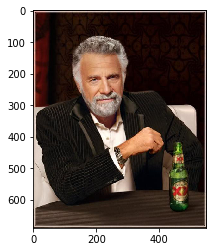

In [10]:
img = mpimg.imread('im.jpg')
imgplot = plt.imshow(img)

#### Check size and scale of rgb:

In [11]:
print('Image shape:')
print("(height, width, channels)")
print(img.shape)
print(" ")

height, width, channels = img.shape
all_pixels = height*width


print("All pixels: "+str(all_pixels)+" = X(train data)")
print("Each pixel has RGB(channels): "+ str(channels) +" = n(features)")

Image shape:
(height, width, channels)
(690, 550, 3)
 
All pixels: 379500 = X(train data)
Each pixel has RGB(channels): 3 = n(features)


In [12]:
print("!!!It is not scale in [0,1]!!!")

print('Example:'+str(img[0][2]))
print('        '+'[r  b  g ]')

!!!It is not scale in [0,1]!!!
Example:[73 19 19]
        [r  b  g ]


**Normalize pixels:**

Reshape all pixels from 1-D to 2-D

In [13]:
X = img.reshape((all_pixels, 3))
print("(X,n)")
print(X.shape)
print("(train data,features)")

(X,n)
(379500, 3)
(train data,features)


In [14]:
# normalize
X = X / 255

In [15]:
print("!!!Now,it is scale in [0,1]!!!")
print('Example:'+str(X))

!!!Now,it is scale in [0,1]!!!
Example:[[0.21176471 0.         0.        ]
 [0.22352941 0.01176471 0.01176471]
 [0.28627451 0.0745098  0.0745098 ]
 ...
 [0.18431373 0.11764706 0.08627451]
 [0.18431373 0.11764706 0.08627451]
 [0.18431373 0.11764706 0.08627451]]


## Main

We have train data $X$={$x_1,..,x_N$} which $x_n \in \Re ^D$  

with $N=379500$ and $D=3$

So we have for each pixel $x_n=[x_r, x_g, x_b]$ 

In [22]:
print("Shape of input:" + str(X.shape))
print("Input:" + str(X))

Shape of input:(379500, 3)
Input:[[0.21176471 0.         0.        ]
 [0.22352941 0.01176471 0.01176471]
 [0.28627451 0.0745098  0.0745098 ]
 ...
 [0.18431373 0.11764706 0.08627451]
 [0.18431373 0.11764706 0.08627451]
 [0.18431373 0.11764706 0.08627451]]


---

In [23]:
# μεγιστος αριθμος φορών που θα τρέξει ο αλγοριθμος,αν δεν συγκλινει
max_times = 150

# ανοχή,για να ελενξουμε αν συγλίνει
tolerance = 1e-5

# boolean για συγκλιση
convergence = False

---

In [24]:
# K: number of cluster
# K ομάδες-cluster
K = 64

---

## Run Algorithm

In [25]:
# step 1
print("STEP 1:INITIALIZATIONS PARAMETER:")
p, m, s = initialization_parameter(K, X)

STEP 1:INITIALIZATIONS PARAMETER:
Prior probabilities: [0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625]
Means: [[-0.90309564  0.96528831  1.64557282]
 [-1.81689823  0.61034894  0.82799631]
 [-0.38435023 -0.2131816   0.0182077 ]
 [-0.04470408 -0.12492276 -1.52491553]
 [ 1.40541836  1.2637088  -0.66227599]
 [-1.21333753  0.70515509 -0.4246997 ]
 [ 0.39503996 -0.13523821  0.84262703]
 [ 0.94783594 -0.5415071

---

In [26]:
probability = mix_Gaussian(X, p, m, s, K)
print(probability)

[[4.58806131e-05 4.87554561e-05 2.22348904e-03 ... 1.39879989e-11
  1.36272610e-12 2.14853507e-02]
 [4.77218229e-05 4.80893622e-05 2.19321176e-03 ... 1.94526127e-11
  1.32612581e-12 2.18164852e-02]
 [5.79378194e-05 4.40888914e-05 2.01806393e-03 ... 1.07153623e-10
  1.06675081e-12 2.31921755e-02]
 ...
 [8.54930219e-05 6.99805191e-05 2.16604455e-03 ... 1.86752391e-10
  4.14598536e-13 2.22457052e-02]
 [8.54930219e-05 6.99805191e-05 2.16604455e-03 ... 1.86752391e-10
  4.14598536e-13 2.22457052e-02]
 [8.54930219e-05 6.99805191e-05 2.16604455e-03 ... 1.86752391e-10
  4.14598536e-13 2.22457052e-02]]


In [27]:
t = 0
# Ο έλεγχος σύγκλισης γίνεται βάσει max_times και convergence 
while t < max_times and convergence == False:
    print("!Time t=" + str(t) + "!")
    
    # step 2
    g_znk = E_step(probability)
    
    # step 3
    m, s, p = M_step(X, g_znk, K)
    
    # keep old, because we will recalculate and need old for convergence 
    probability_old = probability
    # need to calculate t+1 g_znk
    probability = mix_Gaussian(X, p, m, s, K)
    
    # step 4
    # συνάρτηση ελέγχου συγκλισης
    convergence = findTargetE(probability_old,probability, tolerance)
    
    t+=1

!Time t=0!
Expectation Step
γ(Znk):[[1.60130352e-04 1.70163994e-04 7.76031658e-03 ... 4.88202540e-11
  4.75612237e-12 7.49871578e-02]
 [1.71952174e-04 1.73276499e-04 7.90262207e-03 ... 7.00920219e-11
  4.77832157e-12 7.86095717e-02]
 [2.50080879e-04 1.90303826e-04 8.71070409e-03 ... 4.62514340e-10
  4.60448774e-12 1.00105936e-01]
 ...
 [3.55865296e-04 2.91294396e-04 9.01617545e-03 ... 7.77358121e-10
  1.72576928e-12 9.25979018e-02]
 [3.55865296e-04 2.91294396e-04 9.01617545e-03 ... 7.77358121e-10
  1.72576928e-12 9.25979018e-02]
 [3.55865296e-04 2.91294396e-04 9.01617545e-03 ... 7.77358121e-10
  1.72576928e-12 9.25979018e-02]]
Maximization Step
Means: [[0.45744872 0.38412952 0.33772162]
 [0.18009565 0.12853829 0.102961  ]
 [0.2257099  0.15960297 0.12786969]
 [0.0896225  0.03632416 0.02494465]
 [0.74227753 0.57641534 0.46606473]
 [0.14729693 0.0974041  0.07441433]
 [0.38953218 0.30365099 0.25613536]
 [0.26899391 0.18937095 0.15064516]
 [0.16266675 0.10843398 0.08329189]
 [0.10846623 0.0

Check for Convergence subtraction of logarithmic likelihoods is:960515.5764095928
!Time t=2!
Expectation Step
γ(Znk):[[5.99957334e-013 1.92265959e-008 8.67861897e-008 ... 4.59042081e-116
  2.04403164e-017 1.24267857e-007]
 [1.59709103e-012 5.36543486e-008 2.24257169e-007 ... 7.75713604e-113
  5.65946356e-017 2.93432754e-007]
 [5.11992514e-010 1.32398927e-005 4.65041672e-005 ... 5.60616091e-096
  1.66340723e-014 4.58004277e-005]
 ...
 [8.93581234e-012 4.58230340e-007 1.31043229e-006 ... 2.44881582e-100
  3.57934725e-016 1.14101384e-006]
 [8.93581234e-012 4.58230340e-007 1.31043229e-006 ... 2.44881582e-100
  3.57934725e-016 1.14101384e-006]
 [8.93581234e-012 4.58230340e-007 1.31043229e-006 ... 2.44881582e-100
  3.57934725e-016 1.14101384e-006]]
Maximization Step
Means: [[0.6727907  0.49902652 0.38524423]
 [0.37550841 0.28085181 0.21561987]
 [0.44578918 0.3362547  0.25270096]
 [0.07187483 0.02627187 0.01946738]
 [0.77150107 0.57222748 0.44746474]
 [0.30103051 0.20815914 0.15629773]
 [0.62

Check for Convergence subtraction of logarithmic likelihoods is:147943.8581725778
!Time t=4!
Expectation Step
γ(Znk):[[1.05356997e-020 8.89518021e-012 3.64310230e-012 ... 2.46731988e-213
  2.18190766e-022 3.51709765e-012]
 [5.98267984e-020 4.82900188e-011 1.63151440e-011 ... 1.33095680e-207
  1.15417528e-021 1.36852853e-011]
 [2.08594656e-016 5.87780069e-008 1.20865971e-008 ... 1.71484405e-178
  1.93960777e-018 6.15122543e-009]
 ...
 [6.97414124e-019 1.05919076e-009 1.28604676e-010 ... 1.75555350e-185
  1.39001158e-020 4.98412353e-011]
 [6.97414124e-019 1.05919076e-009 1.28604676e-010 ... 1.75555350e-185
  1.39001158e-020 4.98412353e-011]
 [6.97414124e-019 1.05919076e-009 1.28604676e-010 ... 1.75555350e-185
  1.39001158e-020 4.98412353e-011]]
Maximization Step
Means: [[0.64852026 0.48184709 0.37098821]
 [0.39904798 0.30403336 0.2275363 ]
 [0.49266276 0.38228428 0.27991843]
 [0.08600199 0.05190463 0.03978559]
 [0.75320131 0.55675764 0.43638358]
 [0.3551508  0.19640337 0.12783378]
 [0.61

Check for Convergence subtraction of logarithmic likelihoods is:121100.24249598663
!Time t=6!
Expectation Step
γ(Znk):[[6.25759153e-023 2.66208737e-010 5.71745741e-016 ... 5.17458000e-223
  6.46055661e-029 4.97332321e-013]
 [3.62001990e-022 5.60457955e-010 3.08931093e-015 ... 3.39995520e-217
  6.82484818e-028 1.53502381e-012]
 [3.54054286e-018 2.54211755e-008 1.54096011e-011 ... 3.53604197e-187
  8.29897281e-023 5.92766390e-010]
 ...
 [2.96606534e-021 2.57963031e-010 4.21201777e-014 ... 9.37006447e-195
  9.18279352e-026 1.79312743e-012]
 [2.96606534e-021 2.57963031e-010 4.21201777e-014 ... 9.37006447e-195
  9.18279352e-026 1.79312743e-012]
 [2.96606534e-021 2.57963031e-010 4.21201777e-014 ... 9.37006447e-195
  9.18279352e-026 1.79312743e-012]]
Maximization Step
Means: [[0.64247918 0.46857871 0.35890321]
 [0.41959007 0.37812003 0.20568942]
 [0.50515932 0.40097822 0.3113837 ]
 [0.10071924 0.06135522 0.04508208]
 [0.75962818 0.54272642 0.41131722]
 [0.43099791 0.18330839 0.08396288]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:145422.15524979774
!Time t=8!
Expectation Step
γ(Znk):[[1.20351717e-025 5.06407564e-009 2.05177817e-023 ... 2.82052732e-235
  4.25592547e-047 5.16718305e-014]
 [7.62840916e-025 4.01499145e-009 2.63816693e-022 ... 2.81439929e-229
  6.05269074e-045 1.28101905e-013]
 [4.14950340e-020 6.79318252e-009 2.99057217e-016 ... 9.78643056e-198
  6.29157379e-034 6.26738142e-011]
 ...
 [1.94266711e-024 5.41600079e-011 3.92175697e-020 ... 1.61945384e-206
  1.05308510e-038 2.14185877e-014]
 [1.94266711e-024 5.41600079e-011 3.92175697e-020 ... 1.61945384e-206
  1.05308510e-038 2.14185877e-014]
 [1.94266711e-024 5.41600079e-011 3.92175697e-020 ... 1.61945384e-206
  1.05308510e-038 2.14185877e-014]]
Maximization Step
Means: [[0.64052612 0.46075243 0.34935775]
 [0.32631655 0.52094963 0.10801624]
 [0.50706803 0.40783498 0.33803345]
 [0.13058908 0.05049421 0.02627717]
 [0.78152751 0.52467945 0.37270515]
 [0.41971174 0.34521088 0.12226828]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:67878.64509123284
!Time t=10!
Expectation Step
γ(Znk):[[4.90295678e-028 4.04300736e-023 8.23581461e-031 ... 2.98854067e-247
  1.03785598e-103 6.46112694e-013]
 [3.00141741e-027 1.66928732e-022 2.03134965e-029 ... 4.27608004e-241
  5.62208069e-098 7.62418236e-013]
 [1.70194423e-021 6.09967536e-018 6.79452024e-021 ... 1.30113036e-207
  8.29047520e-069 1.35813297e-010]
 ...
 [4.16972910e-026 2.82258412e-019 3.43936484e-025 ... 8.87728505e-217
  2.78340115e-076 5.79597197e-014]
 [4.16972910e-026 2.82258412e-019 3.43936484e-025 ... 8.87728505e-217
  2.78340115e-076 5.79597197e-014]
 [4.16972910e-026 2.82258412e-019 3.43936484e-025 ... 8.87728505e-217
  2.78340115e-076 5.79597197e-014]]
Maximization Step
Means: [[0.63225421 0.45408214 0.34378392]
 [0.35202003 0.50427641 0.13610012]
 [0.52138318 0.42279559 0.35310323]
 [0.12945798 0.04491059 0.02206183]
 [0.78290011 0.52243972 0.36910358]
 [0.3905279  0.47904778 0.17681711]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:48833.79529213067
!Time t=12!
Expectation Step
γ(Znk):[[1.09817268e-028 7.87921677e-026 6.95297172e-035 ... 1.80651404e-255
  0.00000000e+000 2.94635156e-013]
 [7.39173313e-028 8.60327974e-025 2.52878314e-033 ... 4.57403498e-249
  0.00000000e+000 3.14580191e-013]
 [9.12130117e-022 4.07783879e-018 8.62794214e-024 ... 3.43303667e-214
  1.53152561e-226 4.76399028e-011]
 ...
 [3.21952651e-026 1.11650280e-019 3.44637780e-028 ... 1.67007076e-223
  4.80228760e-246 4.96962515e-014]
 [3.21952651e-026 1.11650280e-019 3.44637780e-028 ... 1.67007076e-223
  4.80228760e-246 4.96962515e-014]
 [3.21952651e-026 1.11650280e-019 3.44637780e-028 ... 1.67007076e-223
  4.80228760e-246 4.96962515e-014]]
Maximization Step
Means: [[0.62012409 0.47324597 0.37527746]
 [0.36193683 0.47076554 0.18129326]
 [0.53736523 0.44422586 0.37663745]
 [0.12842443 0.04455105 0.02198033]
 [0.78763965 0.5293418  0.37550022]
 [0.37490383 0.48200583 0.20757843]
 [0.5

Check for Convergence subtraction of logarithmic likelihoods is:45622.7116552107
!Time t=14!
Expectation Step
γ(Znk):[[1.47537642e-043 1.21008290e-022 8.59399369e-055 ... 5.92186745e-260
  0.00000000e+000 3.42231895e-016]
 [4.40896901e-042 8.15624636e-022 3.43005194e-052 ... 1.71329625e-253
  0.00000000e+000 3.75676748e-016]
 [2.31988884e-032 1.14259865e-015 3.67416688e-037 ... 7.30516615e-218
  0.00000000e+000 1.76163947e-013]
 ...
 [2.10269772e-037 2.58200803e-017 1.50945984e-042 ... 3.22866879e-227
  0.00000000e+000 3.41259312e-016]
 [2.10269772e-037 2.58200803e-017 1.50945984e-042 ... 3.22866879e-227
  0.00000000e+000 3.41259312e-016]
 [2.10269772e-037 2.58200803e-017 1.50945984e-042 ... 3.22866879e-227
  0.00000000e+000 3.41259312e-016]]
Maximization Step
Means: [[0.64113441 0.49638187 0.38030778]
 [0.35523247 0.45754605 0.18328964]
 [0.54973912 0.44856683 0.37541861]
 [0.12843062 0.04500251 0.02234325]
 [0.79705305 0.53868976 0.38276405]
 [0.36286791 0.48534885 0.18129656]
 [0.59

Check for Convergence subtraction of logarithmic likelihoods is:24049.204795133322
!Time t=16!
Expectation Step
γ(Znk):[[9.36483111e-071 8.49489861e-022 2.54154719e-067 ... 2.08036642e-267
  2.75923793e-209 3.10718305e-018]
 [5.39174782e-068 4.46878406e-021 4.90277792e-064 ... 7.98202849e-261
  1.54557597e-196 2.56653546e-018]
 [1.86092965e-051 6.05689022e-015 3.39495799e-045 ... 5.09756241e-224
  8.54300491e-133 9.99619053e-016]
 ...
 [1.15357434e-058 1.52550432e-016 5.08936665e-052 ... 1.43327179e-233
  1.41476750e-145 3.85313415e-018]
 [1.15357434e-058 1.52550432e-016 5.08936665e-052 ... 1.43327179e-233
  1.41476750e-145 3.85313415e-018]
 [1.15357434e-058 1.52550432e-016 5.08936665e-052 ... 1.43327179e-233
  1.41476750e-145 3.85313415e-018]]
Maximization Step
Means: [[0.65873089 0.507645   0.37265014]
 [0.34606759 0.44673556 0.17636653]
 [0.58071502 0.44668724 0.34457969]
 [0.12689525 0.04393312 0.02185357]
 [0.80691198 0.55005495 0.39298959]
 [0.35966662 0.59342323 0.06617643]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:23389.74184122123
!Time t=18!
Expectation Step
γ(Znk):[[3.38448947e-117 3.55800120e-021 9.32452562e-082 ... 6.29908570e-275
  2.14186645e-161 7.14963534e-092]
 [3.92083004e-112 1.50999913e-020 9.72028993e-078 ... 3.19547572e-268
  9.12819671e-152 1.20647175e-088]
 [8.16122365e-084 2.17683379e-014 7.73782850e-055 ... 2.89594357e-230
  2.19405391e-102 5.19221001e-070]
 ...
 [1.66511089e-094 5.69255419e-016 1.11747664e-063 ... 4.56736601e-240
  3.79272985e-113 5.36493627e-070]
 [1.66511089e-094 5.69255419e-016 1.11747664e-063 ... 4.56736601e-240
  3.79272985e-113 5.36493627e-070]
 [1.66511089e-094 5.69255419e-016 1.11747664e-063 ... 4.56736601e-240
  3.79272985e-113 5.36493627e-070]]
Maximization Step
Means: [[0.6625367  0.51047742 0.37904007]
 [0.33813416 0.43690253 0.17023533]
 [0.60189398 0.44864108 0.33856958]
 [0.12254867 0.04061326 0.02022421]
 [0.8155924  0.5603862  0.40303747]
 [0.33663639 0.59988235 0.01868495]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:20163.872374929488
!Time t=20!
Expectation Step
γ(Znk):[[1.36177891e-148 1.35014709e-021 4.50977505e-087 ... 7.05159552e-281
  2.99552921e-147 1.36755881e-090]
 [6.42175708e-142 5.66039269e-021 7.25722774e-083 ... 4.48117546e-274
  1.36940780e-138 4.02590751e-087]
 [2.87826722e-105 2.01366423e-014 1.49462027e-058 ... 3.93454427e-235
  2.32854580e-093 6.13389769e-067]
 ...
 [2.13755805e-118 5.63799381e-016 2.98957064e-068 ... 3.63781263e-245
  1.45743771e-103 1.39891962e-066]
 [2.13755805e-118 5.63799381e-016 2.98957064e-068 ... 3.63781263e-245
  1.45743771e-103 1.39891962e-066]
 [2.13755805e-118 5.63799381e-016 2.98957064e-068 ... 3.63781263e-245
  1.45743771e-103 1.39891962e-066]]
Maximization Step
Means: [[0.65375482 0.50100025 0.38202053]
 [0.32996515 0.42901944 0.16362093]
 [0.61271177 0.45039834 0.33888079]
 [0.118725   0.03782816 0.01886612]
 [0.82369063 0.56916405 0.41111909]
 [0.34214412 0.5797488  0.04047512]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:14159.721093629487
!Time t=22!
Expectation Step
γ(Znk):[[3.28654059e-197 1.03758541e-021 3.73770925e-091 ... 1.43003359e-286
  2.66176035e-143 2.09941641e-064]
 [7.24562372e-188 3.79077453e-021 7.71707933e-087 ... 1.07549972e-279
  5.35257102e-135 3.47770436e-062]
 [1.00177105e-137 2.12967398e-014 1.92273556e-061 ... 8.00801984e-240
  6.37500184e-091 2.50322199e-047]
 ...
 [1.47352243e-154 7.00253449e-016 1.13654010e-071 ... 4.49426444e-250
  5.30690315e-101 4.52531977e-048]
 [1.47352243e-154 7.00253449e-016 1.13654010e-071 ... 4.49426444e-250
  5.30690315e-101 4.52531977e-048]
 [1.47352243e-154 7.00253449e-016 1.13654010e-071 ... 4.49426444e-250
  5.30690315e-101 4.52531977e-048]]
Maximization Step
Means: [[0.64528526 0.48920227 0.38685669]
 [0.32023356 0.42182344 0.15787444]
 [0.61966914 0.45359778 0.34198798]
 [0.11604868 0.03591827 0.01795108]
 [0.82997442 0.57617625 0.41757653]
 [0.3217273  0.56593081 0.02598394]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:10429.337856804952
!Time t=24!
Expectation Step
γ(Znk):[[0.00000000e+000 8.47941694e-022 1.32395174e-095 ... 2.84826376e-293
  1.16283790e-146 1.91171724e-061]
 [0.00000000e+000 2.84796024e-021 3.84246572e-091 ... 2.78000105e-286
  3.06205088e-138 2.02003014e-059]
 [6.60326692e-290 2.51117727e-014 1.40062061e-064 ... 2.18045423e-245
  3.66505090e-093 4.71209999e-045]
 ...
 [1.48219694e-323 1.03315432e-015 2.92543926e-075 ... 7.20135855e-256
  1.92957766e-103 4.53120799e-046]
 [1.48219694e-323 1.03315432e-015 2.92543926e-075 ... 7.20135855e-256
  1.92957766e-103 4.53120799e-046]
 [1.48219694e-323 1.03315432e-015 2.92543926e-075 ... 7.20135855e-256
  1.92957766e-103 4.53120799e-046]]
Maximization Step
Means: [[0.64594392 0.48604223 0.39364867]
 [0.31105729 0.40832766 0.15704985]
 [0.62121708 0.45205807 0.33873241]
 [0.11429275 0.03465259 0.01734996]
 [0.8348902  0.581825   0.42299356]
 [0.30230223 0.54383134 0.01861166]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:7708.994331588969
!Time t=26!
Expectation Step
γ(Znk):[[4.95831839e-260 2.28381687e-022 4.04787948e-095 ... 1.85001794e-301
  1.59818371e-146 8.77397161e-067]
 [2.48668281e-247 8.70894316e-022 1.16989891e-090 ... 2.72977224e-294
  3.52752955e-138 1.64808441e-064]
 [3.95641048e-180 2.10360224e-014 6.93233696e-064 ... 3.27270861e-252
  3.42736016e-093 9.35735776e-049]
 ...
 [7.59611500e-202 1.15743236e-015 8.14184321e-075 ... 6.07796305e-263
  1.72459530e-103 1.84042965e-049]
 [7.59611500e-202 1.15743236e-015 8.14184321e-075 ... 6.07796305e-263
  1.72459530e-103 1.84042965e-049]
 [7.59611500e-202 1.15743236e-015 8.14184321e-075 ... 6.07796305e-263
  1.72459530e-103 1.84042965e-049]]
Maximization Step
Means: [[0.64590249 0.48738692 0.39654514]
 [0.30368917 0.39415662 0.15709637]
 [0.61740788 0.4458868  0.33162282]
 [0.11314988 0.03382237 0.01696079]
 [0.84038139 0.58718965 0.42748924]
 [0.29488629 0.52742032 0.02291469]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:5747.062747987919
!Time t=28!
Expectation Step
γ(Znk):[[6.18644218e-182 6.48466455e-023 1.20271215e-096 ... 8.64794043e-311
  1.18613971e-144 1.44145352e-067]
 [2.13308368e-173 2.96892011e-022 4.69350274e-092 ... 2.13968228e-303
  1.78877715e-136 2.95598523e-065]
 [2.58141138e-126 2.01288145e-014 1.58526266e-064 ... 5.26897928e-260
  4.22429665e-092 3.33378490e-049]
 ...
 [2.79452532e-142 1.49897949e-015 9.87990469e-076 ... 5.33170423e-271
  2.49434637e-102 9.62083417e-050]
 [2.79452532e-142 1.49897949e-015 9.87990469e-076 ... 5.33170423e-271
  2.49434637e-102 9.62083417e-050]
 [2.79452532e-142 1.49897949e-015 9.87990469e-076 ... 5.33170423e-271
  2.49434637e-102 9.62083417e-050]]
Maximization Step
Means: [[0.64808437 0.48874772 0.39642537]
 [0.29775083 0.38166515 0.15469543]
 [0.61262843 0.44233423 0.32926626]
 [0.11240066 0.03327589 0.01670709]
 [0.84569057 0.5922271  0.43160567]
 [0.29154535 0.51609209 0.02993927]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:4667.759537158534
!Time t=30!
Expectation Step
γ(Znk):[[6.52177765e-160 7.91095714e-023 1.08672953e-096 ... 4.94065646e-321
  7.36548258e-143 4.50556928e-065]
 [1.40593520e-152 3.95309435e-022 4.54925276e-092 ... 2.19492049e-313
  7.77143281e-135 6.87885385e-063]
 [3.09938825e-111 4.42550281e-014 2.68722378e-064 ... 1.42039461e-268
  4.52901260e-091 2.39579019e-047]
 ...
 [1.18124814e-125 4.11964608e-015 1.68155845e-075 ... 7.60262714e-280
  3.30897574e-101 6.92086304e-048]
 [1.18124814e-125 4.11964608e-015 1.68155845e-075 ... 7.60262714e-280
  3.30897574e-101 6.92086304e-048]
 [1.18124814e-125 4.11964608e-015 1.68155845e-075 ... 7.60262714e-280
  3.30897574e-101 6.92086304e-048]]
Maximization Step
Means: [[0.65151803 0.49053083 0.39604343]
 [0.29193143 0.37070695 0.14934257]
 [0.6081836  0.44053829 0.32824827]
 [0.11190418 0.03291255 0.01653935]
 [0.8501684  0.59665737 0.43586644]
 [0.28696613 0.5043099  0.03716669]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:4001.114502030425
!Time t=32!
Expectation Step
γ(Znk):[[2.95507385e-150 1.31792661e-021 1.05776269e-095 ... 0.00000000e+000
  4.05436766e-141 1.45008577e-062]
 [1.78241122e-143 5.72649657e-021 4.04813579e-091 ... 4.94065646e-324
  3.01407806e-133 1.60181922e-060]
 [1.00556079e-104 3.64222481e-013 1.84415816e-063 ... 6.46416858e-278
  4.23033303e-090 1.44676566e-045]
 ...
 [1.72635922e-118 3.71127909e-014 1.54101075e-074 ... 1.77207094e-289
  3.96846568e-100 4.07195423e-046]
 [1.72635922e-118 3.71127909e-014 1.54101075e-074 ... 1.77207094e-289
  3.96846568e-100 4.07195423e-046]
 [1.72635922e-118 3.71127909e-014 1.54101075e-074 ... 1.77207094e-289
  3.96846568e-100 4.07195423e-046]]
Maximization Step
Means: [[0.65512118 0.49257026 0.39623516]
 [0.28491216 0.36083321 0.14162348]
 [0.60494437 0.43933844 0.32736539]
 [0.11157121 0.03266816 0.0164269 ]
 [0.85402871 0.60094206 0.44005215]
 [0.28005283 0.48930903 0.04472327]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:3137.528836716898
!Time t=34!
Expectation Step
γ(Znk):[[2.52948796e-144 9.90768216e-020 6.04811114e-094 ... 0.00000000e+000
  3.25099613e-139 1.46467185e-062]
 [6.71088263e-138 3.19690829e-019 1.87258714e-089 ... 0.00000000e+000
  1.65748939e-131 1.61490565e-060]
 [8.37299222e-101 5.52593434e-012 3.50760543e-062 ... 4.25599503e-288
  4.70148803e-089 1.56405672e-045]
 ...
 [3.76316239e-114 5.79757176e-013 4.35516896e-073 ... 5.75394378e-300
  5.89375144e-099 6.22418952e-046]
 [3.76316239e-114 5.79757176e-013 4.35516896e-073 ... 5.75394378e-300
  5.89375144e-099 6.22418952e-046]
 [3.76316239e-114 5.79757176e-013 4.35516896e-073 ... 5.75394378e-300
  5.89375144e-099 6.22418952e-046]]
Maximization Step
Means: [[0.65856878 0.49489592 0.39715121]
 [0.27716294 0.35223666 0.13282098]
 [0.60323936 0.43836069 0.32634337]
 [0.11134531 0.03250201 0.01635063]
 [0.85769339 0.60523674 0.4443184 ]
 [0.27273324 0.47220607 0.0516269 ]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:2519.7556940987706
!Time t=36!
Expectation Step
γ(Znk):[[5.60108657e-140 4.26539194e-018 1.09426614e-091 ... 0.00000000e+000
  4.99060087e-137 8.24586721e-060]
 [7.91286858e-134 1.03179648e-017 2.52084607e-087 ... 0.00000000e+000
  1.67081382e-129 6.83057443e-058]
 [5.31658048e-098 4.98525195e-011 1.25308260e-060 ... 7.89137724e-299
  7.47454231e-088 1.75973526e-043]
 ...
 [5.21746872e-111 5.55874180e-012 2.38677957e-071 ... 5.15318956e-311
  1.30192314e-097 7.86749686e-044]
 [5.21746872e-111 5.55874180e-012 2.38677957e-071 ... 5.15318956e-311
  1.30192314e-097 7.86749686e-044]
 [5.21746872e-111 5.55874180e-012 2.38677957e-071 ... 5.15318956e-311
  1.30192314e-097 7.86749686e-044]]
Maximization Step
Means: [[0.66198423 0.49760302 0.39874218]
 [0.27023148 0.3460545  0.12681274]
 [0.60286419 0.43754811 0.3252061 ]
 [0.11119048 0.03238803 0.01629843]
 [0.86144169 0.60979579 0.44893717]
 [0.2657721  0.45603803 0.0564865 ]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:2402.505784022622
!Time t=38!
Expectation Step
γ(Znk):[[2.00668699e-136 4.00922954e-017 2.48859822e-089 ... 0.00000000e+000
  1.43341565e-134 3.09949787e-061]
 [1.65641896e-130 8.08907565e-017 4.16188669e-085 ... 0.00000000e+000
  3.03078204e-127 3.18770878e-059]
 [9.03110657e-096 1.74557750e-010 4.69685667e-059 ... 1.97145092e-309
  1.70004051e-086 2.15836691e-044]
 ...
 [1.79879260e-108 2.14106077e-011 1.33636965e-069 ... 6.32404027e-322
  4.24035550e-096 1.61910103e-044]
 [1.79879260e-108 2.14106077e-011 1.33636965e-069 ... 6.32404027e-322
  4.24035550e-096 1.61910103e-044]
 [1.79879260e-108 2.14106077e-011 1.33636965e-069 ... 6.32404027e-322
  4.24035550e-096 1.61910103e-044]]
Maximization Step
Means: [[0.66567188 0.50075196 0.40088882]
 [0.26583751 0.34145456 0.12393286]
 [0.6034796  0.43698943 0.32417091]
 [0.11108353 0.0323094  0.01626254]
 [0.86546671 0.61489203 0.45428117]
 [0.26145856 0.44348362 0.05923724]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:2304.519551217556
!Time t=40!
Expectation Step
γ(Znk):[[2.42810414e-133 7.22418978e-017 3.61125505e-087 ... 0.00000000e+000
  5.82867690e-132 2.46712329e-062]
 [1.23868954e-127 1.42419540e-016 4.47950915e-083 ... 0.00000000e+000
  7.66732084e-125 3.04618508e-060]
 [6.80284158e-094 2.61470353e-010 1.20665336e-057 ... 1.44603133e-319
  4.72939875e-085 4.53662016e-045]
 ...
 [2.58151411e-106 3.61342791e-011 4.85921572e-068 ... 0.00000000e+000
  1.69387668e-094 4.99624852e-045]
 [2.58151411e-106 3.61342791e-011 4.85921572e-068 ... 0.00000000e+000
  1.69387668e-094 4.99624852e-045]
 [2.58151411e-106 3.61342791e-011 4.85921572e-068 ... 0.00000000e+000
  1.69387668e-094 4.99624852e-045]]
Maximization Step
Means: [[0.66997039 0.50436491 0.40350978]
 [0.26370188 0.33738697 0.1221135 ]
 [0.60471369 0.43675892 0.32353421]
 [0.11100956 0.03225543 0.01623804]
 [0.86983313 0.6207713  0.46075943]
 [0.25731597 0.43307632 0.05988785]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:2357.741330932826
!Time t=42!
Expectation Step
γ(Znk):[[8.79437706e-131 7.17995375e-017 1.10337802e-085 ... 0.00000000e+000
  1.96678068e-129 1.23600194e-060]
 [2.96388498e-125 1.48311902e-016 1.12143609e-081 ... 0.00000000e+000
  1.65580551e-122 1.31544434e-058]
 [2.09881478e-092 2.93018879e-010 1.07905163e-056 ... 0.00000000e+000
  1.18440977e-083 9.00320163e-044]
 ...
 [1.34204917e-104 4.45999214e-011 5.22189313e-067 ... 0.00000000e+000
  5.78572608e-093 8.61304618e-044]
 [1.34204917e-104 4.45999214e-011 5.22189313e-067 ... 0.00000000e+000
  5.78572608e-093 8.61304618e-044]
 [1.34204917e-104 4.45999214e-011 5.22189313e-067 ... 0.00000000e+000
  5.78572608e-093 8.61304618e-044]]
Maximization Step
Means: [[0.6751092  0.50845127 0.40663511]
 [0.26186142 0.33440514 0.12081408]
 [0.60628866 0.43655909 0.32376235]
 [0.11095959 0.03222005 0.01622228]
 [0.87438112 0.62738508 0.46842242]
 [0.25164592 0.42438257 0.05886861]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:2557.679451342672
!Time t=44!
Expectation Step
γ(Znk):[[4.53425057e-129 8.92103857e-017 2.74478205e-085 ... 0.00000000e+000
  2.47117943e-127 5.96722705e-058]
 [1.08607836e-123 1.84593827e-016 2.60303616e-081 ... 0.00000000e+000
  1.40017062e-120 4.73776744e-056]
 [1.65413973e-091 3.77876645e-010 1.95011397e-056 ... 0.00000000e+000
  1.71001019e-082 9.01963201e-042]
 ...
 [1.41037071e-103 5.69771068e-011 8.47783796e-067 ... 0.00000000e+000
  9.95758358e-092 5.55028872e-042]
 [1.41037071e-103 5.69771068e-011 8.47783796e-067 ... 0.00000000e+000
  9.95758358e-092 5.55028872e-042]
 [1.41037071e-103 5.69771068e-011 8.47783796e-067 ... 0.00000000e+000
  9.95758358e-092 5.55028872e-042]]
Maximization Step
Means: [[0.68103829 0.51298379 0.41027868]
 [0.25987813 0.33228257 0.11964099]
 [0.60794807 0.43635307 0.32506999]
 [0.11092875 0.03220012 0.01621392]
 [0.87882326 0.63402557 0.47622824]
 [0.24451628 0.41711485 0.05700802]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:1924.5429146168754
!Time t=46!
Expectation Step
γ(Znk):[[2.40309373e-128 1.56162289e-016 1.19453323e-085 ... 0.00000000e+000
  4.15352965e-126 2.17721239e-055]
 [4.46361232e-123 3.05267391e-016 1.14131724e-081 ... 0.00000000e+000
  1.76236471e-119 1.26912098e-053]
 [2.65119095e-091 5.94736265e-010 1.14115981e-056 ... 0.00000000e+000
  7.20567467e-082 7.39013760e-040]
 ...
 [2.48218516e-103 8.14747951e-011 3.86277108e-067 ... 0.00000000e+000
  4.42695091e-091 2.79377915e-040]
 [2.48218516e-103 8.14747951e-011 3.86277108e-067 ... 0.00000000e+000
  4.42695091e-091 2.79377915e-040]
 [2.48218516e-103 8.14747951e-011 3.86277108e-067 ... 0.00000000e+000
  4.42695091e-091 2.79377915e-040]]
Maximization Step
Means: [[0.68733901 0.51775804 0.4141168 ]
 [0.2581065  0.33041075 0.11832319]
 [0.60958867 0.43649044 0.32713854]
 [0.11090986 0.03218787 0.01620888]
 [0.88294691 0.63971629 0.48260315]
 [0.23583009 0.41063647 0.05471691]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1363.3519464610144
!Time t=48!
Expectation Step
γ(Znk):[[1.04892402e-128 2.92048702e-016 2.81254467e-086 ... 0.00000000e+000
  7.99043629e-126 1.82878757e-053]
 [1.74137133e-123 5.43490641e-016 2.82778703e-082 ... 0.00000000e+000
  2.95755803e-119 8.51821933e-052]
 [6.80566864e-092 8.92712084e-010 3.94531161e-057 ... 0.00000000e+000
  7.08642763e-082 1.90115481e-038]
 ...
 [6.32754391e-104 1.16671769e-010 1.12959349e-067 ... 0.00000000e+000
  4.50318306e-091 5.24808381e-039]
 [6.32754391e-104 1.16671769e-010 1.12959349e-067 ... 0.00000000e+000
  4.50318306e-091 5.24808381e-039]
 [6.32754391e-104 1.16671769e-010 1.12959349e-067 ... 0.00000000e+000
  4.50318306e-091 5.24808381e-039]]
Maximization Step
Means: [[0.69371129 0.52255466 0.41791173]
 [0.256715   0.3288427  0.11700761]
 [0.61111986 0.43705506 0.32913794]
 [0.11089319 0.03217471 0.01620276]
 [0.88639938 0.64396297 0.48700551]
 [0.22539589 0.40420556 0.0520355 ]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1287.9530042223632
!Time t=50!
Expectation Step
γ(Znk):[[7.19088090e-131 4.44333419e-016 9.04964788e-087 ... 0.00000000e+000
  2.62504460e-126 2.54777862e-052]
 [1.30785569e-125 8.03001650e-016 9.49122145e-083 ... 0.00000000e+000
  9.50552963e-120 1.04334077e-050]
 [8.69344744e-094 1.15884421e-009 1.67578367e-057 ... 0.00000000e+000
  2.19595674e-082 1.31473551e-037]
 ...
 [6.14823954e-106 1.49382869e-010 4.26419244e-068 ... 0.00000000e+000
  1.36665724e-091 2.98875169e-038]
 [6.14823954e-106 1.49382869e-010 4.26419244e-068 ... 0.00000000e+000
  1.36665724e-091 2.98875169e-038]
 [6.14823954e-106 1.49382869e-010 4.26419244e-068 ... 0.00000000e+000
  1.36665724e-091 2.98875169e-038]]
Maximization Step
Means: [[0.70061413 0.52778808 0.42212861]
 [0.25579924 0.32759569 0.11586794]
 [0.61163868 0.43652086 0.3287236 ]
 [0.11087647 0.03216085 0.0161961 ]
 [0.88875299 0.64665821 0.48965495]
 [0.21343822 0.39729492 0.04889105]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1416.510692874901
!Time t=52!
Expectation Step
γ(Znk):[[1.03098029e-136 5.40018488e-016 3.48425376e-086 ... 0.00000000e+000
  1.13377249e-127 1.90456822e-051]
 [2.97925045e-131 9.64051822e-016 3.55689269e-082 ... 0.00000000e+000
  4.55137897e-121 7.04261263e-050]
 [2.15213657e-098 1.33666117e-009 5.48632469e-057 ... 0.00000000e+000
  1.86656407e-083 5.71797485e-037]
 ...
 [6.63690318e-111 1.71066789e-010 1.23537424e-067 ... 0.00000000e+000
  1.04543814e-092 1.12352748e-037]
 [6.63690318e-111 1.71066789e-010 1.23537424e-067 ... 0.00000000e+000
  1.04543814e-092 1.12352748e-037]
 [6.63690318e-111 1.71066789e-010 1.23537424e-067 ... 0.00000000e+000
  1.04543814e-092 1.12352748e-037]]
Maximization Step
Means: [[0.70883175 0.53437745 0.42739627]
 [0.25540401 0.32660557 0.1150355 ]
 [0.60892744 0.43219518 0.32139072]
 [0.11086081 0.03214806 0.01618997]
 [0.88989429 0.64799855 0.49101672]
 [0.20131768 0.38996336 0.04565327]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:1067.3674509376287
!Time t=54!
Expectation Step
γ(Znk):[[1.76996226e-144 5.40911660e-016 5.22148831e-087 ... 0.00000000e+000
  9.86624817e-130 1.06510983e-050]
 [9.68440315e-139 9.67370274e-016 6.93709273e-083 ... 0.00000000e+000
  4.83597927e-123 3.58173670e-049]
 [1.88250589e-104 1.41614565e-009 3.67215300e-057 ... 0.00000000e+000
  5.75946698e-085 1.99402284e-036]
 ...
 [1.92918802e-117 1.78393201e-010 4.13318063e-068 ... 0.00000000e+000
  2.72144473e-094 3.49105830e-037]
 [1.92918802e-117 1.78393201e-010 4.13318063e-068 ... 0.00000000e+000
  2.72144473e-094 3.49105830e-037]
 [1.92918802e-117 1.78393201e-010 4.13318063e-068 ... 0.00000000e+000
  2.72144473e-094 3.49105830e-037]]
Maximization Step
Means: [[0.71624886 0.54019025 0.43231695]
 [0.25550899 0.32589682 0.11454954]
 [0.60575003 0.4273424  0.31411921]
 [0.11084683 0.03213672 0.01618457]
 [0.89015449 0.64851551 0.49171961]
 [0.19110316 0.38294331 0.04325445]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:676.8138462901115
!Time t=56!
Expectation Step
γ(Znk):[[2.53537067e-148 4.74767951e-016 2.44309357e-088 ... 0.00000000e+000
  6.72109816e-131 3.99593618e-050]
 [1.77539063e-142 8.58078127e-016 4.31259582e-084 ... 0.00000000e+000
  3.54097868e-124 1.24165640e-048]
 [1.35946972e-107 1.41671938e-009 9.16350838e-058 ... 0.00000000e+000
  6.80007873e-086 5.22080462e-036]
 ...
 [8.30581942e-121 1.73196011e-010 5.32495037e-069 ... 0.00000000e+000
  2.92551692e-095 8.33717335e-037]
 [8.30581942e-121 1.73196011e-010 5.32495037e-069 ... 0.00000000e+000
  2.92551692e-095 8.33717335e-037]
 [8.30581942e-121 1.73196011e-010 5.32495037e-069 ... 0.00000000e+000
  2.92551692e-095 8.33717335e-037]]
Maximization Step
Means: [[0.72164727 0.54416319 0.43609429]
 [0.25600684 0.32560368 0.11432636]
 [0.60434318 0.42467496 0.31151035]
 [0.11083428 0.03212642 0.01617964]
 [0.88998446 0.64871688 0.49223241]
 [0.18371557 0.37714355 0.04223919]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:452.68818653933704
!Time t=58!
Expectation Step
γ(Znk):[[1.60198277e-149 3.94202189e-016 5.83551411e-088 ... 0.00000000e+000
  2.45826260e-131 1.08714056e-049]
 [1.12530831e-143 7.21350303e-016 1.01107074e-083 ... 0.00000000e+000
  1.26037836e-124 3.16937158e-048]
 [1.00758093e-108 1.36971992e-009 2.10318693e-057 ... 0.00000000e+000
  2.42865341e-086 1.08446727e-035]
 ...
 [5.45815879e-122 1.60426141e-010 1.13554994e-068 ... 0.00000000e+000
  1.00529582e-095 1.60904629e-036]
 [5.45815879e-122 1.60426141e-010 1.13554994e-068 ... 0.00000000e+000
  1.00529582e-095 1.60904629e-036]
 [5.45815879e-122 1.60426141e-010 1.13554994e-068 ... 0.00000000e+000
  1.00529582e-095 1.60904629e-036]]
Maximization Step
Means: [[0.72555808 0.54713366 0.43897951]
 [0.2567793  0.3258167  0.11429007]
 [0.60371437 0.42390362 0.31092111]
 [0.11082275 0.03211677 0.01617497]
 [0.88970192 0.64884808 0.49270305]
 [0.17866311 0.37294725 0.04221932]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:318.0457599842921
!Time t=60!
Expectation Step
γ(Znk):[[3.76435199e-150 3.15359658e-016 4.58176653e-087 ... 0.00000000e+000
  1.33661930e-131 2.33220413e-049]
 [2.56719539e-144 5.84682720e-016 7.00668085e-083 ... 0.00000000e+000
  6.55130641e-125 6.45797712e-048]
 [2.24255601e-109 1.28110785e-009 8.66751028e-057 ... 0.00000000e+000
  1.15043540e-086 1.88887220e-035]
 ...
 [1.17276152e-122 1.42871138e-010 5.67266886e-068 ... 0.00000000e+000
  4.61919550e-096 2.65139352e-036]
 [1.17276152e-122 1.42871138e-010 5.67266886e-068 ... 0.00000000e+000
  4.61919550e-096 2.65139352e-036]
 [1.17276152e-122 1.42871138e-010 5.67266886e-068 ... 0.00000000e+000
  4.61919550e-096 2.65139352e-036]]
Maximization Step
Means: [[0.72849696 0.54949533 0.44129101]
 [0.25774803 0.32648854 0.11446382]
 [0.60320989 0.42427527 0.31119275]
 [0.11081202 0.03210768 0.01617056]
 [0.8894505  0.64898254 0.49314248]
 [0.1751744  0.37016325 0.04259201]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:236.61238647811115
!Time t=62!
Expectation Step
γ(Znk):[[1.07227169e-150 2.37277841e-016 2.05426081e-086 ... 0.00000000e+000
  6.48591312e-132 4.01818859e-049]
 [7.17417734e-145 4.47551102e-016 2.82671320e-082 ... 0.00000000e+000
  3.07970342e-125 1.06883115e-047]
 [6.31980416e-110 1.14675908e-009 2.27658967e-056 ... 0.00000000e+000
  5.18189027e-087 2.78696614e-035]
 ...
 [3.22053728e-123 1.22233152e-010 1.87917378e-067 ... 0.00000000e+000
  2.00454442e-096 3.76562342e-036]
 [3.22053728e-123 1.22233152e-010 1.87917378e-067 ... 0.00000000e+000
  2.00454442e-096 3.76562342e-036]
 [3.22053728e-123 1.22233152e-010 1.87917378e-067 ... 0.00000000e+000
  2.00454442e-096 3.76562342e-036]]
Maximization Step
Means: [[0.73079156 0.55142762 0.44320933]
 [0.25878116 0.32745786 0.11490407]
 [0.60264012 0.42523892 0.31195979]
 [0.11080214 0.03209929 0.01616646]
 [0.8892666  0.64913019 0.49354295]
 [0.17276407 0.36842099 0.04300382]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:187.28638670314103
!Time t=64!
Expectation Step
γ(Znk):[[3.24794922e-151 1.70050722e-016 4.21422956e-086 ... 0.00000000e+000
  2.47859218e-132 5.32926060e-049]
 [2.15481827e-145 3.27640055e-016 5.43935989e-082 ... 0.00000000e+000
  1.16327728e-125 1.37952330e-047]
 [1.98816183e-110 9.92738884e-010 3.46342794e-056 ... 0.00000000e+000
  2.04043223e-087 3.37666413e-035]
 ...
 [9.86844930e-124 1.02496028e-010 3.52184075e-067 ... 0.00000000e+000
  7.53559854e-097 4.46404576e-036]
 [9.86844930e-124 1.02496028e-010 3.52184075e-067 ... 0.00000000e+000
  7.53559854e-097 4.46404576e-036]
 [9.86844930e-124 1.02496028e-010 3.52184075e-067 ... 0.00000000e+000
  7.53559854e-097 4.46404576e-036]]
Maximization Step
Means: [[0.73265057 0.55304821 0.44483969]
 [0.25961228 0.32845749 0.11560653]
 [0.60200487 0.42646227 0.31300521]
 [0.11079317 0.03209169 0.01616275]
 [0.88914639 0.64928512 0.4939009 ]
 [0.17121265 0.36741177 0.04331756]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:157.3508158652112
!Time t=66!
Expectation Step
γ(Znk):[[1.00590858e-151 1.27569019e-016 5.02572786e-086 ... 0.00000000e+000
  7.65051494e-133 5.14408232e-049]
 [6.67425020e-146 2.50115425e-016 6.27698370e-082 ... 0.00000000e+000
  3.61289243e-126 1.31563486e-047]
 [6.65503158e-111 8.74646083e-010 3.64916846e-056 ... 0.00000000e+000
  7.12860087e-088 3.22504020e-035]
 ...
 [3.20623259e-124 8.89647231e-011 4.43453986e-067 ... 0.00000000e+000
  2.49469059e-097 4.23570925e-036]
 [3.20623259e-124 8.89647231e-011 4.43453986e-067 ... 0.00000000e+000
  2.49469059e-097 4.23570925e-036]
 [3.20623259e-124 8.89647231e-011 4.43453986e-067 ... 0.00000000e+000
  2.49469059e-097 4.23570925e-036]]
Maximization Step
Means: [[0.73420728 0.5544386  0.44625199]
 [0.25999026 0.32916571 0.1164214 ]
 [0.60135609 0.42774191 0.31416252]
 [0.11078516 0.03208489 0.01615944]
 [0.88907627 0.64944032 0.49421733]
 [0.17042248 0.36692207 0.04347663]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:140.80559193063527
!Time t=68!
Expectation Step
γ(Znk):[[3.12354534e-152 1.08381943e-016 4.49127199e-086 ... 0.00000000e+000
  2.04907021e-133 3.44284114e-049]
 [2.08677846e-146 2.14170079e-016 5.52548789e-082 ... 0.00000000e+000
  9.86310944e-127 8.84673201e-048]
 [2.30782703e-111 8.21359057e-010 3.18003485e-056 ... 0.00000000e+000
  2.31288210e-088 2.34099061e-035]
 ...
 [1.07405193e-124 8.32577803e-011 4.49565213e-067 ... 0.00000000e+000
  7.63235836e-098 3.09879315e-036]
 [1.07405193e-124 8.32577803e-011 4.49565213e-067 ... 0.00000000e+000
  7.63235836e-098 3.09879315e-036]
 [1.07405193e-124 8.32577803e-011 4.49565213e-067 ... 0.00000000e+000
  7.63235836e-098 3.09879315e-036]]
Maximization Step
Means: [[0.73554638 0.55565458 0.44749518]
 [0.26003928 0.32933219 0.11704898]
 [0.60074386 0.42895407 0.31531437]
 [0.11077805 0.03207886 0.01615649]
 [0.88904269 0.64959096 0.4944959 ]
 [0.17029519 0.36673551 0.04330166]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:138.63202408794314
!Time t=70!
Expectation Step
γ(Znk):[[9.73902205e-153 9.31566244e-017 3.60624587e-086 ... 0.00000000e+000
  5.13169646e-134 1.55198713e-049]
 [6.58350157e-147 1.86394910e-016 4.40473054e-082 ... 0.00000000e+000
  2.53763254e-127 4.07801669e-048]
 [8.23380289e-112 7.89879413e-010 2.59751420e-056 ... 0.00000000e+000
  7.30972039e-089 1.26364349e-035]
 ...
 [3.68568108e-125 8.01690517e-011 4.17590239e-067 ... 0.00000000e+000
  2.26923134e-098 1.71006636e-036]
 [3.68568108e-125 8.01690517e-011 4.17590239e-067 ... 0.00000000e+000
  2.26923134e-098 1.71006636e-036]
 [3.68568108e-125 8.01690517e-011 4.17590239e-067 ... 0.00000000e+000
  2.26923134e-098 1.71006636e-036]]
Maximization Step
Means: [[0.73672202 0.55673422 0.44860381]
 [0.26031854 0.32878786 0.11717317]
 [0.60019818 0.43003144 0.31638832]
 [0.11077176 0.03207348 0.01615386]
 [0.88903486 0.64973438 0.49474131]
 [0.17069845 0.36652749 0.04218924]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:146.10108303837478
!Time t=72!
Expectation Step
γ(Znk):[[3.08565726e-153 6.51389684e-017 2.92102376e-086 ... 0.00000000e+000
  1.27847834e-134 4.89300869e-050]
 [2.11715129e-147 1.35890362e-016 3.54683244e-082 ... 0.00000000e+000
  6.51864695e-128 1.33609577e-048]
 [3.03304382e-112 7.11775806e-010 2.15272116e-056 ... 0.00000000e+000
  2.34077404e-089 5.23015993e-036]
 ...
 [1.30176672e-125 7.22949189e-011 3.86344090e-067 ... 0.00000000e+000
  6.83448493e-099 7.32238170e-037]
 [1.30176672e-125 7.22949189e-011 3.86344090e-067 ... 0.00000000e+000
  6.83448493e-099 7.32238170e-037]
 [1.30176672e-125 7.22949189e-011 3.86344090e-067 ... 0.00000000e+000
  6.83448493e-099 7.32238170e-037]]
Maximization Step
Means: [[0.73776941 0.55770367 0.44960225]
 [0.26114736 0.32769762 0.11682372]
 [0.59972729 0.43094708 0.3173464 ]
 [0.11076615 0.03206863 0.01615147]
 [0.88904493 0.64986946 0.49495823]
 [0.17148427 0.36607004 0.03970543]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:144.0168521758169
!Time t=74!
Expectation Step
γ(Znk):[[1.00660760e-153 4.04861187e-017 2.55328016e-086 ... 0.00000000e+000
  3.30783773e-135 1.24652229e-050]
 [7.02140719e-148 8.93584451e-017 3.07395173e-082 ... 0.00000000e+000
  1.74005160e-128 3.57372502e-049]
 [1.16077752e-112 6.13874400e-010 1.89508465e-056 ... 0.00000000e+000
  7.80402765e-090 1.85675006e-036]
 ...
 [4.76794356e-126 6.21484839e-011 3.74323471e-067 ... 0.00000000e+000
  2.14566877e-099 2.70113562e-037]
 [4.76794356e-126 6.21484839e-011 3.74323471e-067 ... 0.00000000e+000
  2.14566877e-099 2.70113562e-037]
 [4.76794356e-126 6.21484839e-011 3.74323471e-067 ... 0.00000000e+000
  2.14566877e-099 2.70113562e-037]]
Maximization Step
Means: [[0.73871207 0.55858119 0.45050778]
 [0.2619021  0.32683207 0.11650367]
 [0.59932349 0.43170013 0.31817423]
 [0.11076107 0.03206417 0.01614925]
 [0.88906752 0.64999601 0.49515083]
 [0.17232596 0.36556236 0.03725239]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:134.60078379232436
!Time t=76!
Expectation Step
γ(Znk):[[3.41560089e-154 2.94259245e-017 2.48884099e-086 ... 0.00000000e+000
  9.10673147e-136 3.21732089e-051]
 [2.42312818e-148 6.72083729e-017 2.95668802e-082 ... 0.00000000e+000
  4.93569855e-129 9.68943593e-050]
 [4.63958497e-113 5.55768730e-010 1.81163677e-056 ... 0.00000000e+000
  2.74973957e-090 6.71183597e-037]
 ...
 [1.82239499e-126 5.60029992e-011 3.89873085e-067 ... 0.00000000e+000
  7.13389450e-100 1.01024517e-037]
 [1.82239499e-126 5.60029992e-011 3.89873085e-067 ... 0.00000000e+000
  7.13389450e-100 1.01024517e-037]
 [1.82239499e-126 5.60029992e-011 3.89873085e-067 ... 0.00000000e+000
  7.13389450e-100 1.01024517e-037]]
Maximization Step
Means: [[0.73956623 0.55937975 0.45133287]
 [0.26223686 0.32643681 0.11636607]
 [0.59897063 0.43230401 0.31887212]
 [0.11075636 0.03205995 0.01614714]
 [0.88909895 0.65011434 0.49532264]
 [0.1728773  0.36513487 0.0358371 ]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:128.8699320992455
!Time t=78!
Expectation Step
γ(Znk):[[1.21320027e-154 2.51180105e-017 2.72761756e-086 ... 0.00000000e+000
  2.69758829e-136 1.01570571e-051]
 [8.74931476e-149 5.80611478e-017 3.17939450e-082 ... 0.00000000e+000
  1.50256138e-129 3.18712924e-050]
 [1.94285614e-113 5.30507633e-010 1.89062047e-056 ... 0.00000000e+000
  1.03059482e-090 2.84220013e-037]
 ...
 [7.29834359e-127 5.32570651e-011 4.40320650e-067 ... 0.00000000e+000
  2.52948410e-100 4.39052598e-038]
 [7.29834359e-127 5.32570651e-011 4.40320650e-067 ... 0.00000000e+000
  2.52948410e-100 4.39052598e-038]
 [7.29834359e-127 5.32570651e-011 4.40320650e-067 ... 0.00000000e+000
  2.52948410e-100 4.39052598e-038]]
Maximization Step
Means: [[0.74034346 0.56010874 0.45208666]
 [0.26228767 0.32626582 0.11628143]
 [0.59865041 0.43277812 0.31944867]
 [0.11075184 0.03205582 0.01614504]
 [0.88913664 0.65022495 0.49547661]
 [0.17309857 0.36480114 0.03511361]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:133.57473946083337
!Time t=80!
Expectation Step
γ(Znk):[[4.52577365e-155 2.33969702e-017 3.33561863e-086 ... 0.00000000e+000
  8.62900022e-137 4.13711345e-052]
 [3.31377665e-149 5.40816333e-017 3.79319260e-082 ... 0.00000000e+000
  4.92325670e-130 1.33746311e-050]
 [8.53451459e-114 5.22683414e-010 2.14201876e-056 ... 0.00000000e+000
  4.11511013e-091 1.46492229e-037]
 ...
 [3.06897990e-127 5.23882968e-011 5.37701224e-067 ... 0.00000000e+000
  9.58462785e-101 2.30507185e-038]
 [3.06897990e-127 5.23882968e-011 5.37701224e-067 ... 0.00000000e+000
  9.58462785e-101 2.30507185e-038]
 [3.06897990e-127 5.23882968e-011 5.37701224e-067 ... 0.00000000e+000
  9.58462785e-101 2.30507185e-038]]
Maximization Step
Means: [[0.74105228 0.5607751  0.45277597]
 [0.26217124 0.32612997 0.11617613]
 [0.59834584 0.43314256 0.31991611]
 [0.11074734 0.0320516  0.01614289]
 [0.88917874 0.65032839 0.49561517]
 [0.17309999 0.36456148 0.03470738]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:155.28070312645286
!Time t=82!
Expectation Step
γ(Znk):[[1.77545051e-155 2.29001593e-017 4.48803103e-086 ... 0.00000000e+000
  2.98117340e-137 2.10034370e-052]
 [1.31719631e-149 5.25614293e-017 4.95139198e-082 ... 0.00000000e+000
  1.73529838e-130 6.92218274e-051]
 [3.93154580e-114 5.25879496e-010 2.60752541e-056 ... 0.00000000e+000
  1.74879357e-091 8.93912826e-038]
 ...
 [1.35632464e-127 5.27925361e-011 7.04454220e-067 ... 0.00000000e+000
  3.88114246e-101 1.42578320e-038]
 [1.35632464e-127 5.27925361e-011 7.04454220e-067 ... 0.00000000e+000
  3.88114246e-101 1.42578320e-038]
 [1.35632464e-127 5.27925361e-011 7.04454220e-067 ... 0.00000000e+000
  3.88114246e-101 1.42578320e-038]]
Maximization Step
Means: [[0.74169908 0.56138406 0.45340602]
 [0.26194142 0.3259516  0.11604035]
 [0.5980425  0.43341555 0.32028708]
 [0.11074263 0.03204707 0.01614055]
 [0.88922387 0.65042523 0.49574036]
 [0.17298941 0.36439693 0.03445416]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:199.09005636163056
!Time t=84!
Expectation Step
γ(Znk):[[7.32442713e-156 2.30991777e-017 6.54543088e-086 ... 0.00000000e+000
  1.11237265e-137 1.25731495e-052]
 [5.48938224e-150 5.23654188e-017 6.96580815e-082 ... 0.00000000e+000
  6.57303828e-131 4.18567539e-051]
 [1.89535433e-114 5.36110513e-010 3.36985620e-056 ... 0.00000000e+000
  7.89362454e-092 6.17959775e-038]
 ...
 [6.30302387e-128 5.41931274e-011 9.81876003e-067 ... 0.00000000e+000
  1.68030329e-101 9.98395932e-039]
 [6.30302387e-128 5.41931274e-011 9.81876003e-067 ... 0.00000000e+000
  1.68030329e-101 9.98395932e-039]
 [6.30302387e-128 5.41931274e-011 9.81876003e-067 ... 0.00000000e+000
  1.68030329e-101 9.98395932e-039]]
Maximization Step
Means: [[0.74228879 0.56193963 0.4539808 ]
 [0.26163281 0.32571191 0.11588479]
 [0.59772904 0.43361261 0.320573  ]
 [0.11073744 0.03204197 0.0161379 ]
 [0.88927108 0.6505161  0.49585398]
 [0.17283938 0.36428465 0.03428464]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:254.96050521638244
!Time t=86!
Expectation Step
γ(Znk):[[3.17429494e-156 2.36535510e-017 1.01963618e-085 ... 0.00000000e+000
  4.48743608e-138 8.43056204e-053]
 [2.39281755e-150 5.26920416e-017 1.04015002e-081 ... 0.00000000e+000
  2.67446471e-131 2.81131244e-051]
 [9.51357735e-115 5.47954121e-010 4.55777328e-056 ... 0.00000000e+000
  3.77047921e-092 4.63696310e-038]
 ...
 [3.08152191e-128 5.63581687e-011 1.44435149e-066 ... 0.00000000e+000
  7.79340384e-102 7.63605486e-039]
 [3.08152191e-128 5.63581687e-011 1.44435149e-066 ... 0.00000000e+000
  7.79340384e-102 7.63605486e-039]
 [3.08152191e-128 5.63581687e-011 1.44435149e-066 ... 0.00000000e+000
  7.79340384e-102 7.63605486e-039]]
Maximization Step
Means: [[0.74282527 0.56244495 0.45450342]
 [0.26127419 0.32541957 0.11572315]
 [0.59739757 0.43374663 0.32078359]
 [0.11073142 0.0320359  0.01613473]
 [0.8893198  0.65060167 0.4959576 ]
 [0.17269309 0.36420912 0.03416439]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:299.63479843735695
!Time t=88!
Expectation Step
γ(Znk):[[1.44302193e-156 2.42603998e-017 1.67322739e-085 ... 0.00000000e+000
  1.95921923e-138 6.06903525e-053]
 [1.08774198e-150 5.28184698e-017 1.62457094e-081 ... 0.00000000e+000
  1.16829476e-131 2.01121448e-051]
 [4.92319573e-115 5.52841153e-010 6.33434172e-056 ... 0.00000000e+000
  1.89056713e-092 3.62900662e-038]
 ...
 [1.58600412e-128 5.90518092e-011 2.22579903e-066 ... 0.00000000e+000
  3.88232266e-102 6.20038306e-039]
 [1.58600412e-128 5.90518092e-011 2.22579903e-066 ... 0.00000000e+000
  3.88232266e-102 6.20038306e-039]
 [1.58600412e-128 5.90518092e-011 2.22579903e-066 ... 0.00000000e+000
  3.88232266e-102 6.20038306e-039]]
Maximization Step
Means: [[0.74331154 0.56290246 0.4549763 ]
 [0.26088864 0.32509535 0.11556854]
 [0.59704374 0.43382798 0.32092658]
 [0.11072404 0.03202831 0.01613074]
 [0.88936976 0.65068271 0.49605269]
 [0.1725734  0.36416225 0.03407489]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:331.11286388430744
!Time t=90!
Expectation Step
γ(Znk):[[6.87767348e-157 2.46687164e-017 2.86465069e-085 ... 0.00000000e+000
  9.25684288e-139 4.54813714e-053]
 [5.15154405e-151 5.22186936e-017 2.62831010e-081 ... 0.00000000e+000
  5.47571116e-132 1.48740399e-051]
 [2.58907574e-115 5.39868705e-010 8.85926087e-056 ... 0.00000000e+000
  9.81188731e-093 2.85658281e-038]
 ...
 [8.60027117e-129 6.20432719e-011 3.57383205e-066 ... 0.00000000e+000
  2.07955069e-102 5.23621601e-039]
 [8.60027117e-129 6.20432719e-011 3.57383205e-066 ... 0.00000000e+000
  2.07955069e-102 5.23621601e-039]
 [8.60027117e-129 6.20432719e-011 3.57383205e-066 ... 0.00000000e+000
  2.07955069e-102 5.23621601e-039]]
Maximization Step
Means: [[0.74374999 0.56331411 0.45540133]
 [0.26049404 0.3247616  0.1154313 ]
 [0.59666658 0.43386467 0.32100767]
 [0.11071465 0.03201852 0.01612557]
 [0.88942099 0.65076007 0.49614064]
 [0.17249008 0.36413978 0.034006  ]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:345.2985498700291
!Time t=92!
Expectation Step
γ(Znk):[[3.44210292e-157 2.47501231e-017 5.09588213e-085 ... 0.00000000e+000
  4.72477083e-139 3.48651945e-053]
 [2.54744764e-151 5.07321020e-017 4.39061246e-081 ... 0.00000000e+000
  2.75118638e-132 1.11922400e-051]
 [1.36761410e-115 5.02537035e-010 1.22725869e-055 ... 0.00000000e+000
  5.19852663e-093 2.20509533e-038]
 ...
 [4.91713514e-129 6.51479089e-011 5.95903494e-066 ... 0.00000000e+000
  1.19581450e-102 4.54064783e-039]
 [4.91713514e-129 6.51479089e-011 5.95903494e-066 ... 0.00000000e+000
  1.19581450e-102 4.54064783e-039]
 [4.91713514e-129 6.51479089e-011 5.95903494e-066 ... 0.00000000e+000
  1.19581450e-102 4.54064783e-039]]
Maximization Step
Means: [[0.74414257 0.56368145 0.45578003]
 [0.26010407 0.3244354  0.11531718]
 [0.59626827 0.43386329 0.32103141]
 [0.11070268 0.032006   0.01611895]
 [0.8894738  0.65083471 0.49622276]
 [0.17244511 0.36413871 0.03395192]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:349.1125663751736
!Time t=94!
Expectation Step
γ(Znk):[[1.81435042e-157 2.45140059e-017 9.39739205e-085 ... 0.00000000e+000
  2.59760026e-139 2.71504016e-053]
 [1.32136747e-151 4.85439329e-017 7.56955165e-081 ... 0.00000000e+000
  1.48036547e-132 8.52712830e-052]
 [7.28106757e-116 4.46781497e-010 1.68281445e-055 ... 0.00000000e+000
  2.81046306e-093 1.66304934e-038]
 ...
 [2.96549150e-129 6.82550480e-011 1.02800523e-065 ... 0.00000000e+000
  7.35386235e-103 4.01517778e-039]
 [2.96549150e-129 6.82550480e-011 1.02800523e-065 ... 0.00000000e+000
  7.35386235e-103 4.01517778e-039]
 [2.96549150e-129 6.82550480e-011 1.02800523e-065 ... 0.00000000e+000
  7.35386235e-103 4.01517778e-039]]
Maximization Step
Means: [[0.74449095 0.56400588 0.45611377]
 [0.25972868 0.3241258  0.11522675]
 [0.59585353 0.43382973 0.32100243]
 [0.11068784 0.0319906  0.01611082]
 [0.88952863 0.6509076  0.49630033]
 [0.17243622 0.36415631 0.03390913]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:338.7492431215942
!Time t=96!
Expectation Step
γ(Znk):[[1.01058228e-157 2.40638422e-017 1.78891583e-084 ... 0.00000000e+000
  1.53462240e-139 2.14135915e-053]
 [7.23045685e-152 4.60363919e-017 1.34474969e-080 ... 0.00000000e+000
  8.53360556e-133 6.57574925e-052]
 [3.98449319e-116 3.87083392e-010 2.31631562e-055 ... 0.00000000e+000
  1.57529323e-093 1.24390760e-038]
 ...
 [1.88612213e-129 7.13227489e-011 1.82337288e-065 ... 0.00000000e+000
  4.81566886e-103 3.60250075e-039]
 [1.88612213e-129 7.13227489e-011 1.82337288e-065 ... 0.00000000e+000
  4.81566886e-103 3.60250075e-039]
 [1.88612213e-129 7.13227489e-011 1.82337288e-065 ... 0.00000000e+000
  4.81566886e-103 3.60250075e-039]]
Maximization Step
Means: [[0.74479674 0.56428872 0.45640387]
 [0.25937362 0.32383556 0.1151572 ]
 [0.59542843 0.43376964 0.32092651]
 [0.11067028 0.03197262 0.01610137]
 [0.88958602 0.65097972 0.49637448]
 [0.17245909 0.36419005 0.03387546]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:308.9458747729659
!Time t=98!
Expectation Step
γ(Znk):[[5.96231075e-158 2.35172555e-017 3.48516471e-084 ... 0.00000000e+000
  9.73451856e-140 1.70337370e-053]
 [4.19481015e-152 4.35750589e-017 2.44834512e-080 ... 0.00000000e+000
  5.28066770e-133 5.12624672e-052]
 [2.29458932e-116 3.35116274e-010 3.25125274e-055 ... 0.00000000e+000
  9.35349118e-094 9.40143708e-039]
 ...
 [1.26356958e-129 7.43360398e-011 3.29282775e-065 ... 0.00000000e+000
  3.34662518e-103 3.26068771e-039]
 [1.26356958e-129 7.43360398e-011 3.29282775e-065 ... 0.00000000e+000
  3.34662518e-103 3.26068771e-039]
 [1.26356958e-129 7.43360398e-011 3.29282775e-065 ... 0.00000000e+000
  3.34662518e-103 3.26068771e-039]]
Maximization Step
Means: [[0.74506163 0.56453148 0.45665182]
 [0.25904097 0.32356342 0.1151044 ]
 [0.59499917 0.43368848 0.32081101]
 [0.1106506  0.03195276 0.01609098]
 [0.88964649 0.65105196 0.49644624]
 [0.17250874 0.36423765 0.03384947]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:270.9945211932063
!Time t=100!
Expectation Step
γ(Znk):[[3.73011827e-158 2.29984786e-017 6.85654121e-084 ... 0.00000000e+000
  6.63375063e-140 1.35988597e-053]
 [2.58905723e-152 4.14661015e-017 4.52174360e-080 ... 0.00000000e+000
  3.51822655e-133 4.03066307e-052]
 [1.41111718e-116 2.95076812e-010 4.67620616e-055 ... 0.00000000e+000
  5.96965070e-094 7.25539550e-039]
 ...
 [8.89503880e-130 7.73133947e-011 5.97446412e-065 ... 0.00000000e+000
  2.46201146e-103 2.95946398e-039]
 [8.89503880e-130 7.73133947e-011 5.97446412e-065 ... 0.00000000e+000
  2.46201146e-103 2.95946398e-039]
 [8.89503880e-130 7.73133947e-011 5.97446412e-065 ... 0.00000000e+000
  2.46201146e-103 2.95946398e-039]]
Maximization Step
Means: [[0.74528753 0.56473588 0.45685938]
 [0.25873012 0.32330572 0.11506392]
 [0.59457146 0.43359151 0.32066476]
 [0.11062965 0.03193198 0.01608016]
 [0.88971043 0.65112508 0.49651644]
 [0.17258018 0.36429697 0.03383028]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:233.5011529782787
!Time t=102!
Expectation Step
γ(Znk):[[2.47203463e-158 2.25999733e-017 1.33915705e-083 ... 0.00000000e+000
  4.85402874e-140 1.08639069e-053]
 [1.70002968e-152 3.98683701e-017 8.34412976e-080 ... 0.00000000e+000
  2.52501959e-133 3.19081599e-052]
 [9.29311791e-117 2.66037295e-010 6.83793286e-055 ... 0.00000000e+000
  4.10960310e-094 5.72643931e-039]
 ...
 [6.55657081e-130 8.02842904e-011 1.07246633e-064 ... 0.00000000e+000
  1.91209094e-103 2.68258487e-039]
 [6.55657081e-130 8.02842904e-011 1.07246633e-064 ... 0.00000000e+000
  1.91209094e-103 2.68258487e-039]
 [6.55657081e-130 8.02842904e-011 1.07246633e-064 ... 0.00000000e+000
  1.91209094e-103 2.68258487e-039]]
Maximization Step
Means: [[0.74547663 0.56490397 0.4570286 ]
 [0.25843796 0.32305829 0.11503242]
 [0.59415012 0.43348339 0.32049705]
 [0.11060843 0.03191132 0.01606946]
 [0.88977803 0.65119967 0.49658577]
 [0.1726687  0.36436591 0.03381731]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:200.83598615787923
!Time t=104!
Expectation Step
γ(Znk):[[1.72860876e-158 2.23525080e-017 2.55201834e-083 ... 0.00000000e+000
  3.79397523e-140 8.69132136e-054]
 [1.18244280e-152 3.87721380e-017 1.51276511e-079 ... 0.00000000e+000
  1.94162872e-133 2.54361824e-052]
 [6.52040290e-117 2.45427529e-010 1.00275091e-054 ... 0.00000000e+000
  3.03492271e-094 4.61493591e-039]
 ...
 [5.03711444e-130 8.32663790e-011 1.87778286e-064 ... 0.00000000e+000
  1.56001082e-103 2.42695455e-039]
 [5.03711444e-130 8.32663790e-011 1.87778286e-064 ... 0.00000000e+000
  1.56001082e-103 2.42695455e-039]
 [5.03711444e-130 8.32663790e-011 1.87778286e-064 ... 0.00000000e+000
  1.56001082e-103 2.42695455e-039]]
Maximization Step
Means: [[0.74563139 0.56503804 0.45716174]
 [0.25815978 0.32281713 0.11500792]
 [0.59373886 0.43336787 0.32031625]
 [0.11058789 0.03189168 0.01605936]
 [0.88984925 0.65127627 0.49665477]
 [0.17276996 0.36444217 0.03380987]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:175.1856286013499
!Time t=106!
Expectation Step
γ(Znk):[[1.26731261e-158 2.22448732e-017 4.67956659e-083 ... 0.00000000e+000
  3.12438246e-140 6.99719019e-054]
 [8.64845004e-153 3.80856632e-017 2.65607474e-079 ... 0.00000000e+000
  1.57715079e-133 2.04874919e-052]
 [4.83241183e-117 2.30823318e-010 1.45545746e-054 ... 0.00000000e+000
  2.37329990e-094 3.79514045e-039]
 ...
 [4.01173970e-130 8.62733733e-011 3.17343651e-064 ... 0.00000000e+000
  1.32374237e-103 2.19747505e-039]
 [4.01173970e-130 8.62733733e-011 3.17343651e-064 ... 0.00000000e+000
  1.32374237e-103 2.19747505e-039]
 [4.01173970e-130 8.62733733e-011 3.17343651e-064 ... 0.00000000e+000
  1.32374237e-103 2.19747505e-039]]
Maximization Step
Means: [[0.74575437 0.56514066 0.45726111]
 [0.25789018 0.32257825 0.11498909]
 [0.59334038 0.43324796 0.32012902]
 [0.11056874 0.03187365 0.01605015]
 [0.88992379 0.65135538 0.49672396]
 [0.17288005 0.36452312 0.03380703]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:156.08552688453346
!Time t=108!
Expectation Step
γ(Znk):[[9.67832375e-159 2.22506592e-017 8.18898429e-083 ... 0.00000000e+000
  2.63986528e-140 5.71116797e-054]
 [6.60271409e-153 3.77074248e-017 4.47618976e-079 ... 0.00000000e+000
  1.31825846e-133 1.67684388e-052]
 [3.75093883e-117 2.20416205e-010 2.07191958e-054 ... 0.00000000e+000
  1.92369515e-094 3.18764208e-039]
 ...
 [3.29647095e-130 8.93260817e-011 5.14780612e-064 ... 0.00000000e+000
  1.14667736e-103 1.99993027e-039]
 [3.29647095e-130 8.93260817e-011 5.14780612e-064 ... 0.00000000e+000
  1.14667736e-103 1.99993027e-039]
 [3.29647095e-130 8.93260817e-011 5.14780612e-064 ... 0.00000000e+000
  1.14667736e-103 1.99993027e-039]]
Maximization Step
Means: [[0.74584787 0.56521436 0.45732878]
 [0.25762329 0.32233717 0.11497448]
 [0.59295673 0.43312683 0.31994029]
 [0.11055138 0.03185751 0.01604193]
 [0.89000123 0.65143761 0.49679392]
 [0.17299515 0.36460561 0.0338076 ]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:138.4876897111535
!Time t=110!
Expectation Step
γ(Znk):[[7.66483931e-159 2.23452679e-017 1.36767248e-082 ... 0.00000000e+000
  2.23255917e-140 4.77209835e-054]
 [5.23456912e-153 3.75579150e-017 7.23416884e-079 ... 0.00000000e+000
  1.10667570e-133 1.40587359e-052]
 [3.03031277e-117 2.12979120e-010 2.88383795e-054 ... 0.00000000e+000
  1.58505767e-094 2.74173706e-039]
 ...
 [2.78648308e-130 9.24619645e-011 8.02119116e-064 ... 0.00000000e+000
  9.96667754e-104 1.83869722e-039]
 [2.78648308e-130 9.24619645e-011 8.02119116e-064 ... 0.00000000e+000
  9.96667754e-104 1.83869722e-039]
 [2.78648308e-130 9.24619645e-011 8.02119116e-064 ... 0.00000000e+000
  9.96667754e-104 1.83869722e-039]]
Maximization Step
Means: [[0.74591391 0.56526075 0.45736671]
 [0.25735262 0.32208813 0.11496174]
 [0.59259007 0.4330081  0.31975434]
 [0.11053595 0.03184326 0.0160347 ]
 [0.89008155 0.65152346 0.49686531]
 [0.17311109 0.3646857  0.03381019]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:118.31319293845445
!Time t=112!
Expectation Step
γ(Znk):[[6.23372445e-159 2.25136211e-017 2.19051374e-082 ... 0.00000000e+000
  1.91287530e-140 4.16694193e-054]
 [4.26661247e-153 3.75874657e-017 1.12548474e-078 ... 0.00000000e+000
  9.43186513e-134 1.22982348e-052]
 [2.52423517e-117 2.07721662e-010 3.92705766e-054 ... 0.00000000e+000
  1.33516274e-094 2.43950810e-039]
 ...
 [2.40547916e-130 9.57432723e-011 1.20547160e-063 ... 0.00000000e+000
  8.77056771e-104 1.72571565e-039]
 [2.40547916e-130 9.57432723e-011 1.20547160e-063 ... 0.00000000e+000
  8.77056771e-104 1.72571565e-039]
 [2.40547916e-130 9.57432723e-011 1.20547160e-063 ... 0.00000000e+000
  8.77056771e-104 1.72571565e-039]]
Maximization Step
Means: [[0.74595527 0.56528023 0.45737749]
 [0.25707092 0.32182392 0.11494717]
 [0.59224341 0.43289363 0.31957599]
 [0.11052238 0.03183076 0.01602836]
 [0.89016581 0.65161259 0.49693849]
 [0.17322309 0.36475874 0.03381325]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:98.46952819917351
!Time t=114!
Expectation Step
γ(Znk):[[5.16092279e-159 2.27501015e-017 3.35242061e-082 ... 0.00000000e+000
  1.72990508e-140 3.84365644e-054]
 [3.54401283e-153 3.77708579e-017 1.67916225e-078 ... 0.00000000e+000
  8.47764680e-134 1.13308028e-052]
 [2.15034703e-117 2.04145807e-010 5.21053708e-054 ... 0.00000000e+000
  1.17905512e-094 2.25466013e-039]
 ...
 [2.10657051e-130 9.92541114e-011 1.74328149e-063 ... 0.00000000e+000
  8.04700360e-104 1.65929154e-039]
 [2.10657051e-130 9.92541114e-011 1.74328149e-063 ... 0.00000000e+000
  8.04700360e-104 1.65929154e-039]
 [2.10657051e-130 9.92541114e-011 1.74328149e-063 ... 0.00000000e+000
  8.04700360e-104 1.65929154e-039]]
Maximization Step
Means: [[0.74597523 0.56527457 0.45736377]
 [0.25677154 0.32153795 0.11492674]
 [0.59192044 0.43278155 0.31940957]
 [0.1105105  0.03181979 0.0160228 ]
 [0.89025479 0.65170341 0.49701307]
 [0.17332712 0.36482139 0.03381538]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:82.59638957772404
!Time t=116!
Expectation Step
γ(Znk):[[4.38992889e-159 2.30507742e-017 4.84544616e-082 ... 0.00000000e+000
  1.67363093e-140 3.60607985e-054]
 [3.02552262e-153 3.80909457e-017 2.37547329e-078 ... 0.00000000e+000
  8.13547875e-134 1.06061117e-052]
 [1.88329331e-117 2.01908521e-010 6.67810197e-054 ... 0.00000000e+000
  1.09930962e-094 2.10695909e-039]
 ...
 [1.88577158e-130 1.03069067e-010 2.40567830e-063 ... 0.00000000e+000
  7.77133832e-104 1.59455230e-039]
 [1.88577158e-130 1.03069067e-010 2.40567830e-063 ... 0.00000000e+000
  7.77133832e-104 1.59455230e-039]
 [1.88577158e-130 1.03069067e-010 2.40567830e-063 ... 0.00000000e+000
  7.77133832e-104 1.59455230e-039]]
Maximization Step
Means: [[0.74597636 0.56524709 0.45732784]
 [0.2564516  0.32122917 0.11489953]
 [0.59162314 0.43266969 0.31925647]
 [0.1105001  0.03181014 0.01601789]
 [0.89034727 0.65179413 0.49708823]
 [0.17342316 0.36487522 0.03381595]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:71.3323825802654
!Time t=118!
Expectation Step
γ(Znk):[[3.86655647e-159 2.34062730e-017 6.59454763e-082 ... 0.00000000e+000
  1.69490171e-140 3.31261199e-054]
 [2.67373026e-153 3.85245875e-017 3.17710597e-078 ... 0.00000000e+000
  8.16327392e-134 9.73374982e-053]
 [1.70339290e-117 2.00725101e-010 8.24635626e-054 ... 0.00000000e+000
  1.06494300e-094 1.94279447e-039]
 ...
 [1.73674949e-130 1.07210192e-010 3.16237689e-063 ... 0.00000000e+000
  7.77613244e-104 1.50035454e-039]
 [1.73674949e-130 1.07210192e-010 3.16237689e-063 ... 0.00000000e+000
  7.77613244e-104 1.50035454e-039]
 [1.73674949e-130 1.07210192e-010 3.16237689e-063 ... 0.00000000e+000
  7.77613244e-104 1.50035454e-039]]
Maximization Step
Means: [[0.74596055 0.565201   0.45727202]
 [0.25611398 0.32090435 0.11487014]
 [0.59135044 0.43255823 0.31911524]
 [0.11049094 0.03180158 0.01601353]
 [0.89044164 0.65188347 0.49716276]
 [0.1735161  0.36492691 0.03381548]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:63.52789899241179
!Time t=120!
Expectation Step
γ(Znk):[[3.51792905e-159 2.38045516e-017 8.52446014e-082 ... 0.00000000e+000
  1.75074448e-140 2.97472408e-054]
 [2.43984588e-153 3.90455118e-017 4.04964710e-078 ... 0.00000000e+000
  8.35607785e-134 8.74891721e-053]
 [1.58674428e-117 2.00351888e-010 9.86165237e-054 ... 0.00000000e+000
  1.05231658e-094 1.76937003e-039]
 ...
 [1.64263888e-130 1.11643152e-010 3.98763399e-063 ... 0.00000000e+000
  7.91234242e-104 1.38749611e-039]
 [1.64263888e-130 1.11643152e-010 3.98763399e-063 ... 0.00000000e+000
  7.91234242e-104 1.38749611e-039]
 [1.64263888e-130 1.11643152e-010 3.98763399e-063 ... 0.00000000e+000
  7.91234242e-104 1.38749611e-039]]
Maximization Step
Means: [[0.74592964 0.5651392  0.45719891]
 [0.255765   0.32057405 0.11484644]
 [0.59109967 0.43244841 0.31898367]
 [0.11048282 0.03179392 0.01600962]
 [0.89053754 0.6519713  0.4972354 ]
 [0.17361292 0.36498379 0.03381517]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:57.98886043112725
!Time t=122!
Expectation Step
γ(Znk):[[3.28606225e-159 2.42311252e-017 1.05800550e-081 ... 0.00000000e+000
  1.81474658e-140 2.64599845e-054]
 [2.28512863e-153 3.96251975e-017 4.96932702e-078 ... 0.00000000e+000
  8.59097368e-134 7.79945393e-053]
 [1.51416771e-117 2.00580894e-010 1.14982938e-053 ... 0.00000000e+000
  1.04825952e-094 1.60746629e-039]
 ...
 [1.58773961e-130 1.16303966e-010 4.86468568e-063 ... 0.00000000e+000
  8.09036638e-104 1.27572677e-039]
 [1.58773961e-130 1.16303966e-010 4.86468568e-063 ... 0.00000000e+000
  8.09036638e-104 1.27572677e-039]
 [1.58773961e-130 1.16303966e-010 4.86468568e-063 ... 0.00000000e+000
  8.09036638e-104 1.27572677e-039]]
Maximization Step
Means: [[0.74588564 0.56506409 0.4571111 ]
 [0.25541047 0.320247   0.11483562]
 [0.59086803 0.43234112 0.3188599 ]
 [0.11047555 0.03178699 0.01600606]
 [0.89063576 0.6520584  0.49730566]
 [0.17371969 0.36505053 0.03381623]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:53.925930687226355
!Time t=124!
Expectation Step
γ(Znk):[[3.13134021e-159 2.46660234e-017 1.27141516e-081 ... 0.00000000e+000
  1.87341631e-140 2.35125953e-054]
 [2.18305752e-153 4.02291589e-017 5.91657820e-078 ... 0.00000000e+000
  8.80677723e-134 6.95154474e-053]
 [1.47227723e-117 2.01226748e-010 1.31397248e-053 ... 0.00000000e+000
  1.04660190e-094 1.46491933e-039]
 ...
 [1.56035120e-130 1.21126339e-010 5.77988597e-063 ... 0.00000000e+000
  8.26617785e-104 1.17376428e-039]
 [1.56035120e-130 1.21126339e-010 5.77988597e-063 ... 0.00000000e+000
  8.26617785e-104 1.17376428e-039]
 [1.56035120e-130 1.21126339e-010 5.77988597e-063 ... 0.00000000e+000
  8.26617785e-104 1.17376428e-039]]
Maximization Step
Means: [[0.74583052 0.56497769 0.45701087]
 [0.2550533  0.31992741 0.11484229]
 [0.59065309 0.43223666 0.31874255]
 [0.11046898 0.03178066 0.01600279]
 [0.89073738 0.65214585 0.49737383]
 [0.17384037 0.36512898 0.03381951]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:50.88485382311046
!Time t=126!
Expectation Step
γ(Znk):[[3.02788038e-159 2.50851695e-017 1.48824196e-081 ... 0.00000000e+000
  1.92057855e-140 2.09010139e-054]
 [2.11625910e-153 4.08191932e-017 6.87343244e-078 ... 0.00000000e+000
  8.97631067e-134 6.20135428e-053]
 [1.45215426e-117 2.02128517e-010 1.47723741e-053 ... 0.00000000e+000
  1.04469157e-094 1.33928105e-039]
 ...
 [1.55235991e-130 1.26061921e-010 6.72046396e-063 ... 0.00000000e+000
  8.42029857e-104 1.08130290e-039]
 [1.55235991e-130 1.26061921e-010 6.72046396e-063 ... 0.00000000e+000
  8.42029857e-104 1.08130290e-039]
 [1.55235991e-130 1.26061921e-010 6.72046396e-063 ... 0.00000000e+000
  8.42029857e-104 1.08130290e-039]]
Maximization Step
Means: [[0.74576601 0.56488165 0.45690008]
 [0.2546931  0.31961501 0.11486847]
 [0.59045275 0.43213489 0.31863057]
 [0.11046296 0.0317748  0.01599976]
 [0.89084321 0.65223447 0.49744047]
 [0.17397717 0.36521932 0.03382541]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:48.60869327466935
!Time t=128!
Expectation Step
γ(Znk):[[2.95926166e-159 2.54648232e-017 1.70473569e-081 ... 0.00000000e+000
  1.95373185e-140 1.85336696e-054]
 [2.07367884e-153 4.13595480e-017 7.82507474e-078 ... 0.00000000e+000
  9.08897727e-134 5.52119794e-053]
 [1.44805763e-117 2.03158940e-010 1.63872677e-053 ... 0.00000000e+000
  1.04144159e-094 1.22476661e-039]
 ...
 [1.55842030e-130 1.31091365e-010 7.67565593e-063 ... 0.00000000e+000
  8.54470823e-104 9.94692288e-040]
 [1.55842030e-130 1.31091365e-010 7.67565593e-063 ... 0.00000000e+000
  8.54470823e-104 9.94692288e-040]
 [1.55842030e-130 1.31091365e-010 7.67565593e-063 ... 0.00000000e+000
  8.54470823e-104 9.94692288e-040]]
Maximization Step
Means: [[0.74569358 0.56477735 0.45678027]
 [0.25432692 0.31930638 0.11491449]
 [0.59026523 0.43203544 0.31852302]
 [0.11045741 0.03176933 0.01599692]
 [0.89095363 0.65232473 0.49750602]
 [0.17413103 0.36532121 0.03383398]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:46.942410132847726
!Time t=130!
Expectation Step
γ(Znk):[[2.91486208e-159 2.57850357e-017 1.91830484e-081 ... 0.00000000e+000
  1.97230631e-140 1.63187410e-054]
 [2.04814680e-153 4.18213698e-017 8.76173150e-078 ... 0.00000000e+000
  9.14259458e-134 4.88377291e-053]
 [1.45624748e-117 2.04227635e-010 1.79820717e-053 ... 0.00000000e+000
  1.03647980e-094 1.11583344e-039]
 ...
 [1.57497333e-130 1.36226306e-010 8.63819392e-063 ... 0.00000000e+000
  8.63688267e-104 9.10080974e-040]
 [1.57497333e-130 1.36226306e-010 8.63819392e-063 ... 0.00000000e+000
  8.63688267e-104 9.10080974e-040]
 [1.57497333e-130 1.36226306e-010 8.63819392e-063 ... 0.00000000e+000
  8.63688267e-104 9.10080974e-040]]
Maximization Step
Means: [[0.74561447 0.56466598 0.45665272]
 [0.25395017 0.31899638 0.11497987]
 [0.59008889 0.43193783 0.31841905]
 [0.11045222 0.03176417 0.01599423]
 [0.89106866 0.65241677 0.49757076]
 [0.17430225 0.36543424 0.03384496]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:45.781034086830914
!Time t=132!
Expectation Step
γ(Znk):[[2.88749691e-159 2.60307693e-017 2.12766535e-081 ... 0.00000000e+000
  1.97686458e-140 1.41938157e-054]
 [2.03480104e-153 4.21837384e-017 9.67916841e-078 ... 0.00000000e+000
  9.13973401e-134 4.27035026e-053]
 [1.47419518e-117 2.05276144e-010 1.95612537e-053 ... 0.00000000e+000
  1.02979663e-094 1.00840397e-039]
 ...
 [1.59953814e-130 1.41505351e-010 9.60483012e-063 ... 0.00000000e+000
  8.69726604e-104 8.24628170e-040]
 [1.59953814e-130 1.41505351e-010 9.60483012e-063 ... 0.00000000e+000
  8.69726604e-104 8.24628170e-040]
 [1.59953814e-130 1.41505351e-010 9.60483012e-063 ... 0.00000000e+000
  8.69726604e-104 8.24628170e-040]]
Maximization Step
Means: [[0.74552974 0.56454856 0.4565185 ]
 [0.25355741 0.31867907 0.11506377]
 [0.58992222 0.43184156 0.31831781]
 [0.11044733 0.03175926 0.01599166]
 [0.89118808 0.65251055 0.49763482]
 [0.17449069 0.36555801 0.03385788]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:45.04008461628109
!Time t=134!
Expectation Step
γ(Znk):[[2.87214391e-159 2.61914815e-017 2.33261164e-081 ... 0.00000000e+000
  1.96864905e-140 1.21323861e-054]
 [2.03023339e-153 4.24325858e-017 1.05776300e-077 ... 0.00000000e+000
  9.08572011e-134 3.67257708e-053]
 [1.50014490e-117 2.06269320e-010 2.11344068e-053 ... 0.00000000e+000
  1.02157495e-094 9.00185491e-040]
 ...
 [1.63032161e-130 1.46987959e-010 1.05757199e-062 ... 0.00000000e+000
  8.72799816e-104 7.36899604e-040]
 [1.63032161e-130 1.46987959e-010 1.05757199e-062 ... 0.00000000e+000
  8.72799816e-104 7.36899604e-040]
 [1.63032161e-130 1.46987959e-010 1.05757199e-062 ... 0.00000000e+000
  8.72799816e-104 7.36899604e-040]]
Maximization Step
Means: [[0.74544027 0.56442595 0.45637854]
 [0.25314293 0.31834841 0.11516533]
 [0.5897638  0.43174615 0.31821856]
 [0.11044269 0.03175455 0.01598919]
 [0.89131154 0.65260591 0.49769824]
 [0.17469588 0.36569211 0.03387214]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:44.63915469311178
!Time t=136!
Expectation Step
γ(Znk):[[2.86523216e-159 2.62603918e-017 2.53351993e-081 ... 0.00000000e+000
  1.94924632e-140 1.01416514e-054]
 [2.03201166e-153 4.25592856e-017 1.14597020e-077 ... 0.00000000e+000
  8.98720078e-134 3.09191853e-053]
 [1.53286421e-117 2.07187651e-010 2.27134165e-053 ... 0.00000000e+000
  1.01208332e-094 7.90690448e-040]
 ...
 [1.66600007e-130 1.52748927e-010 1.15529459e-062 ... 0.00000000e+000
  8.73205091e-104 6.46943673e-040]
 [1.66600007e-130 1.52748927e-010 1.15529459e-062 ... 0.00000000e+000
  8.73205091e-104 6.46943673e-040]
 [1.66600007e-130 1.52748927e-010 1.15529459e-062 ... 0.00000000e+000
  8.73205091e-104 6.46943673e-040]]
Maximization Step
Means: [[0.74534683 0.56429891 0.45623363]
 [0.25270121 0.31799859 0.11528365]
 [0.58961228 0.43165116 0.31812058]
 [0.11043824 0.03175001 0.0159868 ]
 [0.89143862 0.65270262 0.497761  ]
 [0.17491693 0.36583588 0.03388699]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:44.500243881717324
!Time t=138!
Expectation Step
γ(Znk):[[2.86419944e-159 2.62341771e-017 2.73087277e-081 ... 0.00000000e+000
  1.92031706e-140 8.25520853e-055]
 [2.03838204e-153 4.25599695e-017 1.23283067e-077 ... 0.00000000e+000
  8.85102355e-134 2.53770810e-053]
 [1.57148680e-117 2.08022701e-010 2.43099529e-053 ... 0.00000000e+000
  1.00159835e-094 6.81081348e-040]
 ...
 [1.70558125e-130 1.58874656e-010 1.25390332e-062 ... 0.00000000e+000
  8.71254744e-104 5.56167460e-040]
 [1.70558125e-130 1.58874656e-010 1.25390332e-062 ... 0.00000000e+000
  8.71254744e-104 5.56167460e-040]
 [1.70558125e-130 1.58874656e-010 1.25390332e-062 ... 0.00000000e+000
  8.71254744e-104 5.56167460e-040]]
Maximization Step
Means: [[0.74525011 0.5641681  0.45608449]
 [0.25222719 0.31762435 0.1154178 ]
 [0.58946642 0.43155619 0.31802332]
 [0.11043396 0.0317456  0.01598448]
 [0.89156888 0.65280043 0.49782303]
 [0.17515241 0.3659883  0.03390161]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:44.555702961049974
!Time t=140!
Expectation Step
γ(Znk):[[2.86720902e-159 2.61132760e-017 2.92516407e-081 ... 0.00000000e+000
  1.88341820e-140 6.52142718e-055]
 [2.04807890e-153 4.24357990e-017 1.31863191e-077 ... 0.00000000e+000
  8.68351292e-134 2.02396894e-053]
 [1.61541123e-117 2.08775796e-010 2.59350974e-053 ... 0.00000000e+000
  9.90357388e-095 5.73814104e-040]
 ...
 [1.74831610e-130 1.65461260e-010 1.35366066e-062 ... 0.00000000e+000
  8.67231978e-104 4.67011304e-040]
 [1.74831610e-130 1.65461260e-010 1.35366066e-062 ... 0.00000000e+000
  8.67231978e-104 4.67011304e-040]
 [1.74831610e-130 1.65461260e-010 1.35366066e-062 ... 0.00000000e+000
  8.67231978e-104 4.67011304e-040]]
Maximization Step
Means: [[0.74515069 0.56403409 0.45593172]
 [0.25171657 0.3172212  0.11556672]
 [0.58932514 0.43146092 0.31792633]
 [0.11042982 0.03174131 0.01598221]
 [0.89170187 0.65289909 0.49788426]
 [0.1754001  0.36614779 0.03391513]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:44.750454486347735
!Time t=142!
Expectation Step
γ(Znk):[[2.87297212e-159 2.59026072e-017 3.11717971e-081 ... 0.00000000e+000
  1.83995091e-140 4.98917499e-055]
 [2.06020597e-153 4.21939107e-017 1.40377615e-077 ... 0.00000000e+000
  8.49028506e-134 1.56540245e-053]
 [1.66423830e-117 2.09459046e-010 2.76009877e-053 ... 0.00000000e+000
  9.78550575e-095 4.72070337e-040]
 ...
 [1.79364663e-130 1.72614012e-010 1.45492484e-062 ... 0.00000000e+000
  8.61381782e-104 3.82436312e-040]
 [1.79364663e-130 1.72614012e-010 1.45492484e-062 ... 0.00000000e+000
  8.61381782e-104 3.82436312e-040]
 [1.79364663e-130 1.72614012e-010 1.45492484e-062 ... 0.00000000e+000
  8.61381782e-104 3.82436312e-040]]
Maximization Step
Means: [[0.74504908 0.5638974  0.45577586]
 [0.25116601 0.31678562 0.11572917]
 [0.58918759 0.43136511 0.31782929]
 [0.11042579 0.03173712 0.01597999]
 [0.89183718 0.65299835 0.49794459]
 [0.17565686 0.36631213 0.03392663]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:45.034228056669235
!Time t=144!
Expectation Step
γ(Znk):[[2.88062114e-159 2.56123526e-017 3.30823878e-081 ... 0.00000000e+000
  1.79120217e-140 3.69429181e-055]
 [2.07415191e-153 4.18485403e-017 1.48888263e-077 ... 0.00000000e+000
  8.27645751e-134 1.17344710e-053]
 [1.71772661e-117 2.10097498e-010 2.93222275e-053 ... 0.00000000e+000
  9.66341827e-095 3.79058473e-040]
 ...
 [1.84116925e-130 1.80447471e-010 1.55822842e-062 ... 0.00000000e+000
  8.53929454e-104 3.05312513e-040]
 [1.84116925e-130 1.80447471e-010 1.55822842e-062 ... 0.00000000e+000
  8.53929454e-104 3.05312513e-040]
 [1.84116925e-130 1.80447471e-010 1.55822842e-062 ... 0.00000000e+000
  8.53929454e-104 3.05312513e-040]]
Maximization Step
Means: [[0.74494572 0.56375847 0.45561738]
 [0.25057333 0.31631529 0.11590359]
 [0.58905308 0.43126861 0.31773194]
 [0.11042186 0.03173301 0.01597781]
 [0.89197443 0.65309797 0.49800395]
 [0.17591845 0.36647834 0.03393522]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:45.353949666023254
!Time t=146!
Expectation Step
γ(Znk):[[2.88959262e-159 2.52584244e-017 3.50014457e-081 ... 0.00000000e+000
  1.73839485e-140 2.65074634e-055]
 [2.08951192e-153 4.14217933e-017 1.57476809e-077 ... 0.00000000e+000
  8.04688814e-134 8.53523570e-054]
 [1.77574844e-117 2.10731209e-010 3.11157390e-053 ... 0.00000000e+000
  9.53891146e-095 2.97347924e-040]
 ...
 [1.89059480e-130 1.89085640e-010 1.66426701e-062 ... 0.00000000e+000
  8.45101463e-104 2.37858461e-040]
 [1.89059480e-130 1.89085640e-010 1.66426701e-062 ... 0.00000000e+000
  8.45101463e-104 2.37858461e-040]
 [1.89059480e-130 1.89085640e-010 1.66426701e-062 ... 0.00000000e+000
  8.45101463e-104 2.37858461e-040]]
Maximization Step
Means: [[0.74484098 0.56361769 0.45545672]
 [0.24993767 0.31580931 0.11608799]
 [0.58892112 0.43117128 0.31763407]
 [0.11041803 0.03172897 0.01597567]
 [0.89211325 0.65319774 0.49806229]
 [0.17617951 0.36664278 0.03394005]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:45.6525017702952
!Time t=148!
Expectation Step
γ(Znk):[[2.89951573e-159 2.48622761e-017 3.69497039e-081 ... 0.00000000e+000
  1.68269584e-140 1.84883130e-055]
 [2.10601208e-153 4.09435665e-017 1.66235836e-077 ... 0.00000000e+000
  7.80622551e-134 6.04210394e-054]
 [1.83824298e-117 2.11416068e-010 3.29997248e-053 ... 0.00000000e+000
  9.41361213e-095 2.28413189e-040]
 ...
 [1.94170360e-130 1.98661514e-010 1.77383421e-062 ... 0.00000000e+000
  8.35132004e-104 1.81281828e-040]
 [1.94170360e-130 1.98661514e-010 1.77383421e-062 ... 0.00000000e+000
  8.35132004e-104 1.81281828e-040]
 [1.94170360e-130 1.98661514e-010 1.77383421e-062 ... 0.00000000e+000
  8.35132004e-104 1.81281828e-040]]
Maximization Step
Means: [[0.74473519 0.56347544 0.45529426]
 [0.24925963 0.31526831 0.1162799 ]
 [0.58879129 0.43107306 0.3175355 ]
 [0.11041427 0.03172501 0.01597356]
 [0.89225335 0.6532975  0.49811955]
 [0.17643369 0.36680121 0.03394038]
 [0.6

Check for Convergence subtraction of logarithmic likelihoods is:45.871767305769026


### (EN)Error reconstructing the image
(GR)Σφάλμα ανακατασκευείς της εικόνας

$error = \frac{1}{N}||x^{true}_i-x^r_i||^2$

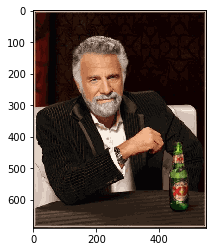

In [28]:
N = X.shape[0]

# x_true: real value of pixel. Dataset 
x_true = X

# X_r: value which predict from mixture
# that is the value of mean "m" which corresponding posterior distribution "g_znk" is the maximum
image_new =  np.zeros((all_pixels, channels))


for n in range(N):
    image_new[n] = m[g_znk[n].argmax()]


image_new = image_new.reshape((height, width, 3))
save_image = m.shape[0]

plt.imshow(image_new)
plt.savefig('compressed_image_{}'.format(save_image))

x_r = image_new.reshape((all_pixels, 3))

In [29]:
# Calculate error reconstructing the image
error = (1/N) * np.sum( np.linalg.norm(x_true - x_r)**2 )

print("Error reconstructing the image: "+ str(error))

Error reconstructing the image: 0.0009942493280429945


>Ο ιδιος κώδικας με πάνω ξαναγραμμένος(από το run algorithm και κάτω) μέσα σε for loop για να τρέχει έναν πινακα από K clusters-ομαδες και να εμφανίζει όλες τις συμπιεσμένες φωτογραφίες μαζί, αφου τις δημιουργείση
(Πανω το τρέχαμε μόνο για Κ = 64)

K: number of cluster: 1
STEP 1:INITIALIZATIONS PARAMETER:
Prior probabilities: [1.0]
Means: [[ 1.10049515 -0.01462963  1.72639515]]
Covariance: [0.66485748]
[[0.00687331]
 [0.00719474]
 [0.00908437]
 ...
 [0.00813206]
 [0.00813206]
 [0.00813206]]
!Time t=0!
Expectation Step
γ(Znk):[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Maximization Step
Means: [[0.2530868  0.18409021 0.15108827]]
Covariance: [0.05824629]
Prior probabilities:[1.]
Check for Convergence subtraction of logarithmic likelihoods is:1791143.8716318219
!Time t=1!
Expectation Step
γ(Znk):[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Maximization Step
Means: [[0.2530868  0.18409021 0.15108827]]
Covariance: [0.05824629]
Prior probabilities:[1.]
Check for Convergence subtraction of logarithmic likelihoods is:0.0
!!!Algorithm Convergence and Finish!!!
Error reconstructing the image: 0.17473886870077263
K: number of cluster: 4
STEP 1:INITIALIZATIONS PARAMETER:
Prior probabilities: [0.25, 0.25, 0.25, 0.25]
Means: [[ 1.10220201 -0.34736

Means: [[0.80882648 0.6613568  0.56817373]
 [0.92337926 0.86842202 0.82409437]
 [0.39738341 0.28294408 0.2132475 ]
 [0.1027628  0.05661029 0.04248787]]
Covariance: [0.00979367 0.00396261 0.01758421 0.00217788]
Prior probabilities:[0.10923503 0.02860496 0.16877097 0.69338903]
Check for Convergence subtraction of logarithmic likelihoods is:12508.379971635994
!Time t=9!
Expectation Step
γ(Znk):[[1.38104637e-025 4.11696737e-107 5.39310886e-003 9.94606891e-001]
 [1.40176506e-024 5.68101378e-104 9.71770678e-003 9.90282293e-001]
 [8.43620293e-019 2.84661321e-087 7.95885292e-001 2.04114708e-001]
 ...
 [1.22048395e-021 6.21314299e-092 1.40643016e-002 9.85935698e-001]
 [1.22048395e-021 6.21314299e-092 1.40643016e-002 9.85935698e-001]
 [1.22048395e-021 6.21314299e-092 1.40643016e-002 9.85935698e-001]]
Maximization Step
Means: [[0.79867623 0.64569906 0.549062  ]
 [0.91608001 0.85982654 0.8154984 ]
 [0.36922722 0.26125538 0.19662539]
 [0.10057195 0.05502655 0.04130822]]
Covariance: [0.01081538 0.00

Means: [[0.65179338 0.48859133 0.38007716]
 [0.8682664  0.78156427 0.72435998]
 [0.2177468  0.14523776 0.10859927]
 [0.0793244  0.03772098 0.02862626]]
Covariance: [0.01839708 0.00728681 0.00382156 0.0009431 ]
Prior probabilities:[0.12811744 0.08093451 0.26416608 0.52678197]
Check for Convergence subtraction of logarithmic likelihoods is:3612.453326765448
!Time t=20!
Expectation Step
γ(Znk):[[5.13009165e-07 1.73543296e-46 9.67438010e-01 3.25614765e-02]
 [5.71278327e-07 2.70049256e-45 9.94412216e-01 5.58721304e-03]
 [3.76848629e-06 1.27845458e-38 9.99996230e-01 1.48192113e-09]
 ...
 [3.75335850e-07 9.81556126e-41 9.99626240e-01 3.73384861e-04]
 [3.75335850e-07 9.81556126e-41 9.99626240e-01 3.73384861e-04]
 [3.75335850e-07 9.81556126e-41 9.99626240e-01 3.73384861e-04]]
Maximization Step
Means: [[0.64054819 0.47920435 0.37194211]
 [0.86744745 0.77757423 0.71828497]
 [0.21340938 0.14219985 0.10628995]
 [0.07858718 0.03693443 0.02803961]]
Covariance: [0.01874014 0.00766223 0.00365123 0.0009

Means: [[0.52082822 0.38038691 0.28964846]
 [0.85059309 0.73474141 0.65893503]
 [0.18212604 0.1210524  0.09018807]
 [0.07411454 0.0318283  0.0242165 ]]
Covariance: [0.01928488 0.0118445  0.00227985 0.00074641]
Prior probabilities:[0.13111092 0.11548469 0.28452362 0.46888076]
Check for Convergence subtraction of logarithmic likelihoods is:1816.0435368709732
!Time t=31!
Expectation Step
γ(Znk):[[7.51852075e-04 2.81191153e-25 9.97589260e-01 1.65888772e-03]
 [5.80969317e-04 8.94214029e-25 9.99269852e-01 1.49178731e-04]
 [2.18946905e-03 5.07369490e-21 9.97810531e-01 7.00658734e-13]
 ...
 [5.72033299e-05 2.54578054e-23 9.99941379e-01 1.41720034e-06]
 [5.72033299e-05 2.54578054e-23 9.99941379e-01 1.41720034e-06]
 [5.72033299e-05 2.54578054e-23 9.99941379e-01 1.41720034e-06]]
Maximization Step
Means: [[0.51044916 0.37174485 0.28260558]
 [0.84826356 0.73037074 0.6532974 ]
 [0.17997918 0.11980081 0.08928689]
 [0.07378374 0.0314288  0.0239169 ]]
Covariance: [0.01894167 0.01231452 0.00220687 0.000

Means: [[0.42943779 0.30721591 0.23163122]
 [0.82341659 0.69147575 0.60578765]
 [0.16805495 0.11275811 0.08417369]
 [0.07174602 0.02894246 0.02206456]]
Covariance: [0.01387325 0.01697596 0.00187864 0.00066607]
Prior probabilities:[0.11816736 0.14723099 0.29492678 0.43967487]
Check for Convergence subtraction of logarithmic likelihoods is:735.5158035208005
!Time t=42!
Expectation Step
γ(Znk):[[5.60288376e-03 1.49738262e-15 9.94056388e-01 3.40728474e-04]
 [4.49190108e-03 2.37935238e-15 9.95485909e-01 2.21894948e-05]
 [3.35708325e-02 7.49353719e-13 9.66429168e-01 1.12709909e-14]
 ...
 [3.16449031e-04 2.56443584e-15 9.99683481e-01 6.95375963e-08]
 [3.16449031e-04 2.56443584e-15 9.99683481e-01 6.95375963e-08]
 [3.16449031e-04 2.56443584e-15 9.99683481e-01 6.95375963e-08]]
Maximization Step
Means: [[0.42230849 0.30173232 0.22740904]
 [0.82076687 0.68791332 0.60167342]
 [0.16733561 0.11231212 0.08384462]
 [0.07162773 0.0287983  0.02195783]]
Covariance: [0.01328783 0.01744131 0.00185979 0.0006

Means: [[0.37292937 0.26304977 0.19742398]
 [0.80068819 0.66395497 0.57539131]
 [0.16139605 0.10857534 0.08106457]
 [0.07070236 0.02767299 0.02112672]]
Covariance: [0.00934986 0.02096486 0.00170749 0.00063324]
Prior probabilities:[0.11059326 0.16732772 0.29564687 0.42643215]
Check for Convergence subtraction of logarithmic likelihoods is:158.23206663504243
!Time t=53!
Expectation Step
γ(Znk):[[1.00667059e-02 1.52970763e-11 9.89767658e-01 1.65636358e-04]
 [9.31975148e-03 1.82950594e-11 9.90670942e-01 9.30673137e-06]
 [1.51187649e-01 1.76206337e-09 8.48812349e-01 1.60370541e-15]
 ...
 [8.73865015e-04 4.95645840e-12 9.99126118e-01 1.69033597e-08]
 [8.73865015e-04 4.95645840e-12 9.99126118e-01 1.69033597e-08]
 [8.73865015e-04 4.95645840e-12 9.99126118e-01 1.69033597e-08]]
Maximization Step
Means: [[0.37041926 0.26101084 0.19585814]
 [0.79962133 0.66280923 0.57417903]
 [0.16094607 0.10829295 0.08085351]
 [0.0706278  0.02758275 0.02106039]]
Covariance: [0.00918717 0.02115986 0.00169742 0.000

Means: [[0.35591947 0.24907641 0.18680157]
 [0.79369867 0.65658581 0.56760815]
 [0.1577819  0.10631509 0.0793724 ]
 [0.07007341 0.02691492 0.02057128]]
Covariance: [0.00837566 0.02226734 0.00163271 0.0006142 ]
Prior probabilities:[0.11250516 0.17251964 0.2966037  0.41837151]
Check for Convergence subtraction of logarithmic likelihoods is:21.71654728334397
!Time t=64!
Expectation Step
γ(Znk):[[1.52741938e-02 1.36833441e-10 9.84624740e-01 1.01065799e-04]
 [1.48029805e-02 1.54842548e-10 9.85191802e-01 5.21744723e-06]
 [2.86925884e-01 1.15646123e-08 7.13074105e-01 4.14650242e-16]
 ...
 [1.43524601e-03 2.92285706e-11 9.98564747e-01 7.11023295e-09]
 [1.43524601e-03 2.92285706e-11 9.98564747e-01 7.11023295e-09]
 [1.43524601e-03 2.92285706e-11 9.98564747e-01 7.11023295e-09]]
Maximization Step
Means: [[0.35508167 0.24837912 0.1862771 ]
 [0.79337214 0.65624902 0.5672533 ]
 [0.15756889 0.10618221 0.07927269]
 [0.0700348  0.02686863 0.02053748]]
Covariance: [0.00833517 0.02232946 0.00162862 0.0006

Means: [[0.34938794 0.24361966 0.1827065 ]
 [0.79119825 0.65402348 0.56491076]
 [0.15604996 0.10523686 0.07856288]
 [0.06975966 0.02653929 0.02029731]]
Covariance: [0.00807587 0.02274485 0.00159959 0.0006049 ]
Prior probabilities:[0.11420338 0.1743061  0.29715383 0.41433668]
Check for Convergence subtraction of logarithmic likelihoods is:4.917632086435333
!Time t=75!
Expectation Step
γ(Znk):[[1.91208765e-02 2.86729587e-10 9.80801061e-01 7.80617464e-05]
 [1.88168609e-02 3.19816201e-10 9.81179276e-01 3.86320215e-06]
 [3.71487897e-01 2.15570154e-08 6.28512081e-01 1.99141683e-16]
 ...
 [1.80774581e-03 5.31513982e-11 9.98192250e-01 4.58538767e-09]
 [1.80774581e-03 5.31513982e-11 9.98192250e-01 4.58538767e-09]
 [1.80774581e-03 5.31513982e-11 9.98192250e-01 4.58538767e-09]]
Maximization Step
Means: [[0.34900225 0.24329603 0.18246423]
 [0.79105352 0.65387631 0.56475601]
 [0.15594337 0.10517076 0.07851322]
 [0.06974052 0.0265164  0.02028063]]
Covariance: [0.0080592  0.02277261 0.00159755 0.0006

Means: [[0.34617699 0.24092112 0.18068812]
 [0.79000086 0.6528096  0.56363486]
 [0.15515288 0.10468189 0.07814595]
 [0.06960005 0.02634843 0.02015827]]
Covariance: [0.00793989 0.02297478 0.00158224 0.00060022]
Prior probabilities:[0.11523139 0.17514998 0.29733925 0.41227938]
Check for Convergence subtraction of logarithmic likelihoods is:1.4122049482539296
!Time t=86!
Expectation Step
γ(Znk):[[2.16483805e-02 4.06295638e-10 9.78283114e-01 6.85050993e-05]
 [2.14486148e-02 4.50363743e-10 9.78548068e-01 3.31704460e-06]
 [4.20093734e-01 2.86097322e-08 5.79906237e-01 1.35051649e-16]
 ...
 [2.03953691e-03 7.03253345e-11 9.97960459e-01 3.66084696e-09]
 [2.03953691e-03 7.03253345e-11 9.97960459e-01 3.66084696e-09]
 [2.03953691e-03 7.03253345e-11 9.97960459e-01 3.66084696e-09]]
Maximization Step
Means: [[0.34597209 0.2407486  0.18055922]
 [0.78992497 0.65273294 0.56355432]
 [0.15509499 0.1046462  0.07811914]
 [0.06958989 0.02633628 0.02014942]]
Covariance: [0.00793141 0.02298938 0.00158111 0.000

Means: [[0.34441599 0.23943724 0.17957989]
 [0.78935021 0.65215342 0.56294562]
 [0.15465341 0.10437452 0.07791504]
 [0.06951301 0.0262443  0.02008242]]
Covariance: [0.00786772 0.02309999 0.0015724  0.00059768]
Prior probabilities:[0.11584491 0.17560559 0.29739391 0.41115559]
Check for Convergence subtraction of logarithmic likelihoods is:0.46110406052321196
!Time t=97!
Expectation Step
γ(Znk):[[2.32602054e-02 4.90488983e-10 9.76675941e-01 6.38527725e-05]
 [2.31252182e-02 5.41894328e-10 9.76871727e-01 3.05473819e-06]
 [4.48433763e-01 3.31984134e-08 5.51566204e-01 1.08751083e-16]
 ...
 [2.18280263e-03 8.17424875e-11 9.97817194e-01 3.23588924e-09]
 [2.18280263e-03 8.17424875e-11 9.97817194e-01 3.23588924e-09]
 [2.18280263e-03 8.17424875e-11 9.97817194e-01 3.23588924e-09]]
Maximization Step
Means: [[0.34429928 0.2393388  0.17950641]
 [0.78930721 0.65211014 0.56290017]
 [0.15462016 0.10435411 0.0778997 ]
 [0.06950727 0.02623743 0.02007742]]
Covariance: [0.00786299 0.02310827 0.00157174 0.00

Means: [[0.34339533 0.23857605 0.17893722]
 [0.78897465 0.65177573 0.56254904]
 [0.15436207 0.10419585 0.07778081]
 [0.06946295 0.02618438 0.02003877]]
Covariance: [0.00782657 0.02317235 0.00156659 0.00059623]
Prior probabilities:[0.11621606 0.17586768 0.29740772 0.41050854]
Check for Convergence subtraction of logarithmic likelihoods is:0.1620486460160464
!Time t=108!
Expectation Step
γ(Znk):[[2.42772678e-02 5.46657506e-10 9.75661387e-01 6.13446202e-05]
 [2.41826444e-02 6.02805752e-10 9.75814441e-01 2.91431882e-06]
 [4.65328184e-01 3.61113682e-08 5.34671780e-01 9.58527530e-17]
 ...
 [2.27157606e-03 8.91103232e-11 9.97728421e-01 3.01363934e-09]
 [2.27157606e-03 8.91103232e-11 9.97728421e-01 3.01363934e-09]
 [2.27157606e-03 8.91103232e-11 9.97728421e-01 3.01363934e-09]]
Maximization Step
Means: [[0.34332626 0.23851774 0.17889372]
 [0.78894927 0.65175024 0.56252228]
 [0.15434231 0.10418374 0.07777172]
 [0.06945957 0.02618033 0.02003583]]
Covariance: [0.0078238  0.02317724 0.00156619 0.00

Means: [[0.3427851  0.23806079 0.17855287]
 [0.7887506  0.65155079 0.56231289]
 [0.15418728 0.10408886 0.07770045]
 [0.06943317 0.02614872 0.0200128 ]]
Covariance: [0.00780218 0.02321553 0.00156308 0.00059536]
Prior probabilities:[0.11644337 0.17602372 0.29740951 0.4101234 ]
Check for Convergence subtraction of logarithmic likelihoods is:0.0594855179078877
!Time t=119!
Expectation Step
γ(Znk):[[2.49164996e-02 5.83130148e-10 9.75023592e-01 5.99081570e-05]
 [2.48470948e-02 6.42299984e-10 9.75150070e-01 2.83422119e-06]
 [4.75575634e-01 3.79452706e-08 5.24424328e-01 8.88640043e-17]
 ...
 [2.32677647e-03 9.38010253e-11 9.97673221e-01 2.88856594e-09]
 [2.32677647e-03 9.38010253e-11 9.97673221e-01 2.88856594e-09]
 [2.32677647e-03 9.38010253e-11 9.97673221e-01 2.88856594e-09]]
Maximization Step
Means: [[0.3427433  0.23802548 0.17852654]
 [0.78873526 0.6515354  0.56229673]
 [0.15417529 0.10408153 0.07769494]
 [0.06943113 0.02614628 0.02001102]]
Covariance: [0.00780051 0.02321849 0.00156284 0.00

Means: [[0.34241349 0.23774688 0.17831878]
 [0.78861433 0.65141411 0.56216941]
 [0.15408061 0.10402365 0.07765147]
 [0.06941509 0.02612706 0.01999702]]
Covariance: [0.0077874  0.02324181 0.00156093 0.00059483]
Prior probabilities:[0.11658378 0.17611851 0.29740822 0.40988949]
Check for Convergence subtraction of logarithmic likelihoods is:0.02241930947639048
!Time t=130!
Expectation Step
γ(Znk):[[2.53176800e-02 6.06473147e-10 9.74623264e-01 5.90556392e-05]
 [2.52640572e-02 6.67554485e-10 9.74733155e-01 2.78679852e-06]
 [4.81865824e-01 3.90966085e-08 5.18134137e-01 8.48527256e-17]
 ...
 [2.36119815e-03 9.67674584e-11 9.97638799e-01 2.81511648e-09]
 [2.36119815e-03 9.67674584e-11 9.97638799e-01 2.81511648e-09]
 [2.36119815e-03 9.67674584e-11 9.97638799e-01 2.81511648e-09]]
Maximization Step
Means: [[0.34238784 0.23772522 0.17830263]
 [0.78860493 0.65140468 0.56215952]
 [0.15407324 0.10401915 0.07764809]
 [0.06941384 0.02612557 0.01999593]]
Covariance: [0.00778639 0.02324362 0.00156078 0.0

Means: [[0.34218464 0.23755353 0.17817461]
 [0.78853048 0.65133005 0.56208118]
 [0.15401483 0.10398347 0.07762129]
 [0.06940398 0.02611375 0.01998732]]
Covariance: [0.00777833 0.02325798 0.0015596  0.00059451]
Prior probabilities:[0.11667099 0.1761768  0.29740654 0.40974567]
Check for Convergence subtraction of logarithmic likelihoods is:0.008587179007008672
!Time t=141!
Expectation Step
γ(Znk):[[2.55693321e-02 6.21291895e-10 9.74372129e-01 5.85387979e-05]
 [2.55255946e-02 6.83578054e-10 9.74471647e-01 2.75809045e-06]
 [4.85757244e-01 3.98187818e-08 5.14242716e-01 8.24702364e-17]
 ...
 [2.38270577e-03 9.86368710e-11 9.97617291e-01 2.77087498e-09]
 [2.38270577e-03 9.86368710e-11 9.97617291e-01 2.77087498e-09]
 [2.38270577e-03 9.86368710e-11 9.97617291e-01 2.77087498e-09]]
Maximization Step
Means: [[0.34216878 0.23754012 0.17816462]
 [0.78852466 0.65132423 0.56207507]
 [0.15401027 0.10398069 0.0776192 ]
 [0.06940321 0.02611283 0.01998665]]
Covariance: [0.00777771 0.02325911 0.00155951 0.

Means: [[0.11250883 0.05847188 0.04369317]
 [0.387803   0.44224662 0.22767725]
 [0.60379018 0.52360099 0.43490588]
 [0.19884814 0.13353381 0.10570314]
 [0.87336421 0.78063671 0.67566688]
 [0.20691861 0.14376513 0.11541078]
 [0.39972863 0.31483256 0.26717226]
 [0.96266747 0.93122903 0.89222634]]
Covariance: [0.00514547 0.0427692  0.0670574  0.03569157 0.01544424 0.03954414
 0.09382806 0.00476722]
Prior probabilities:[2.31992314e-02 5.02618063e-10 2.78028912e-03 2.21260131e-01
 2.28055460e-05 4.98469231e-01 2.54268311e-01 5.02456519e-16]
Check for Convergence subtraction of logarithmic likelihoods is:1880399.0473634736
!Time t=1!
Expectation Step
γ(Znk):[[1.78899233e-001 2.72830877e-011 2.00154239e-005 ... 5.13018453e-001
  3.67553400e-002 6.81522139e-116]
 [1.64038137e-001 3.24950702e-011 2.39824157e-005 ... 5.22016981e-001
  3.83052595e-002 3.55344551e-113]
 [3.31775773e-002 8.79431553e-011 7.11145542e-005 ... 6.02017709e-001
  5.56076709e-002 3.17709569e-099]
 ...
 [1.86787728e-001 6.

Check for Convergence subtraction of logarithmic likelihoods is:9599.163214101223
!Time t=7!
Expectation Step
γ(Znk):[[9.09253613e-003 9.37923159e-113 1.65073831e-030 ... 9.75324434e-001
  2.28844549e-007 0.00000000e+000]
 [7.60556533e-004 1.58995264e-103 8.79556057e-030 ... 9.70141485e-001
  2.69428001e-007 0.00000000e+000]
 [3.88577135e-013 3.09432263e-061 1.33057547e-025 ... 9.98462769e-001
  1.72255538e-006 0.00000000e+000]
 ...
 [5.31241387e-007 1.25193461e-068 1.27658308e-028 ... 2.49058440e-002
  1.01040541e-008 0.00000000e+000]
 [5.31241387e-007 1.25193461e-068 1.27658308e-028 ... 2.49058440e-002
  1.01040541e-008 0.00000000e+000]
 [5.31241387e-007 1.25193461e-068 1.27658308e-028 ... 2.49058440e-002
  1.01040541e-008 0.00000000e+000]]
Maximization Step
Means: [[0.07313773 0.02990988 0.02254824]
 [0.39972252 0.31857181 0.26952248]
 [0.85131009 0.70493348 0.61102549]
 [0.14864033 0.10730379 0.08110544]
 [0.84517336 0.77753286 0.73382331]
 [0.27830933 0.17907118 0.13368831]
 [0.63

Means: [[0.06957023 0.02574415 0.01956054]
 [0.38645031 0.301867   0.24948739]
 [0.82273904 0.64639314 0.53388421]
 [0.13693529 0.09679663 0.07276789]
 [0.84494386 0.77632438 0.7325206 ]
 [0.25954838 0.16412013 0.12071488]
 [0.62365583 0.45895348 0.34660616]
 [0.97046739 0.9255274  0.88330073]]
Covariance: [0.00059265 0.00130114 0.00611691 0.00097778 0.00120907 0.00374269
 0.01038316 0.00169528]
Prior probabilities:[0.40844566 0.02455625 0.06110198 0.23637514 0.04542925 0.13853754
 0.07158819 0.01396599]
Check for Convergence subtraction of logarithmic likelihoods is:4103.433915169677
!Time t=14!
Expectation Step
γ(Znk):[[2.30328934e-004 5.39839973e-029 4.03111291e-037 ... 8.76817218e-001
  1.16545430e-009 4.09166844e-282]
 [8.87693596e-006 1.22282701e-026 4.57348869e-036 ... 8.83599909e-001
  1.69924930e-009 7.41763821e-275]
 [1.30912121e-017 1.43426578e-015 4.34014359e-030 ... 9.99528394e-001
  4.56840546e-008 4.30999603e-237]
 ...
 [4.05279889e-009 3.13014220e-018 2.01975749e-033 ..

Check for Convergence subtraction of logarithmic likelihoods is:2856.9548638770357
!Time t=20!
Expectation Step
γ(Znk):[[9.08716578e-006 4.26585851e-015 3.54926083e-033 ... 9.77035440e-001
  9.07080148e-009 1.23769562e-235]
 [1.81037491e-007 6.95660085e-014 2.55723976e-032 ... 9.85924649e-001
  1.05162138e-008 1.16603084e-229]
 [3.15643429e-021 6.92647019e-008 5.03376953e-027 ... 9.99996834e-001
  1.81242900e-007 3.88171611e-198]
 ...
 [8.11612762e-011 2.79496297e-009 9.63904899e-030 ... 6.25884236e-001
  5.95499223e-009 2.99807828e-205]
 [8.11612762e-011 2.79496297e-009 9.63904899e-030 ... 6.25884236e-001
  5.95499223e-009 2.99807828e-205]
 [8.11612762e-011 2.79496297e-009 9.63904899e-030 ... 6.25884236e-001
  5.95499223e-009 2.99807828e-205]]
Maximization Step
Means: [[0.06646988 0.02197337 0.01684394]
 [0.35210327 0.26915364 0.21418101]
 [0.81451689 0.63251436 0.51651037]
 [0.12042051 0.08452452 0.06376912]
 [0.84106738 0.77182252 0.72804321]
 [0.22613882 0.13994926 0.10227818]
 [0.

Means: [[0.06403472 0.01924225 0.01494103]
 [0.34046126 0.25797519 0.20352544]
 [0.80936352 0.62633945 0.50983884]
 [0.11128783 0.07632719 0.05775686]
 [0.84016131 0.77078992 0.72702412]
 [0.2122852  0.13246811 0.09685284]
 [0.58082562 0.4264891  0.32055598]
 [0.96354239 0.91622878 0.8731874 ]]
Covariance: [0.00044998 0.00195991 0.00701353 0.00070254 0.00116889 0.00214344
 0.01097256 0.00213411]
Prior probabilities:[0.33444276 0.05012628 0.07073644 0.23475878 0.04609069 0.1812004
 0.06687427 0.01577038]
Check for Convergence subtraction of logarithmic likelihoods is:766.6032484252937
!Time t=27!
Expectation Step
γ(Znk):[[1.55351413e-007 2.68255094e-012 1.97015468e-030 ... 9.95895726e-001
  7.95901307e-008 1.46133737e-219]
 [1.57369372e-009 2.60849667e-011 1.09633929e-029 ... 9.98322931e-001
  8.08351020e-008 5.03159888e-214]
 [1.61413809e-025 3.52306436e-006 9.93981765e-025 ... 9.99995252e-001
  1.20770057e-006 1.66346939e-184]
 ...
 [1.86990822e-013 1.55754746e-007 1.79986179e-027 ...

Check for Convergence subtraction of logarithmic likelihoods is:267.6848339845892
!Time t=33!
Expectation Step
γ(Znk):[[7.84758574e-009 8.21240047e-012 7.65617644e-029 ... 9.95493323e-001
  3.56772448e-007 1.10353866e-214]
 [4.91439259e-011 7.63068510e-011 3.73062708e-028 ... 9.98504289e-001
  3.37332476e-007 2.81806959e-209]
 [1.01655293e-028 9.05244182e-006 2.06344339e-023 ... 9.99986757e-001
  4.18483369e-006 2.41265107e-180]
 ...
 [2.04600512e-015 3.44131965e-007 3.31216467e-026 ... 9.88819588e-001
  9.42450264e-008 3.27983508e-187]
 [2.04600512e-015 3.44131965e-007 3.31216467e-026 ... 9.88819588e-001
  9.42450264e-008 3.27983508e-187]
 [2.04600512e-015 3.44131965e-007 3.31216467e-026 ... 9.88819588e-001
  9.42450264e-008 3.27983508e-187]]
Maximization Step
Means: [[0.06177143 0.01718838 0.01362276]
 [0.33339201 0.25159981 0.19819297]
 [0.80488725 0.62128535 0.50453914]
 [0.10710994 0.07107213 0.05356777]
 [0.83970224 0.7702252  0.72644598]
 [0.20596164 0.12954758 0.09489793]
 [0.5

Means: [[0.06047876 0.01614848 0.01298748]
 [0.32927845 0.2485005  0.19608405]
 [0.80156076 0.61766181 0.50080444]
 [0.10549016 0.06860594 0.05153212]
 [0.8395155  0.76995844 0.72615545]
 [0.203498   0.12862416 0.09436654]
 [0.55508491 0.40546261 0.30327382]
 [0.96248734 0.91486673 0.87172703]]
Covariance: [0.00038179 0.00179192 0.00755951 0.00069969 0.00116865 0.00195933
 0.01170858 0.00219674]
Prior probabilities:[0.29369795 0.0506903  0.07627869 0.25781081 0.04619257 0.19299432
 0.06628702 0.01604833]
Check for Convergence subtraction of logarithmic likelihoods is:103.6719122719951
!Time t=40!
Expectation Step
γ(Znk):[[6.47265246e-010 3.06646312e-012 2.43738338e-027 ... 9.93212319e-001
  1.80158475e-006 1.28290420e-212]
 [2.68171893e-012 3.36693364e-011 1.04176565e-026 ... 9.98038843e-001
  1.56759512e-006 2.86299870e-207]
 [1.93971297e-031 8.34598312e-006 3.33743016e-022 ... 9.99977299e-001
  1.43510570e-005 1.38176852e-178]
 ...
 [4.67908761e-017 2.84059820e-007 5.17814130e-025 ..

Check for Convergence subtraction of logarithmic likelihoods is:54.42583934520371
!Time t=46!
Expectation Step
γ(Znk):[[1.70112537e-010 5.27841072e-013 3.65624295e-026 ... 9.91433988e-001
  5.94678434e-006 3.26399624e-212]
 [5.61087044e-013 7.33288894e-012 1.40869914e-025 ... 9.97689780e-001
  4.86530185e-006 7.04454052e-207]
 [6.50922785e-033 4.96215164e-006 2.86093636e-021 ... 9.99960152e-001
  3.48817567e-005 3.06716653e-178]
 ...
 [6.00276337e-018 1.59628086e-007 4.51375557e-024 ... 9.95104680e-001
  6.94024336e-007 3.47089604e-185]
 [6.00276337e-018 1.59628086e-007 4.51375557e-024 ... 9.95104680e-001
  6.94024336e-007 3.47089604e-185]
 [6.00276337e-018 1.59628086e-007 4.51375557e-024 ... 9.95104680e-001
  6.94024336e-007 3.47089604e-185]]
Maximization Step
Means: [[0.05959018 0.01545767 0.01256996]
 [0.32550091 0.24604436 0.19477284]
 [0.79775737 0.61361818 0.49667024]
 [0.10444778 0.06699289 0.05020341]
 [0.83939867 0.76974714 0.72590736]
 [0.2018005  0.12809766 0.0941003 ]
 [0.5

Means: [[0.05916489 0.01513086 0.01237273]
 [0.32301387 0.24457052 0.19412287]
 [0.79462285 0.61034599 0.49333567]
 [0.10394656 0.06622492 0.04957303]
 [0.83934214 0.76960833 0.72573269]
 [0.20087877 0.1278584  0.09400146]
 [0.53268788 0.38669355 0.287724  ]
 [0.96248026 0.91486048 0.87172086]]
Covariance: [0.00035922 0.00152008 0.00804939 0.00070549 0.00118615 0.00188239
 0.01217356 0.00219743]
Prior probabilities:[0.27943413 0.04794381 0.08102815 0.26770006 0.04650595 0.19541061
 0.06592833 0.01604895]
Check for Convergence subtraction of logarithmic likelihoods is:28.929183695698157
!Time t=53!
Expectation Step
γ(Znk):[[6.93606360e-011 5.59132393e-014 6.39327770e-025 ... 9.89841905e-001
  1.75936011e-005 1.72245371e-212]
 [1.94700813e-013 1.03572241e-012 2.20600020e-024 ... 9.97388614e-001
  1.36224187e-005 3.74329257e-207]
 [6.35656633e-034 2.36775447e-006 2.72513605e-020 ... 9.99919470e-001
  7.81588505e-005 1.79180310e-178]
 ...
 [1.44871514e-018 7.35915400e-008 4.49695966e-023 .

Check for Convergence subtraction of logarithmic likelihoods is:17.554530733032152
!Time t=59!
Expectation Step
γ(Znk):[[4.55696748e-011 9.13507476e-015 5.05425500e-024 ... 9.88785921e-001
  3.51521379e-005 4.70825218e-213]
 [1.17878039e-013 2.12340216e-013 1.60951324e-023 ... 9.97186126e-001
  2.62951453e-005 1.05073875e-207]
 [2.06027348e-034 1.26320934e-006 1.37775799e-019 ... 9.99867676e-001
  1.31057586e-004 5.98332502e-179]
 ...
 [7.20832778e-019 3.87964523e-008 2.37632505e-022 ... 9.96307093e-001
  2.50671219e-006 5.46298787e-186]
 [7.20832778e-019 3.87964523e-008 2.37632505e-022 ... 9.96307093e-001
  2.50671219e-006 5.46298787e-186]
 [7.20832778e-019 3.87964523e-008 2.37632505e-022 ... 9.96307093e-001
  2.50671219e-006 5.46298787e-186]]
Maximization Step
Means: [[0.05888768 0.01491914 0.01224502]
 [0.32086726 0.24340782 0.19369057]
 [0.7913746  0.6070113  0.48994908]
 [0.10361861 0.06572202 0.04915981]
 [0.8393081  0.76948407 0.72556676]
 [0.20019164 0.12771817 0.09396819]
 [0.

Means: [[0.05875496 0.01481843 0.01218436]
 [0.31952344 0.24274584 0.19348672]
 [0.78907136 0.60468501 0.48759749]
 [0.10346338 0.06548012 0.04895992]
 [0.83929788 0.76940677 0.72545721]
 [0.19981302 0.12766722 0.0939774 ]
 [0.51615738 0.37289159 0.27639761]
 [0.96270607 0.91515454 0.87203656]]
Covariance: [0.00035234 0.00134802 0.00844358 0.00070705 0.00120585 0.00184104
 0.01225864 0.0021844 ]
Prior probabilities:[0.27499092 0.04565579 0.0847275  0.27072477 0.04682798 0.1959251
 0.06516009 0.01598786]
Check for Convergence subtraction of logarithmic likelihoods is:9.73677712958306
!Time t=66!
Expectation Step
γ(Znk):[[3.50326879e-011 1.42197226e-015 3.39153522e-023 ... 9.87796017e-001
  6.38041474e-005 7.38037113e-214]
 [8.55822501e-014 4.15833698e-014 1.00244738e-022 ... 9.96988069e-001
  4.63481237e-005 1.71630256e-208]
 [9.80597431e-035 6.49349337e-007 6.08990192e-019 ... 9.99794578e-001
  2.04768967e-004 1.24681404e-179]
 ...
 [4.51372927e-019 1.98913129e-008 1.09985925e-021 ... 

Check for Convergence subtraction of logarithmic likelihoods is:5.655352952890098
!Time t=72!
Expectation Step
γ(Znk):[[3.11427510e-011 3.78207840e-016 1.15711169e-022 ... 9.87107628e-001
  9.26826668e-005 1.49131895e-214]
 [7.38419376e-014 1.30038813e-014 3.25798858e-022 ... 9.96844089e-001
  6.61035189e-005 3.59767122e-209]
 [6.85108264e-035 4.00705264e-007 1.58247515e-018 ... 9.99728775e-001
  2.70820377e-004 3.22034184e-180]
 ...
 [3.58146659e-019 1.23021044e-008 2.94773379e-021 ... 9.96653099e-001
  5.07280984e-006 2.46742360e-187]
 [3.58146659e-019 1.23021044e-008 2.94773379e-021 ... 9.96653099e-001
  5.07280984e-006 2.46742360e-187]
 [3.58146659e-019 1.23021044e-008 2.94773379e-021 ... 9.96653099e-001
  5.07280984e-006 2.46742360e-187]]
Maximization Step
Means: [[0.05866609 0.01475152 0.01214416]
 [0.31838351 0.24222469 0.19335024]
 [0.78697232 0.60259567 0.48549558]
 [0.10336202 0.06531749 0.04882431]
 [0.83929951 0.76934491 0.72536391]
 [0.19951975 0.1276479  0.09400532]
 [0.5

Means: [[0.05862159 0.01471831 0.01212429]
 [0.3176844  0.24191877 0.19327612]
 [0.78563083 0.60127684 0.4841745 ]
 [0.10331286 0.06523562 0.04875526]
 [0.83930693 0.76931046 0.72530819]
 [0.19934873 0.12764584 0.09403105]
 [0.5061948  0.36449764 0.26956658]
 [0.96293307 0.91544983 0.87235361]]
Covariance: [0.00035013 0.00125335 0.00868746 0.00070771 0.00122037 0.00181811
 0.01223079 0.00217115]
Prior probabilities:[0.27355176 0.04420939 0.08696162 0.27173373 0.04705521 0.19590385
 0.06465752 0.01592692]
Check for Convergence subtraction of logarithmic likelihoods is:2.820839920314029
!Time t=79!
Expectation Step
γ(Znk):[[2.89760775e-011 1.13516755e-016 3.27396574e-022 ... 9.86467965e-001
  1.26871714e-004 2.79529390e-215]
 [6.72163484e-014 4.51853237e-015 8.84278150e-022 ... 9.96705679e-001
  8.90978411e-005 7.01201095e-210]
 [5.37831002e-035 2.57370779e-007 3.54756323e-018 ... 9.99657204e-001
  3.42534862e-004 7.80686253e-181]
 ...
 [3.05085637e-019 7.93337523e-009 6.78223974e-021 ..

Check for Convergence subtraction of logarithmic likelihoods is:1.476356808329001
!Time t=85!
Expectation Step
γ(Znk):[[2.80475657e-011 5.32611302e-017 6.13346621e-022 ... 9.86047189e-001
  1.53373993e-004 8.46536234e-216]
 [6.42851217e-014 2.32419276e-015 1.61517264e-021 ... 9.96612448e-001
  1.06698229e-004 2.18421990e-210]
 [4.75860530e-035 1.94657391e-007 5.76955994e-018 ... 9.99605096e-001
  3.94705383e-004 2.84147728e-181]
 ...
 [2.80664352e-019 6.01953045e-009 1.11989081e-020 ... 9.96772944e-001
  7.29191028e-006 1.93007180e-188]
 [2.80664352e-019 6.01953045e-009 1.11989081e-020 ... 9.96772944e-001
  7.29191028e-006 1.93007180e-188]
 [2.80664352e-019 6.01953045e-009 1.11989081e-020 ... 9.96772944e-001
  7.29191028e-006 1.93007180e-188]]
Maximization Step
Means: [[0.05859006 0.01469497 0.01211038]
 [0.31710917 0.24167005 0.19321389]
 [0.78450462 0.60018001 0.48307943]
 [0.10327892 0.06517712 0.04870541]
 [0.83931792 0.76928538 0.7252644 ]
 [0.19920965 0.12764801 0.09405596]
 [0.5

Means: [[0.05857322 0.01468259 0.01210302]
 [0.31676803 0.24152149 0.19317315]
 [0.78383133 0.59952889 0.48243097]
 [0.10326105 0.06514552 0.04867827]
 [0.8393271  0.76927251 0.72523989]
 [0.19912617 0.12764991 0.09407155]
 [0.50102955 0.36010115 0.26600566]
 [0.9630888  0.91565247 0.87257124]]
Covariance: [0.00034934 0.00120724 0.0088148  0.00070802 0.00122892 0.00180576
 0.01219986 0.00216201]
Prior probabilities:[0.27303317 0.04345606 0.08810694 0.27210892 0.04718563 0.1958023
 0.06442169 0.01588527]
Check for Convergence subtraction of logarithmic likelihoods is:0.6608921659644693
!Time t=92!
Expectation Step
γ(Znk):[[2.74642302e-011 2.86753388e-017 1.01678365e-021 ... 9.85684602e-001
  1.78812055e-004 2.83106249e-216]
 [6.23715987e-014 1.34912885e-015 2.62311378e-021 ... 9.96530924e-001
  1.23440339e-004 7.49733788e-211]
 [4.35849989e-035 1.54914347e-007 8.53114859e-018 ... 9.99557223e-001
  4.42618852e-004 1.12519168e-181]
 ...
 [2.63963415e-019 4.80445141e-009 1.67534531e-020 ..

Check for Convergence subtraction of logarithmic likelihoods is:0.32179656554944813
!Time t=98!
Expectation Step
γ(Znk):[[2.71785945e-011 2.00187131e-017 1.36294899e-021 ... 9.85463171e-001
  1.95547101e-004 1.39776554e-216]
 [6.14015848e-014 9.83969244e-016 3.47427868e-021 ... 9.96480687e-001
  1.34382960e-004 3.76462764e-211]
 [4.15597968e-035 1.35730878e-007 1.07004316e-017 ... 9.99526688e-001
  4.73172554e-004 6.19582019e-182]
 ...
 [2.55170335e-019 4.21694991e-009 2.11486812e-020 ... 9.96822288e-001
  8.66601408e-006 3.92212329e-189]
 [2.55170335e-019 4.21694991e-009 2.11486812e-020 ... 9.96822288e-001
  8.66601408e-006 3.92212329e-189]
 [2.55170335e-019 4.21694991e-009 2.11486812e-020 ... 9.96822288e-001
  8.66601408e-006 3.92212329e-189]]
Maximization Step
Means: [[0.05856053 0.0146733  0.01209751]
 [0.31649554 0.24140085 0.19313654]
 [0.78329344 0.59901121 0.48191627]
 [0.10324759 0.06512144 0.04865749]
 [0.83933624 0.76926371 0.72522148]
 [0.19905788 0.12765101 0.09408389]
 [0

Means: [[0.05855339 0.01466808 0.01209441]
 [0.31633794 0.24132973 0.19311293]
 [0.7829835  0.59871393 0.48162104]
 [0.10323993 0.06510773 0.04864565]
 [0.83934243 0.76925941 0.72521148]
 [0.19901728 0.12765116 0.09409072]
 [0.49860578 0.3580239  0.26432732]
 [0.96317649 0.91576663 0.87269386]]
Covariance: [0.00034902 0.00118673 0.00887472 0.00070816 0.00123331 0.0017996
 0.0121827  0.00215684]
Prior probabilities:[0.27282133 0.04311112 0.0886398  0.27226093 0.0472516  0.195733
 0.06432034 0.01586187]
Check for Convergence subtraction of logarithmic likelihoods is:0.13558621052652597
!Time t=105!
Expectation Step
γ(Znk):[[2.69727402e-011 1.51427606e-017 1.71412308e-021 ... 9.85283471e-001
  2.09805940e-004 7.67689940e-217]
 [6.06882640e-014 7.70087996e-016 4.32851298e-021 ... 9.96439723e-001
  1.43665249e-004 2.09761824e-211]
 [4.00779380e-035 1.22529295e-007 1.27749088e-017 ... 9.99501198e-001
  4.98675731e-004 3.73392860e-182]
 ...
 [2.48583439e-019 3.81213150e-009 2.53694758e-020 ..

Check for Convergence subtraction of logarithmic likelihoods is:0.06371337757445872
!Time t=111!
Expectation Step
γ(Znk):[[2.68581838e-011 1.29453473e-017 1.95245108e-021 ... 9.85178678e-001
  2.18403831e-004 5.33778500e-217]
 [6.02889212e-014 6.71080548e-016 4.90397409e-021 ... 9.96415779e-001
  1.49244929e-004 1.47132318e-211]
 [3.92581428e-035 1.15711377e-007 1.41270914e-017 ... 9.99486041e-001
  5.13839375e-004 2.74684209e-182]
 ...
 [2.44889581e-019 3.60286236e-009 2.81273136e-020 ... 9.96844748e-001
  9.36646707e-006 1.67660792e-189]
 [2.44889581e-019 3.60286236e-009 2.81273136e-020 ... 9.96844748e-001
  9.36646707e-006 1.67660792e-189]
 [2.44889581e-019 3.60286236e-009 2.81273136e-020 ... 9.96844748e-001
  9.36646707e-006 1.67660792e-189]]
Maximization Step
Means: [[0.05854781 0.014664   0.01209199]
 [0.31621446 0.24127303 0.19309274]
 [0.78274196 0.59848276 0.48139164]
 [0.10323386 0.06509693 0.04863632]
 [0.83934785 0.76925655 0.72520409]
 [0.19898462 0.12765083 0.09409576]
 [

Means: [[0.05854459 0.01466165 0.01209059]
 [0.31614412 0.24124022 0.1930804 ]
 [0.78260516 0.59835202 0.48126196]
 [0.10323031 0.06509066 0.04863091]
 [0.8393512  0.76925517 0.72520009]
 [0.19896556 0.12765038 0.09409845]
 [0.49752609 0.35709488 0.26357761]
 [0.96322044 0.91582384 0.87275532]]
Covariance: [0.00034888 0.00117794 0.00890143 0.00070821 0.00123538 0.00179673
 0.01217477 0.00215424]
Prior probabilities:[0.27272731 0.04296182 0.08887595 0.27232644 0.04728257 0.19569819
 0.06427757 0.01585016]
Check for Convergence subtraction of logarithmic likelihoods is:0.026111265644431114
!Time t=118!
Expectation Step
γ(Znk):[[2.67676748e-011 1.14856072e-017 2.15887779e-021 ... 9.85096298e-001
  2.25309152e-004 3.97474305e-217]
 [5.99750360e-014 6.04200742e-016 5.40001061e-021 ... 9.96396943e-001
  1.53717022e-004 1.10345188e-211]
 [3.86243937e-035 1.10782405e-007 1.52681292e-017 ... 9.99473976e-001
  5.25909811e-004 2.14132493e-182]
 ...
 [2.42016602e-019 3.45146999e-009 3.04574032e-02

Check for Convergence subtraction of logarithmic likelihoods is:0.012080319924280047
!Time t=124!
Expectation Step
γ(Znk):[[2.67143663e-011 1.07458337e-017 2.28450293e-021 ... 9.85049324e-001
  2.29303728e-004 3.34470942e-217]
 [5.97921667e-014 5.69923732e-016 5.70089504e-021 ... 9.96386205e-001
  1.56300367e-004 9.32437834e-212]
 [3.82620172e-035 1.08139750e-007 1.59503908e-017 ... 9.99467037e-001
  5.32850981e-004 1.85094833e-182]
 ...
 [2.40370746e-019 3.37025978e-009 3.18515102e-020 ... 9.96855190e-001
  9.69053925e-006 1.11030366e-189]
 [2.40370746e-019 3.37025978e-009 3.18515102e-020 ... 9.96855190e-001
  9.69053925e-006 1.11030366e-189]
 [2.40370746e-019 3.37025978e-009 3.18515102e-020 ... 9.96855190e-001
  9.69053925e-006 1.11030366e-189]]
Maximization Step
Means: [[0.05854205 0.01465978 0.01208949]
 [0.31608962 0.24121449 0.19307032]
 [0.78249971 0.59825133 0.48116213]
 [0.10322747 0.06508569 0.04862664]
 [0.83935396 0.76925425 0.72519713]
 [0.19895048 0.12764985 0.09410041]
 

Means: [[0.05854058 0.01465871 0.01208885]
 [0.31605882 0.2411998  0.19306439]
 [0.78244041 0.59819476 0.48110604]
 [0.10322581 0.06508281 0.04862416]
 [0.83935558 0.7692538  0.72519552]
 [0.19894182 0.12764946 0.09410144]
 [0.49705626 0.35668974 0.26325087]
 [0.96324099 0.9158506  0.87278407]]
Covariance: [0.00034881 0.00117422 0.00891305 0.00070823 0.00123632 0.00179545
 0.01217132 0.00215303]
Prior probabilities:[0.27268439 0.04289834 0.0889784  0.27235556 0.0472965  0.19568263
 0.0642595  0.01584468]
Check for Convergence subtraction of logarithmic likelihoods is:0.004892396507784724
!Time t=131!
Expectation Step
γ(Znk):[[2.66712067e-011 1.02154540e-017 2.38588571e-021 ... 9.85012933e-001
  2.32426088e-004 2.91820201e-217]
 [5.96459670e-014 5.45176344e-016 5.94320703e-021 ... 9.96377893e-001
  1.58317792e-004 8.16235933e-212]
 [3.79774181e-035 1.06178285e-007 1.64948570e-017 ... 9.99461634e-001
  5.38256743e-004 1.64959859e-182]
 ...
 [2.39079038e-019 3.30996048e-009 3.29643233e-02

Check for Convergence subtraction of logarithmic likelihoods is:0.002248602220788598
!Time t=137!
Expectation Step
γ(Znk):[[2.66456534e-011 9.93198154e-018 2.44469123e-021 ... 9.84992389e-001
  2.34198949e-004 2.69856489e-217]
 [5.95604864e-014 5.31887649e-016 6.08355647e-021 ... 9.96373205e-001
  1.59462558e-004 7.56240141e-212]
 [3.78137229e-035 1.05105752e-007 1.68082957e-017 ... 9.99458572e-001
  5.41318844e-004 1.54416116e-182]
 ...
 [2.38337524e-019 3.27697901e-009 3.36049831e-020 ... 9.96859984e-001
  9.83400516e-006 9.18978190e-190]
 [2.38337524e-019 3.27697901e-009 3.36049831e-020 ... 9.96859984e-001
  9.83400516e-006 9.18978190e-190]
 [2.38337524e-019 3.27697901e-009 3.36049831e-020 ... 9.96859984e-001
  9.83400516e-006 9.18978190e-190]]
Maximization Step
Means: [[0.05853942 0.01465785 0.01208834]
 [0.3160351  0.24118839 0.19305967]
 [0.78239491 0.59815136 0.48106302]
 [0.10322448 0.06508054 0.04862222]
 [0.83935688 0.7692535  0.72519431]
 [0.19893505 0.1276491  0.0941022 ]
 

Means: [[0.05853876 0.01465736 0.01208805]
 [0.31602176 0.24118193 0.19305695]
 [0.7823694  0.59812703 0.48103891]
 [0.10322372 0.06507924 0.0486211 ]
 [0.83935762 0.76925334 0.72519365]
 [0.19893119 0.12764887 0.09410261]
 [0.4968538  0.35651495 0.26310994]
 [0.96325024 0.91586263 0.87279699]]
Covariance: [0.00034878 0.00117264 0.00891805 0.00070824 0.00123674 0.00179488
 0.01216984 0.00215248]
Prior probabilities:[0.27266485 0.04287141 0.08902248 0.27236859 0.04730263 0.19567598
 0.06425184 0.01584222]
Check for Convergence subtraction of logarithmic likelihoods is:0.0009061296004801989
!Time t=144!
Expectation Step
γ(Znk):[[2.66250903e-011 9.72160033e-018 2.49071910e-021 ... 9.84976576e-001
  2.35568239e-004 2.53901035e-217]
 [5.94924518e-014 5.21996671e-016 6.19331057e-021 ... 9.96369600e-001
  1.60346378e-004 7.12583485e-212]
 [3.76852202e-035 1.04298606e-007 1.70524675e-017 ... 9.99456212e-001
  5.43680559e-004 1.46673723e-182]
 ...
 [2.37756847e-019 3.25215301e-009 3.41040375e-0

Check for Convergence subtraction of logarithmic likelihoods is:0.0004153191111981869
Error reconstructing the image: 0.006696880364927071
K: number of cluster: 16
STEP 1:INITIALIZATIONS PARAMETER:
Prior probabilities: [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]
Means: [[ 0.70256373 -0.77368253  1.22871861]
 [ 0.82666743 -0.24376599 -0.1058133 ]
 [ 0.94065763 -0.92062658  0.60327889]
 [ 0.58405837  0.43564347  1.26461625]
 [-1.06689353  0.40896858  1.26039829]
 [ 0.92164914 -2.35775915  0.70630868]
 [ 1.06309086 -3.64084993  0.54290119]
 [ 0.03197494  0.51391663  0.43490231]
 [-0.3892483   0.77521361  1.89899028]
 [-0.63872712 -0.85377497 -1.30579078]
 [ 1.00412883 -1.90500402  0.14637593]
 [-1.31175069  0.2444445   0.78672998]
 [-0.56711283 -1.16975619 -0.42740015]
 [-0.03502135  1.23459211  0.50107201]
 [-0.39310648  0.68582245 -1.54099246]
 [ 0.65499174  0.29156016 -0.45809151]]
Covariance: [0.93221

Check for Convergence subtraction of logarithmic likelihoods is:141836.08541074
!Time t=4!
Expectation Step
γ(Znk):[[6.26583664e-08 6.84840235e-02 1.79025547e-02 ... 2.80123752e-25
  3.44172315e-01 6.50089071e-02]
 [1.82795878e-07 1.35815373e-01 5.02753070e-02 ... 1.72351079e-24
  2.80137472e-01 1.24330649e-01]
 [1.16745024e-05 3.71607449e-01 1.74250688e-01 ... 7.82210739e-21
  6.37118515e-04 3.32202455e-01]
 ...
 [2.05194979e-07 6.40209024e-02 1.73563159e-01 ... 4.58574213e-23
  4.70709743e-02 4.84712589e-02]
 [2.05194979e-07 6.40209024e-02 1.73563159e-01 ... 4.58574213e-23
  4.70709743e-02 4.84712589e-02]
 [2.05194979e-07 6.40209024e-02 1.73563159e-01 ... 4.58574213e-23
  4.70709743e-02 4.84712589e-02]]
Maximization Step
Means: [[0.4791903  0.36260305 0.27470202]
 [0.2404484  0.15027765 0.11172648]
 [0.20259022 0.13874301 0.10407774]
 [0.70267312 0.51893432 0.40185705]
 [0.16866519 0.11736361 0.08779544]
 [0.10684162 0.06737883 0.05032458]
 [0.06214173 0.00568472 0.00405275]
 [0.3428

Check for Convergence subtraction of logarithmic likelihoods is:13478.676721482305
!Time t=9!
Expectation Step
γ(Znk):[[4.26818785e-10 4.04847654e-01 1.87577308e-30 ... 9.20047914e-57
  7.52959730e-12 5.94275630e-01]
 [1.32683096e-09 4.10740663e-01 1.91563830e-25 ... 5.57295789e-55
  1.74096988e-11 5.88950532e-01]
 [8.60307470e-07 4.22003281e-01 4.12470938e-10 ... 1.96723205e-45
  3.24183087e-17 5.77983061e-01]
 ...
 [2.92338889e-09 9.10884221e-03 3.06050612e-03 ... 1.56615541e-49
  2.58337775e-04 6.09010537e-03]
 [2.92338889e-09 9.10884221e-03 3.06050612e-03 ... 1.56615541e-49
  2.58337775e-04 6.09010537e-03]
 [2.92338889e-09 9.10884221e-03 3.06050612e-03 ... 1.56615541e-49
  2.58337775e-04 6.09010537e-03]]
Maximization Step
Means: [[4.92433728e-01 3.71215103e-01 2.76698604e-01]
 [2.35209457e-01 1.17332630e-01 7.13623245e-02]
 [2.17046585e-01 1.56140307e-01 1.18555221e-01]
 [7.30008808e-01 5.38387307e-01 4.17684747e-01]
 [1.65578895e-01 1.21784797e-01 9.22559963e-02]
 [9.75463621e-02 

Means: [[0.4917805  0.36594921 0.27310587]
 [0.19183029 0.14579596 0.0803591 ]
 [0.22015411 0.15873251 0.12076257]
 [0.74837625 0.55658212 0.43473609]
 [0.1701612  0.12226614 0.0909059 ]
 [0.06643736 0.05985341 0.0528286 ]
 [0.05882353 0.         0.        ]
 [0.31231719 0.23769601 0.18893989]
 [0.94675208 0.89599638 0.85227752]
 [0.05478327 0.01499602 0.0131472 ]
 [0.07968917 0.06990909 0.05981799]
 [0.16527575 0.12196091 0.09286573]
 [0.10877343 0.04516644 0.0271115 ]
 [0.83908805 0.73807032 0.67461966]
 [0.10806729 0.0931549  0.07869588]
 [0.28130247 0.06668475 0.04172179]]
Covariance: [7.93788520e-03 5.20226470e-03 2.42624689e-04 7.68125414e-03
 3.12048854e-04 5.65737331e-05 2.22098241e-30 1.41029762e-03
 3.06220464e-03 3.35836033e-04 6.36572242e-05 3.64370605e-04
 5.53320540e-04 3.82832786e-03 1.24093190e-04 2.22709350e-03]
Prior probabilities:[0.0493098  0.01959737 0.05852539 0.07423452 0.02632212 0.00474374
 0.00664559 0.04904799 0.02017425 0.24670928 0.04480084 0.06334596
 0.16

Means: [[0.49841126 0.36799987 0.27503916]
 [0.16648135 0.15580465 0.08033298]
 [0.22137189 0.15985535 0.12179351]
 [0.77220223 0.58296509 0.46201235]
 [0.18574999 0.12769208 0.09134488]
 [0.06121936 0.05365689 0.04621999]
 [0.05882353 0.         0.        ]
 [0.31113575 0.23494737 0.18634739]
 [0.96715581 0.92122287 0.87869669]
 [0.0544683  0.01321551 0.01169398]
 [0.08346864 0.07209278 0.06106613]
 [0.15267237 0.11565695 0.08999366]
 [0.11806828 0.04033975 0.0207383 ]
 [0.83981935 0.76267817 0.71476384]
 [0.10866618 0.09347684 0.07875731]
 [0.27345336 0.06199134 0.03824461]]
Covariance: [8.77746597e-03 5.02027183e-03 2.33504855e-04 8.74574030e-03
 1.01509895e-04 6.41703962e-05 2.22098241e-30 1.45663812e-03
 1.91719958e-03 3.06983885e-04 6.90366370e-05 4.55087115e-04
 3.39863534e-04 2.01203994e-03 1.04623102e-04 1.91826374e-03]
Prior probabilities:[0.05417327 0.015182   0.05641107 0.08624681 0.03847698 0.04422299
 0.00664559 0.05014904 0.01474301 0.23650906 0.05429054 0.06333842
 0.12

Check for Convergence subtraction of logarithmic likelihoods is:749.9923501666635
!Time t=23!
Expectation Step
γ(Znk):[[1.00816669e-007 2.49888842e-002 1.06999758e-036 ... 2.26052316e-227
  6.01898760e-062 9.75004255e-001]
 [1.43639130e-007 1.66675008e-002 5.93932184e-031 ... 2.86855490e-220
  2.34529082e-059 9.83332004e-001]
 [1.41638131e-005 1.12586466e-002 5.55167963e-012 ... 5.39286483e-183
  2.69450665e-079 9.88714585e-001]
 ...
 [6.35119371e-008 3.19544149e-003 5.52741477e-005 ... 2.83654187e-192
  2.12642065e-016 1.14543880e-003]
 [6.35119371e-008 3.19544149e-003 5.52741477e-005 ... 2.83654187e-192
  2.12642065e-016 1.14543880e-003]
 [6.35119371e-008 3.19544149e-003 5.52741477e-005 ... 2.83654187e-192
  2.12642065e-016 1.14543880e-003]]
Maximization Step
Means: [[0.51157338 0.37750019 0.28230431]
 [0.14594448 0.15034999 0.07883669]
 [0.22237777 0.16115612 0.1231486 ]
 [0.78240505 0.59695251 0.47880796]
 [0.19028516 0.1311546  0.09452507]
 [0.06039859 0.05263792 0.04544344]
 [0.0

Check for Convergence subtraction of logarithmic likelihoods is:225.55124557064846
!Time t=28!
Expectation Step
γ(Znk):[[7.06022346e-008 1.86565164e-002 2.39144321e-038 ... 1.71588295e-250
  7.15587726e-069 9.81342176e-001]
 [1.00803681e-007 1.25757163e-002 2.27585833e-032 ... 1.24742930e-242
  5.43655142e-066 9.87424031e-001]
 [9.90262545e-006 7.33261961e-003 1.89986514e-012 ... 1.52339221e-201
  4.23632143e-088 9.92635368e-001]
 ...
 [7.80337737e-008 5.85568025e-003 3.66907761e-005 ... 2.65353725e-211
  5.49107503e-018 2.14513190e-003]
 [7.80337737e-008 5.85568025e-003 3.66907761e-005 ... 2.65353725e-211
  5.49107503e-018 2.14513190e-003]
 [7.80337737e-008 5.85568025e-003 3.66907761e-005 ... 2.65353725e-211
  5.49107503e-018 2.14513190e-003]]
Maximization Step
Means: [[0.52294716 0.38594854 0.28893709]
 [0.13949019 0.14787522 0.07781057]
 [0.22392722 0.16261074 0.12444619]
 [0.78731657 0.60235081 0.48460152]
 [0.19270095 0.13305613 0.09630393]
 [0.06017399 0.05235533 0.04519989]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:94.87465238198638
!Time t=33!
Expectation Step
γ(Znk):[[4.67787467e-008 1.71903870e-002 1.58561992e-039 ... 2.83060402e-260
  3.08922197e-071 9.82808989e-001]
 [6.71887649e-008 1.15429585e-002 2.18609318e-033 ... 4.34056135e-252
  3.09526764e-068 9.88456522e-001]
 [6.84870143e-006 6.63569141e-003 8.96344639e-013 ... 2.27638841e-209
  6.04813045e-091 9.93328776e-001]
 ...
 [7.20207431e-008 7.55827045e-003 2.22897662e-005 ... 2.63363562e-219
  2.16084436e-018 2.89536990e-003]
 [7.20207431e-008 7.55827045e-003 2.22897662e-005 ... 2.63363562e-219
  2.16084436e-018 2.89536990e-003]
 [7.20207431e-008 7.55827045e-003 2.22897662e-005 ... 2.63363562e-219
  2.16084436e-018 2.89536990e-003]]
Maximization Step
Means: [[0.53169225 0.39231106 0.29403078]
 [0.13810955 0.14914805 0.0781767 ]
 [0.22519551 0.16378079 0.12546615]
 [0.79072146 0.6058809  0.48825023]
 [0.19427663 0.13431012 0.09749136]
 [0.06007575 0.05224017 0.04509751]
 [0.0

Check for Convergence subtraction of logarithmic likelihoods is:45.93218124867417
!Time t=38!
Expectation Step
γ(Znk):[[3.26730051e-008 1.58790622e-002 3.40288518e-040 ... 3.16623086e-266
  4.88727119e-072 9.84120408e-001]
 [4.73060066e-008 1.06701330e-002 5.69775103e-034 ... 7.65183292e-258
  5.56237452e-069 9.89328927e-001]
 [5.01937822e-006 6.30016544e-003 5.95354097e-013 ... 3.94810522e-214
  8.35272788e-092 9.93662322e-001]
 ...
 [6.08892293e-008 8.35779192e-003 1.46176979e-005 ... 3.47549952e-224
  1.90571312e-018 3.40813750e-003]
 [6.08892293e-008 8.35779192e-003 1.46176979e-005 ... 3.47549952e-224
  1.90571312e-018 3.40813750e-003]
 [6.08892293e-008 8.35779192e-003 1.46176979e-005 ... 3.47549952e-224
  1.90571312e-018 3.40813750e-003]]
Maximization Step
Means: [[0.53832353 0.39711168 0.29789296]
 [0.13765679 0.15119215 0.07883054]
 [0.22617751 0.16469988 0.12626388]
 [0.7932541  0.60852327 0.49098272]
 [0.19539022 0.13520394 0.09834502]
 [0.06003312 0.05219083 0.04505357]
 [0.0

Check for Convergence subtraction of logarithmic likelihoods is:25.35906179691665
!Time t=43!
Expectation Step
γ(Znk):[[2.43743896e-008 1.49051720e-002 1.61503048e-040 ... 3.74312429e-270
  3.01292904e-072 9.85094287e-001]
 [3.55780755e-008 1.00302840e-002 2.91988953e-034 ... 1.22173520e-261
  3.64503805e-069 9.89968456e-001]
 [3.91350508e-006 6.04720868e-003 4.96345678e-013 ... 2.84100187e-217
  6.01011618e-092 9.93914055e-001]
 ...
 [5.10057442e-008 8.68517915e-003 1.05493479e-005 ... 2.05166241e-227
  2.14605129e-018 3.75635289e-003]
 [5.10057442e-008 8.68517915e-003 1.05493479e-005 ... 2.05166241e-227
  2.14605129e-018 3.75635289e-003]
 [5.10057442e-008 8.68517915e-003 1.05493479e-005 ... 2.05166241e-227
  2.14605129e-018 3.75635289e-003]]
Maximization Step
Means: [[0.54334225 0.40074551 0.30082024]
 [0.13730876 0.15275341 0.0791816 ]
 [0.22694269 0.1654367  0.12690751]
 [0.79515836 0.61052938 0.49306441]
 [0.19623625 0.1358837  0.09899389]
 [0.06002162 0.05217532 0.04503951]
 [0.0

Check for Convergence subtraction of logarithmic likelihoods is:15.565840386785567
!Time t=48!
Expectation Step
γ(Znk):[[1.92701904e-008 1.43613820e-002 1.19405620e-040 ... 7.85416615e-273
  3.38064653e-072 9.85638064e-001]
 [2.83350857e-008 9.66613244e-003 2.18685613e-034 ... 3.14725830e-264
  4.20126344e-069 9.90332471e-001]
 [3.21375226e-006 5.86206004e-003 4.67904696e-013 ... 2.03870029e-219
  8.63115774e-092 9.94098374e-001]
 ...
 [4.34176679e-008 8.81104826e-003 8.19577805e-006 ... 1.27355369e-229
  2.62310893e-018 3.99259293e-003]
 [4.34176679e-008 8.81104826e-003 8.19577805e-006 ... 1.27355369e-229
  2.62310893e-018 3.99259293e-003]
 [4.34176679e-008 8.81104826e-003 8.19577805e-006 ... 1.27355369e-229
  2.62310893e-018 3.99259293e-003]]
Maximization Step
Means: [[0.5471485  0.40350578 0.30304415]
 [0.13693084 0.1536481  0.07918637]
 [0.22755119 0.16603942 0.12743978]
 [0.79659096 0.61205049 0.49464712]
 [0.19691686 0.13642807 0.09950897]
 [0.06002646 0.05217716 0.04504065]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:10.20362639799714
!Time t=53!
Expectation Step
γ(Znk):[[1.59787055e-008 1.41284103e-002 1.11012104e-040 ... 1.06634457e-274
  5.13224552e-072 9.85871033e-001]
 [2.36448739e-008 9.50005366e-003 1.99723358e-034 ... 4.93063004e-266
  6.42562690e-069 9.90498553e-001]
 [2.75096966e-006 5.73123772e-003 4.68745105e-013 ... 6.51473668e-221
  1.73157149e-091 9.94228624e-001]
 ...
 [3.77711066e-008 8.84608875e-003 6.71605511e-006 ... 3.65322762e-231
  3.30551407e-018 4.14999631e-003]
 [3.77711066e-008 8.84608875e-003 6.71605511e-006 ... 3.65322762e-231
  3.30551407e-018 4.14999631e-003]
 [3.77711066e-008 8.84608875e-003 6.71605511e-006 ... 3.65322762e-231
  3.30551407e-018 4.14999631e-003]]
Maximization Step
Means: [[0.55004714 0.40561132 0.30474005]
 [0.13653754 0.15404213 0.07896767]
 [0.22804115 0.16653509 0.12788153]
 [0.79767083 0.61320406 0.4958497 ]
 [0.19747998 0.13687604 0.09992868]
 [0.06003887 0.0521872  0.045049  ]
 [0.0

Check for Convergence subtraction of logarithmic likelihoods is:6.922793619334698
!Time t=58!
Expectation Step
γ(Znk):[[1.37693784e-008 1.40804239e-002 1.15718270e-040 ... 5.03793553e-276
  9.11278463e-072 9.85919022e-001]
 [2.04848164e-008 9.45272517e-003 2.01837557e-034 ... 2.57895500e-267
  1.13649160e-068 9.90545962e-001]
 [2.43358833e-006 5.63904382e-003 4.83148387e-013 ... 5.64693338e-222
  4.09780832e-091 9.94320431e-001]
 ...
 [3.35655571e-008 8.83359209e-003 5.72738894e-006 ... 2.91665097e-232
  4.20297288e-018 4.25075752e-003]
 [3.35655571e-008 8.83359209e-003 5.72738894e-006 ... 2.91665097e-232
  4.20297288e-018 4.25075752e-003]
 [3.35655571e-008 8.83359209e-003 5.72738894e-006 ... 2.91665097e-232
  4.20297288e-018 4.25075752e-003]]
Maximization Step
Means: [[0.55226536 0.40722478 0.30603894]
 [0.13616047 0.15412517 0.07864078]
 [0.22843771 0.16694215 0.12824652]
 [0.79848826 0.61408144 0.49676555]
 [0.19794971 0.13724813 0.10027479]
 [0.06005413 0.0522006  0.04506036]
 [0.0

Check for Convergence subtraction of logarithmic likelihoods is:4.7746771450620145
!Time t=63!
Expectation Step
γ(Znk):[[1.22377501e-008 1.41338159e-002 1.27088692e-040 ... 5.57187544e-277
  1.73058427e-071 9.85865631e-001]
 [1.82869607e-008 9.47161993e-003 2.14046113e-034 ... 3.06973626e-268
  2.13646772e-068 9.90527175e-001]
 [2.20951165e-006 5.57387540e-003 5.03688272e-013 ... 9.67017124e-223
  1.03159082e-090 9.94385357e-001]
 ...
 [3.04070426e-008 8.79613573e-003 5.03547309e-006 ... 4.68543087e-233
  5.32276726e-018 4.31162476e-003]
 [3.04070426e-008 8.79613573e-003 5.03547309e-006 ... 4.68543087e-233
  5.32276726e-018 4.31162476e-003]
 [3.04070426e-008 8.79613573e-003 5.03547309e-006 ... 4.68543087e-233
  5.32276726e-018 4.31162476e-003]]
Maximization Step
Means: [[0.55397138 0.40846698 0.30703828]
 [0.13582134 0.15403281 0.07828091]
 [0.22875997 0.16727626 0.12854719]
 [0.79911048 0.61475174 0.49746591]
 [0.19834157 0.13755768 0.10056153]
 [0.06006992 0.05221491 0.04507256]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:3.317540932679549
!Time t=68!
Expectation Step
γ(Znk):[[1.11479147e-008 1.42396144e-002 1.41980853e-040 ... 1.11255296e-277
  3.31184967e-071 9.85759829e-001]
 [1.67187893e-008 9.52596545e-003 2.31097675e-034 ... 6.46833940e-269
  4.03537856e-068 9.90472938e-001]
 [2.04756136e-006 5.52838533e-003 5.26121450e-013 ... 2.65767958e-223
  2.57705486e-090 9.94430719e-001]
 ...
 [2.80134140e-008 8.74858510e-003 4.53194056e-006 ... 1.22441850e-233
  6.65412295e-018 4.34556575e-003]
 [2.80134140e-008 8.74858510e-003 4.53194056e-006 ... 1.22441850e-233
  6.65412295e-018 4.34556575e-003]
 [2.80134140e-008 8.74858510e-003 4.53194056e-006 ... 1.22441850e-233
  6.65412295e-018 4.34556575e-003]]
Maximization Step
Means: [[0.55528997 0.40942789 0.30781068]
 [0.13553108 0.15385025 0.07793081]
 [0.22902331 0.16755106 0.12879499]
 [0.79958692 0.61526648 0.49800409]
 [0.19866797 0.13781519 0.10079962]
 [0.06008515 0.0522289  0.04508454]
 [0.0

Check for Convergence subtraction of logarithmic likelihoods is:2.312586467480287
!Time t=73!
Expectation Step
γ(Znk):[[1.03557601e-008 1.43701064e-002 1.58236783e-040 ... 3.37117071e-278
  6.14832168e-071 9.85629330e-001]
 [1.55763863e-008 9.59826011e-003 2.49724561e-034 ... 2.03982294e-269
  7.38789362e-068 9.90400742e-001]
 [1.92824832e-006 5.49787792e-003 5.47848105e-013 ... 1.02012404e-223
  6.10984119e-090 9.94461188e-001]
 ...
 [2.61840401e-008 8.70053009e-003 4.15288931e-006 ... 4.51506904e-234
  8.16466138e-018 4.36216822e-003]
 [2.61840401e-008 8.70053009e-003 4.15288931e-006 ... 4.51506904e-234
  8.16466138e-018 4.36216822e-003]
 [2.61840401e-008 8.70053009e-003 4.15288931e-006 ... 4.51506904e-234
  8.16466138e-018 4.36216822e-003]]
Maximization Step
Means: [[0.55631405 0.41017469 0.30841038]
 [0.13529245 0.1536286  0.07761197]
 [0.22924    0.167778   0.1289998 ]
 [0.79995391 0.61566386 0.49841978]
 [0.19893959 0.13802947 0.10099768]
 [0.06009931 0.052242   0.04509575]
 [0.0

Check for Convergence subtraction of logarithmic likelihoods is:1.6146956984885037
!Time t=78!
Expectation Step
γ(Znk):[[9.76976989e-009 1.45095562e-002 1.74237466e-040 ... 1.37735713e-278
  1.08362790e-070 9.85489869e-001]
 [1.47297688e-008 9.67840931e-003 2.67752685e-034 ... 8.58757112e-270
  1.28464224e-067 9.90320677e-001]
 [1.83894199e-006 5.47898719e-003 5.67385096e-013 ... 4.97499924e-224
  1.34086982e-089 9.94480111e-001]
 ...
 [2.47747944e-008 8.65725034e-003 3.85935633e-006 ... 2.13240867e-234
  9.80469080e-018 4.36810522e-003]
 [2.47747944e-008 8.65725034e-003 3.85935633e-006 ... 2.13240867e-234
  9.80469080e-018 4.36810522e-003]
 [2.47747944e-008 8.65725034e-003 3.85935633e-006 ... 2.13240867e-234
  9.80469080e-018 4.36810522e-003]]
Maximization Step
Means: [[0.55711314 0.41075779 0.30887807]
 [0.13510274 0.15339766 0.07733289]
 [0.22941952 0.16796627 0.12916971]
 [0.80023822 0.61597226 0.49874251]
 [0.1991657  0.13820797 0.10116279]
 [0.06011222 0.05225396 0.04510598]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1.1288181676063687
!Time t=83!
Expectation Step
γ(Znk):[[9.32989381e-009 1.46488466e-002 1.88876208e-040 ... 6.99207564e-279
  1.79577150e-070 9.85350566e-001]
 [1.40933412e-008 9.76038250e-003 2.83866250e-034 ... 4.45959381e-270
  2.10266421e-067 9.90238774e-001]
 [1.77120403e-006 5.46899580e-003 5.84064287e-013 ... 2.88729840e-224
  2.69548774e-089 9.94490185e-001]
 ...
 [2.36810281e-008 8.62091293e-003 3.62688822e-006 ... 1.20608755e-234
  1.15157212e-017 4.36779128e-003]
 [2.36810281e-008 8.62091293e-003 3.62688822e-006 ... 1.20608755e-234
  1.15157212e-017 4.36779128e-003]
 [2.36810281e-008 8.62091293e-003 3.62688822e-006 ... 1.20608755e-234
  1.15157212e-017 4.36779128e-003]]
Maximization Step
Means: [[0.55773953 0.41121511 0.30924441]
 [0.13495604 0.15317411 0.07709457]
 [0.22956917 0.16812313 0.1293112 ]
 [0.80045968 0.61621281 0.49899432]
 [0.19935411 0.13835693 0.10130071]
 [0.06012381 0.05226469 0.04511513]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:0.7901976518332958
!Time t=88!
Expectation Step
γ(Znk):[[8.99560444e-009 1.47826081e-002 2.01544540e-040 ... 4.16407672e-279
  2.79319886e-070 9.85216791e-001]
 [1.36091462e-008 9.84046089e-003 2.97449214e-034 ... 2.70244511e-270
  3.23475541e-067 9.90158753e-001]
 [1.71924767e-006 5.46559777e-003 5.97772531e-013 ... 1.90448978e-224
  4.95915992e-089 9.94493700e-001]
 ...
 [2.28260706e-008 8.59178063e-003 3.43962904e-006 ... 7.79205037e-235
  1.32394978e-017 4.36403794e-003]
 [2.28260706e-008 8.59178063e-003 3.43962904e-006 ... 7.79205037e-235
  1.32394978e-017 4.36403794e-003]
 [2.28260706e-008 8.59178063e-003 3.43962904e-006 ... 7.79205037e-235
  1.32394978e-017 4.36403794e-003]]
Maximization Step
Means: [[0.55823269 0.41157534 0.30953258]
 [0.13484514 0.15296665 0.07689415]
 [0.2296945  0.16825429 0.12942939]
 [0.80063307 0.61640136 0.49919174]
 [0.19951135 0.13848145 0.10141616]
 [0.06013409 0.05227418 0.04512322]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:0.5539993986021727
!Time t=93!
Expectation Step
γ(Znk):[[8.73887671e-009 1.49077188e-002 2.12046392e-040 ... 2.79266876e-279
  4.08977607e-070 9.85091667e-001]
 [1.32369869e-008 9.91634337e-003 3.08394471e-034 ... 1.83688541e-270
  4.69124887e-067 9.90082916e-001]
 [1.67901377e-006 5.46685542e-003 6.08726540e-013 ... 1.38174330e-224
  8.39083711e-089 9.94492579e-001]
 ...
 [2.21532955e-008 8.56914720e-003 3.28690434e-006 ... 5.55928684e-235
  1.49249241e-017 4.35858415e-003]
 [2.21532955e-008 8.56914720e-003 3.28690434e-006 ... 5.55928684e-235
  1.49249241e-017 4.35858415e-003]
 [2.21532955e-008 8.56914720e-003 3.28690434e-006 ... 5.55928684e-235
  1.49249241e-017 4.35858415e-003]]
Maximization Step
Means: [[0.55862259 0.41186029 0.30976018]
 [0.13476285 0.15277918 0.07672714]
 [0.22979984 0.16836426 0.1295284 ]
 [0.80076949 0.61654984 0.49934723]
 [0.19964281 0.13858575 0.10151297]
 [0.06014315 0.05228251 0.0451303 ]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:0.3890495225787163
!Time t=98!
Expectation Step
γ(Znk):[[8.53992060e-009 1.50224974e-002 2.20468941e-040 ... 2.04779845e-279
  5.66710279e-070 9.84976876e-001]
 [1.29484044e-008 9.98667099e-003 3.16907565e-034 ... 1.36106038e-270
  6.44758904e-067 9.90012627e-001]
 [1.64759901e-006 5.47119957e-003 6.17300915e-013 ... 1.07688352e-224
  1.31581467e-088 9.94488382e-001]
 ...
 [2.16205549e-008 8.55193909e-003 3.16123511e-006 ... 4.27427532e-235
  1.65318903e-017 4.35247697e-003]
 [2.16205549e-008 8.55193909e-003 3.16123511e-006 ... 4.27427532e-235
  1.65318903e-017 4.35247697e-003]
 [2.16205549e-008 8.55193909e-003 3.16123511e-006 ... 4.27427532e-235
  1.65318903e-017 4.35247697e-003]]
Maximization Step
Means: [[0.55893211 0.4120866  0.30994066]
 [0.1347027  0.15261277 0.07658867]
 [0.2298886  0.16845667 0.12961149]
 [0.80087731 0.61666727 0.49947023]
 [0.19975289 0.13867324 0.10159429]
 [0.06015106 0.05228977 0.04513645]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:0.2736786878667772
!Time t=103!
Expectation Step
γ(Znk):[[8.38450827e-009 1.51262307e-002 2.27056074e-040 ... 1.60677843e-279
  7.47854689e-070 9.84873130e-001]
 [1.27228923e-008 1.00507440e-002 3.23344497e-034 ... 1.07668673e-270
  8.44970476e-067 9.89948584e-001]
 [1.62289183e-006 5.47741464e-003 6.23913930e-013 ... 8.86133827e-225
  1.92934022e-088 9.94482316e-001]
 ...
 [2.11962348e-008 8.53904795e-003 3.05717509e-006 ... 3.47858476e-235
  1.80323044e-017 4.34632688e-003]
 [2.11962348e-008 8.53904795e-003 3.05717509e-006 ... 3.47858476e-235
  1.80323044e-017 4.34632688e-003]
 [2.11962348e-008 8.53904795e-003 3.05717509e-006 ... 3.47858476e-235
  1.80323044e-017 4.34632688e-003]]
Maximization Step
Means: [[0.5591788  0.41226704 0.31008434]
 [0.13465931 0.15246692 0.07647412]
 [0.2299635  0.16853444 0.12968134]
 [0.8009629  0.61676054 0.49956793]
 [0.1998452  0.13874675 0.10166268]
 [0.06015794 0.05229605 0.04514177]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:0.19284043251536787
!Time t=108!
Expectation Step
γ(Znk):[[8.26225280e-009 1.52188649e-002 2.32111599e-040 ... 1.32772183e-279
  9.45878356e-070 9.84780485e-001]
 [1.25454511e-008 1.01083296e-002 3.28100508e-034 ... 8.95427290e-271
  1.06248252e-066 9.89891023e-001]
 [1.60333446e-006 5.48460058e-003 6.28962228e-013 ... 7.60107404e-225
  2.66856129e-088 9.94475275e-001]
 ...
 [2.08564405e-008 8.52948544e-003 2.97062091e-006 ... 2.95717243e-235
  1.94092113e-017 4.34047300e-003]
 [2.08564405e-008 8.52948544e-003 2.97062091e-006 ... 2.95717243e-235
  1.94092113e-017 4.34047300e-003]
 [2.08564405e-008 8.52948544e-003 2.97062091e-006 ... 2.95717243e-235
  1.94092113e-017 4.34047300e-003]]
Maximization Step
Means: [[0.55937616 0.41241147 0.31019916]
 [0.13462836 0.15234023 0.07637941]
 [0.23002678 0.16859995 0.12974013]
 [0.80103113 0.61683493 0.49964586]
 [0.19992271 0.13880856 0.10172025]
 [0.06016388 0.05230147 0.04514634]
 [

Check for Convergence subtraction of logarithmic likelihoods is:0.13609117036685348
!Time t=113!
Expectation Step
γ(Znk):[[8.16547130e-009 1.53007863e-002 2.35938098e-040 ... 1.14176829e-279
  1.15349899e-069 9.84698554e-001]
 [1.24049684e-008 1.01595189e-002 3.31546315e-034 ... 7.73945282e-271
  1.28935830e-066 9.89839855e-001]
 [1.58776362e-006 5.49212081e-003 6.32790348e-013 ... 6.73220834e-225
  3.51056346e-088 9.94467892e-001]
 ...
 [2.05829753e-008 8.52243578e-003 2.89839383e-006 ... 2.59999844e-235
  2.06549164e-017 4.33508778e-003]
 [2.05829753e-008 8.52243578e-003 2.89839383e-006 ... 2.59999844e-235
  2.06549164e-017 4.33508778e-003]
 [2.05829753e-008 8.52243578e-003 2.89839383e-006 ... 2.59999844e-235
  2.06549164e-017 4.33508778e-003]]
Maximization Step
Means: [[0.55953465 0.41252749 0.31029124]
 [0.13460652 0.15223092 0.07630106]
 [0.23008027 0.1686552  0.12978966]
 [0.80108574 0.61689448 0.49970825]
 [0.19998787 0.1388606  0.10176875]
 [0.06016901 0.05230613 0.04515027]
 [

Check for Convergence subtraction of logarithmic likelihoods is:0.0961777854245156
!Time t=118!
Expectation Step
γ(Znk):[[8.08841645e-009 1.53726583e-002 2.38805260e-040 ... 1.01270147e-279
  1.36366183e-069 9.84626674e-001]
 [1.22931203e-008 1.02046167e-002 3.33999145e-034 ... 6.89242281e-271
  1.51802598e-066 9.89794774e-001]
 [1.57530143e-006 5.49954704e-003 6.35681817e-013 ... 6.11265927e-225
  4.42506733e-088 9.94460594e-001]
 ...
 [2.03618810e-008 8.51725627e-003 2.83797806e-006 ... 2.34658918e-235
  2.17688057e-017 4.33024297e-003]
 [2.03618810e-008 8.51725627e-003 2.83797806e-006 ... 2.34658918e-235
  2.17688057e-017 4.33024297e-003]
 [2.03618810e-008 8.51725627e-003 2.83797806e-006 ... 2.34658918e-235
  2.17688057e-017 4.33024297e-003]]
Maximization Step
Means: [[0.55966237 0.41262102 0.31036536]
 [0.13459128 0.15213709 0.07623617]
 [0.2301255  0.1687018  0.1298314 ]
 [0.80112961 0.61694234 0.4997584 ]
 [0.20004268 0.13890443 0.10180964]
 [0.06017341 0.05231011 0.04515363]
 [0

Check for Convergence subtraction of logarithmic likelihoods is:0.06805568397976458
!Time t=123!
Expectation Step
γ(Znk):[[8.02674646e-009 1.54353017e-002 2.40938080e-040 ... 9.20167091e-280
  1.57021855e-069 9.84564023e-001]
 [1.22036119e-008 1.02440578e-002 3.35715306e-034 ... 6.28294433e-271
  1.74196904e-066 9.89755346e-001]
 [1.56527933e-006 5.50660838e-003 6.37861822e-013 ... 5.65882167e-225
  5.37924771e-088 9.94453649e-001]
 ...
 [2.01823752e-008 8.51345561e-003 2.78735066e-006 ... 2.16168147e-235
  2.27552815e-017 4.32595083e-003]
 [2.01823752e-008 8.51345561e-003 2.78735066e-006 ... 2.16168147e-235
  2.27552815e-017 4.32595083e-003]
 [2.01823752e-008 8.51345561e-003 2.78735066e-006 ... 2.16168147e-235
  2.27552815e-017 4.32595083e-003]]
Maximization Step
Means: [[0.55976566 0.41269669 0.31042523]
 [0.13458077 0.15205686 0.07618235]
 [0.23016375 0.16874112 0.1298666 ]
 [0.80116499 0.61698095 0.49979885]
 [0.20008883 0.13894137 0.10184411]
 [0.06017718 0.05231353 0.04515649]
 [

Check for Convergence subtraction of logarithmic likelihoods is:0.04820925882086158
!Time t=128!
Expectation Step
γ(Znk):[[7.97715278e-009 1.54896075e-002 2.42516426e-040 ... 8.52074130e-280
  1.76828503e-069 9.84509711e-001]
 [1.21316422e-008 1.02783453e-002 3.36894049e-034 ... 5.83315237e-271
  1.95607255e-066 9.89721070e-001]
 [1.55718404e-006 5.51314836e-003 6.39505016e-013 ... 5.31905470e-225
  6.34178288e-088 9.94447213e-001]
 ...
 [2.00360730e-008 8.51066563e-003 2.74486624e-006 ... 2.02366439e-235
  2.36220126e-017 4.32218996e-003]
 [2.00360730e-008 8.51066563e-003 2.74486624e-006 ... 2.02366439e-235
  2.36220126e-017 4.32218996e-003]
 [2.00360730e-008 8.51066563e-003 2.74486624e-006 ... 2.02366439e-235
  2.36220126e-017 4.32218996e-003]]
Maximization Step
Means: [[0.55984947 0.41275812 0.31047376]
 [0.13457363 0.15198845 0.07613764]
 [0.23019609 0.16877432 0.12989629]
 [0.80119362 0.61701219 0.49983159]
 [0.2001277  0.13897252 0.1018732 ]
 [0.06018041 0.05231644 0.04515894]
 [

Check for Convergence subtraction of logarithmic likelihoods is:0.03418284491635859
!Time t=133!
Expectation Step
γ(Znk):[[7.93709462e-009 1.55364763e-002 2.43680060e-040 ... 8.00897028e-280
  1.95433436e-069 9.84462837e-001]
 [1.20735221e-008 1.03080059e-002 3.37686153e-034 ... 5.49431568e-271
  2.15669314e-066 9.89691419e-001]
 [1.55061862e-006 5.51909062e-003 6.40744708e-013 ... 5.06012621e-225
  7.28560299e-088 9.94441365e-001]
 ...
 [1.99164131e-008 8.50861418e-003 2.70917534e-006 ... 1.91872495e-235
  2.43785600e-017 4.31892118e-003]
 [1.99164131e-008 8.50861418e-003 2.70917534e-006 ... 1.91872495e-235
  2.43785600e-017 4.31892118e-003]
 [1.99164131e-008 8.50861418e-003 2.70917534e-006 ... 1.91872495e-235
  2.43785600e-017 4.31892118e-003]]
Maximization Step
Means: [[0.55991769 0.41280813 0.31051321]
 [0.13456886 0.15193025 0.07610044]
 [0.23022343 0.16880234 0.12992135]
 [0.80121687 0.61703757 0.49985818]
 [0.20016046 0.13899879 0.10189774]
 [0.06018317 0.05231892 0.04516102]
 [

Check for Convergence subtraction of logarithmic likelihoods is:0.024257083190605044
!Time t=138!
Expectation Step
γ(Znk):[[7.90460705e-009 1.55767784e-002 2.44535502e-040 ... 7.61762565e-280
  2.12610968e-069 9.84422530e-001]
 [1.20263972e-008 1.03335599e-002 3.38203517e-034 ... 5.23472878e-271
  2.34154555e-066 9.89665873e-001]
 [1.54527410e-006 5.52441286e-003 6.41681603e-013 ... 4.85989186e-225
  8.18930303e-088 9.94436125e-001]
 ...
 [1.98182298e-008 8.50710177e-003 2.67916456e-006 ... 1.83771260e-235
  2.50353576e-017 4.31609735e-003]
 [1.98182298e-008 8.50710177e-003 2.67916456e-006 ... 1.83771260e-235
  2.50353576e-017 4.31609735e-003]
 [1.98182298e-008 8.50710177e-003 2.67916456e-006 ... 1.83771260e-235
  2.50353576e-017 4.31609735e-003]]
Maximization Step
Means: [[0.55997339 0.41284898 0.31054539]
 [0.13456576 0.15188083 0.07606943]
 [0.23024655 0.168826   0.12994249]
 [0.8012358  0.61705824 0.49987985]
 [0.20018808 0.13902095 0.10191845]
 [0.06018552 0.05232103 0.04516279]
 

Check for Convergence subtraction of logarithmic likelihoods is:0.017225388204678893
!Time t=143!
Expectation Step
γ(Znk):[[7.87816065e-009 1.56113291e-002 2.45162893e-040 ... 7.31406543e-280
  2.28243725e-069 9.84387975e-001]
 [1.19880454e-008 1.03555026e-002 3.38528001e-034 ... 5.03306824e-271
  2.50949088e-066 9.89643937e-001]
 [1.54090851e-006 5.52912760e-003 6.42391285e-013 ... 4.70314971e-225
  9.03746986e-088 9.94431483e-001]
 ...
 [1.97374335e-008 8.50598299e-003 2.65391120e-006 ... 1.77437708e-235
  2.56029950e-017 4.31366924e-003]
 [1.97374335e-008 8.50598299e-003 2.65391120e-006 ... 1.77437708e-235
  2.56029950e-017 4.31366924e-003]
 [1.97374335e-008 8.50598299e-003 2.65391120e-006 ... 1.77437708e-235
  2.56029950e-017 4.31366924e-003]]
Maximization Step
Means: [[0.560019   0.41288244 0.31057171]
 [0.13456381 0.15183893 0.07604356]
 [0.23026609 0.16884598 0.12996033]
 [0.80125127 0.61707513 0.49989755]
 [0.20021137 0.13903965 0.10193594]
 [0.06018752 0.05232283 0.04516429]
 

Check for Convergence subtraction of logarithmic likelihoods is:0.012239217758178711
!Time t=148!
Expectation Step
γ(Znk):[[7.85655783e-009 1.56408752e-002 2.45622006e-040 ... 7.07578209e-280
  2.42300155e-069 9.84358426e-001]
 [1.19567261e-008 1.03742924e-002 3.38718819e-034 ... 4.87457962e-271
  2.66029054e-066 9.89625152e-001]
 [1.53733131e-006 5.53326848e-003 6.42930291e-013 ... 4.57919373e-225
  9.82027128e-088 9.94427406e-001]
 ...
 [1.96707693e-008 8.50515217e-003 2.63264798e-006 ... 1.72433538e-235
  2.60917407e-017 4.31158891e-003]
 [1.96707693e-008 8.50515217e-003 2.63264798e-006 ... 1.72433538e-235
  2.60917407e-017 4.31158891e-003]
 [1.96707693e-008 8.50515217e-003 2.63264798e-006 ... 1.72433538e-235
  2.60917407e-017 4.31158891e-003]]
Maximization Step
Means: [[0.56005645 0.41290991 0.3105933 ]
 [0.13456265 0.15180342 0.07602193]
 [0.23028261 0.16886285 0.12997539]
 [0.80126395 0.61708897 0.49991206]
 [0.20023101 0.13905544 0.10195069]
 [0.06018922 0.05232436 0.04516557]
 

Check for Convergence subtraction of logarithmic likelihoods is:1954950.8302482427
!Time t=1!
Expectation Step
γ(Znk):[[9.69679382e-02 7.22533025e-07 5.58442336e-10 ... 2.06358012e-02
  3.29799747e-02 2.62972235e-07]
 [8.69385921e-02 5.97284091e-07 1.30893979e-10 ... 2.06575573e-02
  3.32721676e-02 3.24050601e-07]
 [1.84846071e-02 4.64286758e-08 7.81729305e-17 ... 2.68347390e-02
  4.86829984e-02 1.47710949e-06]
 ...
 [8.98701868e-02 8.20192685e-07 3.82327168e-11 ... 1.63326150e-02
  2.61470896e-02 5.43027984e-07]
 [8.98701868e-02 8.20192685e-07 3.82327168e-11 ... 1.63326150e-02
  2.61470896e-02 5.43027984e-07]
 [8.98701868e-02 8.20192685e-07 3.82327168e-11 ... 1.63326150e-02
  2.61470896e-02 5.43027984e-07]]
Maximization Step
Means: [[0.08873052 0.04487184 0.03376793]
 [0.08182521 0.04060384 0.03099726]
 [0.06348844 0.01926598 0.014923  ]
 [0.52778341 0.39951934 0.31748321]
 [0.10920947 0.062898   0.04711661]
 [0.22535772 0.15153502 0.11417679]
 [0.15177287 0.09343578 0.07028542]
 [0.1

Check for Convergence subtraction of logarithmic likelihoods is:124362.17369552748
!Time t=4!
Expectation Step
γ(Znk):[[1.71826528e-005 2.33977820e-013 4.03921425e-074 ... 1.77221656e-002
  9.28573561e-004 8.74663298e-074]
 [7.34854749e-007 2.60149449e-015 1.07085584e-086 ... 2.55390371e-002
  1.42928143e-003 6.33663218e-072]
 [1.81123390e-018 4.52559174e-032 1.41353164e-197 ... 9.26840787e-002
  2.78002009e-002 1.30422396e-061]
 ...
 [8.10598207e-010 1.91207166e-019 1.39670023e-114 ... 2.36116798e-002
  1.02483276e-003 4.26706385e-065]
 [8.10598207e-010 1.91207166e-019 1.39670023e-114 ... 2.36116798e-002
  1.02483276e-003 4.26706385e-065]
 [8.10598207e-010 1.91207166e-019 1.39670023e-114 ... 2.36116798e-002
  1.02483276e-003 4.26706385e-065]]
Maximization Step
Means: [[0.06403666 0.0200113  0.0156276 ]
 [0.05988803 0.01263595 0.00976536]
 [0.05785886 0.00250004 0.00182591]
 [0.52817845 0.39929155 0.3042114 ]
 [0.10520018 0.06798426 0.05099568]
 [0.30510204 0.20450633 0.15350937]
 [0.1

Check for Convergence subtraction of logarithmic likelihoods is:33291.24339226773
!Time t=7!
Expectation Step
γ(Znk):[[3.80133890e-008 1.97715684e-034 0.00000000e+000 ... 3.12695442e-002
  1.27473619e-003 3.59969951e-193]
 [5.32001436e-010 3.76579658e-040 0.00000000e+000 ... 4.72955882e-002
  2.07979085e-003 3.47832494e-188]
 [7.98109124e-026 1.83553491e-090 0.00000000e+000 ... 1.40601750e-001
  3.19374548e-002 4.92298046e-162]
 ...
 [3.39692565e-014 3.46668170e-053 0.00000000e+000 ... 1.09757186e-002
  5.30361508e-004 6.72066153e-169]
 [3.39692565e-014 3.46668170e-053 0.00000000e+000 ... 1.09757186e-002
  5.30361508e-004 6.72066153e-169]
 [3.39692565e-014 3.46668170e-053 0.00000000e+000 ... 1.09757186e-002
  5.30361508e-004 6.72066153e-169]]
Maximization Step
Means: [[0.06055189 0.0201801  0.01637858]
 [0.06261338 0.00711001 0.00507579]
 [0.05843378 0.00198425 0.00149433]
 [0.49860113 0.39503057 0.31475809]
 [0.10458544 0.06986093 0.05283085]
 [0.29106966 0.2108312  0.15808479]
 [0.20

Check for Convergence subtraction of logarithmic likelihoods is:37828.0567167562
!Time t=10!
Expectation Step
γ(Znk):[[5.84545849e-011 4.50419332e-121 3.04401778e-255 ... 2.15418947e-003
  5.30382056e-004 1.67731681e-254]
 [5.50353044e-013 9.81551698e-143 5.26967889e-299 ... 1.95297147e-003
  5.98539227e-004 5.87159079e-248]
 [2.39015596e-029 0.00000000e+000 0.00000000e+000 ... 7.38857980e-003
  1.31340119e-002 4.97109183e-213]
 ...
 [5.68077008e-016 1.60171285e-197 0.00000000e+000 ... 2.10571155e-003
  2.77764936e-004 2.27595211e-221]
 [5.68077008e-016 1.60171285e-197 0.00000000e+000 ... 2.10571155e-003
  2.77764936e-004 2.27595211e-221]
 [5.68077008e-016 1.60171285e-197 0.00000000e+000 ... 2.10571155e-003
  2.77764936e-004 2.27595211e-221]]
Maximization Step
Means: [[0.05164366 0.02114778 0.01883765]
 [0.0748057  0.00600632 0.00450605]
 [0.05914882 0.00238488 0.00179375]
 [0.49322943 0.39661899 0.33405607]
 [0.09983467 0.07565939 0.05965126]
 [0.26894804 0.20378591 0.15869209]
 [0.21

Check for Convergence subtraction of logarithmic likelihoods is:26711.278941356344
!Time t=13!
Expectation Step
γ(Znk):[[1.85228404e-014 5.55057947e-241 1.09614006e-207 ... 2.61334607e-003
  6.45224405e-004 4.98721749e-295]
 [2.79452714e-017 3.53586091e-287 5.99012318e-244 ... 5.87787605e-004
  2.75522591e-004 6.38619620e-288]
 [7.39646972e-036 0.00000000e+000 0.00000000e+000 ... 1.88449060e-003
  3.47544355e-002 4.01397316e-247]
 ...
 [2.69656098e-019 0.00000000e+000 0.00000000e+000 ... 1.29122632e-003
  7.06760729e-005 6.68063252e-257]
 [2.69656098e-019 0.00000000e+000 0.00000000e+000 ... 1.29122632e-003
  7.06760729e-005 6.68063252e-257]
 [2.69656098e-019 0.00000000e+000 0.00000000e+000 ... 1.29122632e-003
  7.06760729e-005 6.68063252e-257]]
Maximization Step
Means: [[0.04249166 0.0251755  0.02323256]
 [0.07669426 0.00584359 0.00408213]
 [0.05833698 0.0027184  0.00200527]
 [0.50068298 0.40854075 0.35119552]
 [0.09380629 0.07809156 0.06464524]
 [0.26146008 0.19824471 0.15479721]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:5415.108951358125
!Time t=16!
Expectation Step
γ(Znk):[[1.23862754e-017 1.33116242e-136 1.15320277e-207 ... 6.85953321e-003
  3.93470568e-005 7.06810313e-320]
 [1.26729404e-020 1.27405342e-162 2.37183495e-243 ... 1.39553748e-003
  2.33748363e-005 4.03206438e-312]
 [1.28517532e-040 0.00000000e+000 0.00000000e+000 ... 5.99327230e-003
  2.35900414e-002 1.03701567e-267]
 ...
 [1.83871580e-021 4.95630059e-230 7.00091020e-321 ... 1.96738397e-003
  2.52987163e-005 3.16537545e-278]
 [1.83871580e-021 4.95630059e-230 7.00091020e-321 ... 1.96738397e-003
  2.52987163e-005 3.16537545e-278]
 [1.83871580e-021 4.95630059e-230 7.00091020e-321 ... 1.96738397e-003
  2.52987163e-005 3.16537545e-278]]
Maximization Step
Means: [[0.03961952 0.02740258 0.02555379]
 [0.07528535 0.0072187  0.00533238]
 [0.05577546 0.00243647 0.00170683]
 [0.51233436 0.42594088 0.37517185]
 [0.09221051 0.07765558 0.06460949]
 [0.25807492 0.19450982 0.1513892 ]
 [0.2

Check for Convergence subtraction of logarithmic likelihoods is:1427.8404911810067
!Time t=19!
Expectation Step
γ(Znk):[[1.81317274e-018 1.19846724e-116 1.03370903e-212 ... 9.93367976e-003
  1.10610997e-005 0.00000000e+000]
 [1.63747287e-021 8.63983039e-139 7.59468672e-249 ... 1.82761055e-003
  7.21154421e-006 2.66301383e-321]
 [1.19607192e-041 0.00000000e+000 0.00000000e+000 ... 1.11209373e-002
  2.15934369e-002 1.81124922e-275]
 ...
 [8.13135689e-022 3.51902420e-194 0.00000000e+000 ... 2.65951318e-003
  1.87788369e-005 3.19725424e-286]
 [8.13135689e-022 3.51902420e-194 0.00000000e+000 ... 2.65951318e-003
  1.87788369e-005 3.19725424e-286]
 [8.13135689e-022 3.51902420e-194 0.00000000e+000 ... 2.65951318e-003
  1.87788369e-005 3.19725424e-286]]
Maximization Step
Means: [[0.03925144 0.02830667 0.02643717]
 [0.07416692 0.00727146 0.00543108]
 [0.05406093 0.00222149 0.00149436]
 [0.51324591 0.42858615 0.37916596]
 [0.09143012 0.07711893 0.06420869]
 [0.25422013 0.19140323 0.14891788]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1078.5255069460254
!Time t=22!
Expectation Step
γ(Znk):[[1.67659494e-018 2.05837799e-113 1.45126794e-220 ... 1.72131276e-002
  6.78039491e-006 0.00000000e+000]
 [9.15292459e-022 4.03469798e-135 5.26925576e-258 ... 1.89739482e-003
  3.05453184e-006 0.00000000e+000]
 [8.51705631e-042 0.00000000e+000 0.00000000e+000 ... 1.62002771e-002
  2.15444691e-002 2.08892516e-278]
 ...
 [8.40011664e-022 4.30668258e-188 0.00000000e+000 ... 3.29578667e-003
  1.42600808e-005 3.05835316e-289]
 [8.40011664e-022 4.30668258e-188 0.00000000e+000 ... 3.29578667e-003
  1.42600808e-005 3.05835316e-289]
 [8.40011664e-022 4.30668258e-188 0.00000000e+000 ... 3.29578667e-003
  1.42600808e-005 3.05835316e-289]]
Maximization Step
Means: [[0.03920786 0.02862651 0.02674062]
 [0.07326662 0.00705026 0.00531297]
 [0.05316928 0.00210226 0.00137338]
 [0.51291217 0.42749535 0.37766509]
 [0.09091909 0.07671923 0.06389044]
 [0.25085146 0.18874231 0.14682831]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1306.2462161325384
!Time t=25!
Expectation Step
γ(Znk):[[3.18649592e-018 5.14491620e-115 1.99705134e-228 ... 4.86853903e-002
  6.10228465e-006 0.00000000e+000]
 [6.97198258e-022 2.07854643e-137 1.81898340e-267 ... 2.16254391e-003
  1.30619521e-006 0.00000000e+000]
 [7.35633272e-042 0.00000000e+000 0.00000000e+000 ... 2.35819653e-002
  2.13611776e-002 1.72481400e-279]
 ...
 [8.79654296e-022 1.11748932e-190 0.00000000e+000 ... 4.13903955e-003
  9.27495636e-006 2.39910590e-290]
 [8.79654296e-022 1.11748932e-190 0.00000000e+000 ... 4.13903955e-003
  9.27495636e-006 2.39910590e-290]
 [8.79654296e-022 1.11748932e-190 0.00000000e+000 ... 4.13903955e-003
  9.27495636e-006 2.39910590e-290]]
Maximization Step
Means: [[0.03915606 0.0287027  0.02682079]
 [0.07251351 0.00676803 0.00514898]
 [0.0526239  0.00203953 0.00130234]
 [0.5062217  0.41923525 0.36905842]
 [0.09044437 0.07633403 0.06357999]
 [0.24788692 0.18627897 0.14486569]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1094.6131884625647
!Time t=28!
Expectation Step
γ(Znk):[[4.67890462e-018 7.94489113e-119 1.46366957e-235 ... 1.11097602e-001
  3.93766627e-006 0.00000000e+000]
 [5.15418715e-022 3.41638799e-142 5.49772925e-276 ... 2.55454302e-003
  5.26382473e-007 0.00000000e+000]
 [5.21235330e-042 0.00000000e+000 0.00000000e+000 ... 3.47299107e-002
  2.11809227e-002 6.90248513e-280]
 ...
 [8.15000349e-022 7.21725544e-197 0.00000000e+000 ... 5.37054745e-003
  5.28578752e-006 9.63250976e-291]
 [8.15000349e-022 7.21725544e-197 0.00000000e+000 ... 5.37054745e-003
  5.28578752e-006 9.63250976e-291]
 [8.15000349e-022 7.21725544e-197 0.00000000e+000 ... 5.37054745e-003
  5.28578752e-006 9.63250976e-291]]
Maximization Step
Means: [[0.03904908 0.02867242 0.02681268]
 [0.07182235 0.0064609  0.00496403]
 [0.05219218 0.00200622 0.00125553]
 [0.50074649 0.41517434 0.36621905]
 [0.08992171 0.07590109 0.06322813]
 [0.24522193 0.18387574 0.14290217]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1015.2100257663988
!Time t=31!
Expectation Step
γ(Znk):[[4.73363737e-018 3.10417387e-124 1.10400881e-242 ... 1.87997265e-001
  2.48910521e-006 0.00000000e+000]
 [3.51951117e-022 1.04868856e-148 2.44785462e-284 ... 3.05870289e-003
  2.74687202e-007 0.00000000e+000]
 [2.87404550e-042 0.00000000e+000 0.00000000e+000 ... 5.02089422e-002
  2.29145430e-002 4.79304174e-280]
 ...
 [6.66524926e-022 1.71676635e-205 0.00000000e+000 ... 7.14812488e-003
  3.39217198e-006 6.92007821e-291]
 [6.66524926e-022 1.71676635e-205 0.00000000e+000 ... 7.14812488e-003
  3.39217198e-006 6.92007821e-291]
 [6.66524926e-022 1.71676635e-205 0.00000000e+000 ... 7.14812488e-003
  3.39217198e-006 6.92007821e-291]]
Maximization Step
Means: [[0.03888488 0.02857752 0.02675546]
 [0.07112572 0.00613015 0.00476043]
 [0.05178095 0.00198657 0.00121906]
 [0.49921127 0.41392795 0.36520869]
 [0.08929062 0.0753863  0.06281081]
 [0.2427201  0.18144945 0.14087543]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1040.082418732578
!Time t=34!
Expectation Step
γ(Znk):[[3.32047223e-018 2.80283196e-131 1.72487874e-250 ... 2.43165949e-001
  2.28238037e-006 0.00000000e+000]
 [2.10317202e-022 5.16555867e-157 2.39618513e-293 ... 3.59463652e-003
  2.44016976e-007 0.00000000e+000]
 [1.22680482e-042 0.00000000e+000 0.00000000e+000 ... 7.18831588e-002
  2.97725727e-002 4.12150678e-280]
 ...
 [4.75495178e-022 1.47311862e-216 0.00000000e+000 ... 9.67408558e-003
  3.14954130e-006 6.16851528e-291]
 [4.75495178e-022 1.47311862e-216 0.00000000e+000 ... 9.67408558e-003
  3.14954130e-006 6.16851528e-291]
 [4.75495178e-022 1.47311862e-216 0.00000000e+000 ... 9.67408558e-003
  3.14954130e-006 6.16851528e-291]]
Maximization Step
Means: [[0.03866443 0.02842777 0.02665901]
 [0.07039701 0.00578216 0.00454295]
 [0.05135436 0.00197198 0.00118653]
 [0.49933756 0.41388724 0.36506399]
 [0.08851391 0.07476363 0.06231138]
 [0.24033437 0.17900753 0.1387885 ]
 [0.2

Check for Convergence subtraction of logarithmic likelihoods is:1555.324133709073
!Time t=37!
Expectation Step
γ(Znk):[[1.76356815e-018 1.54091261e-139 5.14915257e-259 ... 2.71125691e-001
  3.46762787e-006 0.00000000e+000]
 [1.05185817e-022 1.11215619e-166 4.06534532e-303 ... 4.10132238e-003
  3.67643558e-007 0.00000000e+000]
 [4.04670221e-043 0.00000000e+000 0.00000000e+000 ... 1.06888490e-001
  4.81707847e-002 4.05361985e-280]
 ...
 [2.82584827e-022 1.98014583e-229 0.00000000e+000 ... 1.30235357e-002
  4.25382812e-006 5.91165560e-291]
 [2.82584827e-022 1.98014583e-229 0.00000000e+000 ... 1.30235357e-002
  4.25382812e-006 5.91165560e-291]
 [2.82584827e-022 1.98014583e-229 0.00000000e+000 ... 1.30235357e-002
  4.25382812e-006 5.91165560e-291]]
Maximization Step
Means: [[0.03838633 0.02822325 0.02652501]
 [0.06965986 0.00544477 0.00432688]
 [0.05091227 0.00195631 0.0011555 ]
 [0.50104565 0.41520783 0.3660719 ]
 [0.08760309 0.07402382 0.06171983]
 [0.23805063 0.17658803 0.13667542]
 [0.2

Check for Convergence subtraction of logarithmic likelihoods is:1486.7863864807878
!Time t=40!
Expectation Step
γ(Znk):[[7.70502314e-019 4.47731186e-148 9.41013958e-268 ... 2.86913067e-001
  8.03057692e-006 0.00000000e+000]
 [4.36671106e-023 1.19903758e-176 4.12291104e-313 ... 4.57392699e-003
  8.07294149e-007 0.00000000e+000]
 [1.04464651e-043 0.00000000e+000 0.00000000e+000 ... 1.72127442e-001
  9.45320687e-002 4.63588974e-280]
 ...
 [1.26872237e-022 1.11012535e-242 0.00000000e+000 ... 1.60410586e-002
  6.82386264e-006 5.48699083e-291]
 [1.26872237e-022 1.11012535e-242 0.00000000e+000 ... 1.60410586e-002
  6.82386264e-006 5.48699083e-291]
 [1.26872237e-022 1.11012535e-242 0.00000000e+000 ... 1.60410586e-002
  6.82386264e-006 5.48699083e-291]]
Maximization Step
Means: [[0.03804722 0.02796469 0.026355  ]
 [0.06893913 0.00513841 0.00411963]
 [0.05046299 0.00193608 0.0011257 ]
 [0.50408445 0.41776986 0.36816967]
 [0.08656986 0.07317094 0.06103732]
 [0.23584113 0.17419075 0.13454454]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1263.6621649556328
!Time t=43!
Expectation Step
γ(Znk):[[2.85842965e-019 1.15517440e-156 7.91835582e-277 ... 2.98908230e-001
  2.19571818e-005 0.00000000e+000]
 [1.49531688e-023 1.14100920e-186 0.00000000e+000 ... 4.98065761e-003
  2.01456311e-006 0.00000000e+000]
 [1.93227831e-044 0.00000000e+000 0.00000000e+000 ... 2.82259674e-001
  1.94849651e-001 5.84834681e-280]
 ...
 [3.52888595e-023 4.70534359e-256 0.00000000e+000 ... 1.47780841e-002
  9.04079152e-006 4.13463580e-291]
 [3.52888595e-023 4.70534359e-256 0.00000000e+000 ... 1.47780841e-002
  9.04079152e-006 4.13463580e-291]
 [3.52888595e-023 4.70534359e-256 0.00000000e+000 ... 1.47780841e-002
  9.04079152e-006 4.13463580e-291]]
Maximization Step
Means: [[0.03764091 0.02765255 0.02615036]
 [0.06820803 0.00484988 0.00391001]
 [0.04998516 0.00191065 0.00109693]
 [0.50617046 0.41988821 0.37009161]
 [0.08540834 0.07220034 0.06025892]
 [0.2336406  0.17177214 0.13237224]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1502.6896039999556
!Time t=46!
Expectation Step
γ(Znk):[[8.88039851e-020 2.04890112e-166 6.57723480e-288 ... 3.09249535e-001
  4.90376416e-005 0.00000000e+000]
 [4.12297499e-024 4.74167860e-198 0.00000000e+000 ... 5.30813983e-003
  4.15706201e-006 0.00000000e+000]
 [1.98503403e-045 0.00000000e+000 0.00000000e+000 ... 3.81507036e-001
  3.15414225e-001 6.39732797e-280]
 ...
 [5.30379341e-024 2.36507921e-271 0.00000000e+000 ... 9.27491874e-003
  7.36230172e-006 2.17386524e-291]
 [5.30379341e-024 2.36507921e-271 0.00000000e+000 ... 9.27491874e-003
  7.36230172e-006 2.17386524e-291]
 [5.30379341e-024 2.36507921e-271 0.00000000e+000 ... 9.27491874e-003
  7.36230172e-006 2.17386524e-291]]
Maximization Step
Means: [[0.03716111 0.02728271 0.0259092 ]
 [0.06739982 0.00454543 0.00367726]
 [0.04942399 0.00187902 0.00106756]
 [0.50748509 0.42129033 0.37139018]
 [0.08410054 0.07109518 0.0593698 ]
 [0.23136294 0.16929326 0.1301311 ]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:1942.0440341895446
!Time t=49!
Expectation Step
γ(Znk):[[2.22128134e-020 2.01243670e-179 2.35490484e-304 ... 3.20876562e-001
  8.10188065e-005 0.00000000e+000]
 [8.81755226e-025 3.07286227e-213 0.00000000e+000 ... 5.62712370e-003
  6.56884914e-006 0.00000000e+000]
 [1.01581944e-046 0.00000000e+000 0.00000000e+000 ... 4.14763800e-001
  3.84202906e-001 5.80880880e-280]
 ...
 [4.94409808e-025 8.87527051e-292 0.00000000e+000 ... 4.83819054e-003
  4.30222010e-006 9.39546985e-292]
 [4.94409808e-025 8.87527051e-292 0.00000000e+000 ... 4.83819054e-003
  4.30222010e-006 9.39546985e-292]
 [4.94409808e-025 8.87527051e-292 0.00000000e+000 ... 4.83819054e-003
  4.30222010e-006 9.39546985e-292]]
Maximization Step
Means: [[0.03660451 0.02684457 0.02562355]
 [0.06647237 0.00420553 0.00341433]
 [0.04873955 0.00183788 0.00103426]
 [0.50842682 0.42222328 0.3722003 ]
 [0.08262714 0.0698368  0.05835228]
 [0.22892025 0.16669517 0.12778689]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:2396.3319120588712
!Time t=52!
Expectation Step
γ(Znk):[[4.31639824e-021 1.07221877e-196 0.00000000e+000 ... 3.36579696e-001
  1.09209775e-004 0.00000000e+000]
 [1.42423266e-025 2.10389868e-233 0.00000000e+000 ... 6.06128563e-003
  8.76445264e-006 0.00000000e+000]
 [2.73591577e-048 0.00000000e+000 0.00000000e+000 ... 4.17458621e-001
  4.14027556e-001 4.89440542e-280]
 ...
 [3.50255727e-026 9.12079767e-319 0.00000000e+000 ... 2.70170485e-003
  2.47496269e-006 4.20702925e-292]
 [3.50255727e-026 9.12079767e-319 0.00000000e+000 ... 2.70170485e-003
  2.47496269e-006 4.20702925e-292]
 [3.50255727e-026 9.12079767e-319 0.00000000e+000 ... 2.70170485e-003
  2.47496269e-006 4.20702925e-292]]
Maximization Step
Means: [[0.03597278 0.02631835 0.02527556]
 [0.06552856 0.0038797  0.00316413]
 [0.04803948 0.00178677 0.00099373]
 [0.50912387 0.42283409 0.37266235]
 [0.08099057 0.06842472 0.05720063]
 [0.22630213 0.16396187 0.1253457 ]
 [0.

Check for Convergence subtraction of logarithmic likelihoods is:2520.7811213950627
!Time t=55!
Expectation Step
γ(Znk):[[6.34442336e-022 9.62718265e-214 0.00000000e+000 ... 3.55937044e-001
  1.33805857e-004 0.00000000e+000]
 [1.72659785e-026 2.84028354e-253 0.00000000e+000 ... 6.76896696e-003
  1.10740675e-005 0.00000000e+000]
 [3.95009712e-050 0.00000000e+000 0.00000000e+000 ... 4.13692316e-001
  4.30789387e-001 3.91649068e-280]
 ...
 [2.15102509e-027 0.00000000e+000 0.00000000e+000 ... 1.89891724e-003
  1.75295873e-006 2.22562635e-292]
 [2.15102509e-027 0.00000000e+000 0.00000000e+000 ... 1.89891724e-003
  1.75295873e-006 2.22562635e-292]
 [2.15102509e-027 0.00000000e+000 0.00000000e+000 ... 1.89891724e-003
  1.75295873e-006 2.22562635e-292]]
Maximization Step
Means: [[3.52695279e-02 2.57040027e-02 2.48658403e-02]
 [6.47481073e-02 3.63333980e-03 2.96602397e-03]
 [4.75089419e-02 1.74656793e-03 9.56878522e-04]
 [5.09631982e-01 4.23218368e-01 3.72888580e-01]
 [7.92885374e-02 6.69430302e

Check for Convergence subtraction of logarithmic likelihoods is:2179.6106777254026
!Time t=58!
Expectation Step
γ(Znk):[[7.08721001e-023 4.14218431e-227 0.00000000e+000 ... 3.68570922e-001
  1.53673698e-004 0.00000000e+000]
 [1.63140698e-027 8.28556952e-269 0.00000000e+000 ... 7.83044867e-003
  1.39392525e-005 0.00000000e+000]
 [3.36500354e-052 0.00000000e+000 0.00000000e+000 ... 4.08941524e-001
  4.43810392e-001 2.91203979e-280]
 ...
 [1.22329695e-028 0.00000000e+000 0.00000000e+000 ... 1.70497168e-003
  1.56747210e-006 1.36996220e-292]
 [1.22329695e-028 0.00000000e+000 0.00000000e+000 ... 1.70497168e-003
  1.56747210e-006 1.36996220e-292]
 [1.22329695e-028 0.00000000e+000 0.00000000e+000 ... 1.70497168e-003
  1.56747210e-006 1.36996220e-292]]
Maximization Step
Means: [[3.45276452e-02 2.50616767e-02 2.44434405e-02]
 [6.41070879e-02 3.43080726e-03 2.79048723e-03]
 [4.71097913e-02 1.73556752e-03 9.37520753e-04]
 [5.10010241e-01 4.23464699e-01 3.72982288e-01]
 [7.77210563e-02 6.55670937e

Check for Convergence subtraction of logarithmic likelihoods is:1835.4508393919095
!Time t=61!
Expectation Step
γ(Znk):[[6.96782612e-024 1.38810879e-240 0.00000000e+000 ... 3.57398793e-001
  1.63119292e-004 0.00000000e+000]
 [1.43233534e-028 1.92490157e-284 0.00000000e+000 ... 9.09030501e-003
  1.73516872e-005 0.00000000e+000]
 [2.44667741e-054 0.00000000e+000 0.00000000e+000 ... 4.06710496e-001
  4.53108405e-001 1.94773993e-280]
 ...
 [7.02161181e-030 0.00000000e+000 0.00000000e+000 ... 1.72446410e-003
  1.52492634e-006 8.35811231e-293]
 [7.02161181e-030 0.00000000e+000 0.00000000e+000 ... 1.72446410e-003
  1.52492634e-006 8.35811231e-293]
 [7.02161181e-030 0.00000000e+000 0.00000000e+000 ... 1.72446410e-003
  1.52492634e-006 8.35811231e-293]]
Maximization Step
Means: [[3.38194763e-02 2.44643100e-02 2.40575924e-02]
 [6.34575834e-02 3.21056472e-03 2.59778223e-03]
 [4.67162252e-02 1.74875332e-03 9.32734856e-04]
 [5.10329653e-01 4.23659905e-01 3.73037673e-01]
 [7.63725781e-02 6.43807758e

Check for Convergence subtraction of logarithmic likelihoods is:1750.9557847385295
!Time t=64!
Expectation Step
γ(Znk):[[7.33795644e-025 8.77967171e-261 0.00000000e+000 ... 3.18047025e-001
  1.59736318e-004 0.00000000e+000]
 [1.41397392e-029 6.42758974e-308 0.00000000e+000 ... 1.01532012e-002
  2.07459142e-005 0.00000000e+000]
 [2.26012826e-056 0.00000000e+000 0.00000000e+000 ... 4.09685736e-001
  4.56264281e-001 1.12944810e-280]
 ...
 [4.70503342e-031 0.00000000e+000 0.00000000e+000 ... 1.83266889e-003
  1.46969861e-006 4.50242793e-293]
 [4.70503342e-031 0.00000000e+000 0.00000000e+000 ... 1.83266889e-003
  1.46969861e-006 4.50242793e-293]
 [4.70503342e-031 0.00000000e+000 0.00000000e+000 ... 1.83266889e-003
  1.46969861e-006 4.50242793e-293]]
Maximization Step
Means: [[3.31838269e-02 2.39313415e-02 2.37157654e-02]
 [6.26745676e-02 2.92276135e-03 2.35727833e-03]
 [4.62367973e-02 1.78023290e-03 9.36847453e-04]
 [5.10654983e-01 4.23875584e-01 3.73128103e-01]
 [7.51404913e-02 6.32946288e

Check for Convergence subtraction of logarithmic likelihoods is:1459.6365700352471
!Time t=67!
Expectation Step
γ(Znk):[[8.65930986e-026 5.27071412e-296 0.00000000e+000 ... 2.63906477e-001
  1.45617440e-004 0.00000000e+000]
 [1.59483426e-030 0.00000000e+000 0.00000000e+000 ... 1.07524967e-002
  2.33147583e-005 0.00000000e+000]
 [2.79946285e-058 0.00000000e+000 0.00000000e+000 ... 4.16980613e-001
  4.53416598e-001 5.47672474e-281]
 ...
 [3.81609909e-032 0.00000000e+000 0.00000000e+000 ... 2.09725706e-003
  1.40592786e-006 2.08280577e-293]
 [3.81609909e-032 0.00000000e+000 0.00000000e+000 ... 2.09725706e-003
  1.40592786e-006 2.08280577e-293]
 [3.81609909e-032 0.00000000e+000 0.00000000e+000 ... 2.09725706e-003
  1.40592786e-006 2.08280577e-293]]
Maximization Step
Means: [[3.26198642e-02 2.34352868e-02 2.33924470e-02]
 [6.18251391e-02 2.58520796e-03 2.09471696e-03]
 [4.57079107e-02 1.81283821e-03 9.39709258e-04]
 [5.11042853e-01 4.24166311e-01 3.73304652e-01]
 [7.39656878e-02 6.22643743e

Check for Convergence subtraction of logarithmic likelihoods is:968.4233387762215
!Time t=70!
Expectation Step
γ(Znk):[[1.17275708e-026 0.00000000e+000 0.00000000e+000 ... 2.11424878e-001
  1.28259375e-004 0.00000000e+000]
 [2.04713017e-031 0.00000000e+000 0.00000000e+000 ... 1.08284564e-002
  2.48580369e-005 0.00000000e+000]
 [4.63859442e-060 0.00000000e+000 0.00000000e+000 ... 4.22253710e-001
  4.50292505e-001 2.19780814e-281]
 ...
 [3.67939635e-033 0.00000000e+000 0.00000000e+000 ... 2.52883317e-003
  1.34109281e-006 8.07440322e-294]
 [3.67939635e-033 0.00000000e+000 0.00000000e+000 ... 2.52883317e-003
  1.34109281e-006 8.07440322e-294]
 [3.67939635e-033 0.00000000e+000 0.00000000e+000 ... 2.52883317e-003
  1.34109281e-006 8.07440322e-294]]
Maximization Step
Means: [[3.21116141e-02 2.29679792e-02 2.30825526e-02]
 [6.12471590e-02 2.36536355e-03 1.93135235e-03]
 [4.53764159e-02 1.81822409e-03 9.31317203e-04]
 [5.11540644e-01 4.24569228e-01 3.73595802e-01]
 [7.28772690e-02 6.13181920e-

Check for Convergence subtraction of logarithmic likelihoods is:657.013870846713
!Time t=73!
Expectation Step
γ(Znk):[[1.78668935e-027 0.00000000e+000 0.00000000e+000 ... 1.67410830e-001
  1.15927505e-004 0.00000000e+000]
 [2.88625023e-032 0.00000000e+000 0.00000000e+000 ... 1.03874037e-002
  2.61779241e-005 0.00000000e+000]
 [9.83882877e-062 0.00000000e+000 0.00000000e+000 ... 4.17366727e-001
  4.55113533e-001 7.60828335e-282]
 ...
 [4.04983604e-034 0.00000000e+000 0.00000000e+000 ... 3.03636319e-003
  1.29425256e-006 2.67005196e-294]
 [4.04983604e-034 0.00000000e+000 0.00000000e+000 ... 3.03636319e-003
  1.29425256e-006 2.67005196e-294]
 [4.04983604e-034 0.00000000e+000 0.00000000e+000 ... 3.03636319e-003
  1.29425256e-006 2.67005196e-294]]
Maximization Step
Means: [[3.16312893e-02 2.25469299e-02 2.28096514e-02]
 [6.09282288e-02 2.27562305e-03 1.86001137e-03]
 [4.52596912e-02 1.81340520e-03 9.24138127e-04]
 [5.12176212e-01 4.25103712e-01 3.74012764e-01]
 [7.18812339e-02 6.04516886e-0

Check for Convergence subtraction of logarithmic likelihoods is:495.420577300014
!Time t=76!
Expectation Step
γ(Znk):[[3.00001133e-028 0.00000000e+000 0.00000000e+000 ... 1.32734562e-001
  1.11352929e-004 0.00000000e+000]
 [4.37196226e-033 0.00000000e+000 0.00000000e+000 ... 9.57372505e-003
  2.80820627e-005 0.00000000e+000]
 [2.54806262e-063 0.00000000e+000 0.00000000e+000 ... 3.99791145e-001
  4.71295219e-001 2.43127626e-282]
 ...
 [4.96400320e-035 0.00000000e+000 0.00000000e+000 ... 3.54211920e-003
  1.28832799e-006 8.05907601e-295]
 [4.96400320e-035 0.00000000e+000 0.00000000e+000 ... 3.54211920e-003
  1.28832799e-006 8.05907601e-295]
 [4.96400320e-035 0.00000000e+000 0.00000000e+000 ... 3.54211920e-003
  1.28832799e-006 8.05907601e-295]]
Maximization Step
Means: [[3.11845549e-02 2.21686438e-02 2.25704734e-02]
 [6.07155913e-02 2.22298936e-03 1.81400891e-03]
 [4.52190606e-02 1.81327842e-03 9.22083819e-04]
 [5.12957589e-01 4.25774468e-01 3.74555724e-01]
 [7.09786929e-02 5.96606378e-0

Check for Convergence subtraction of logarithmic likelihoods is:390.80305623449385
!Time t=79!
Expectation Step
γ(Znk):[[5.62806069e-029 0.00000000e+000 0.00000000e+000 ... 1.05943835e-001
  1.14023282e-004 0.00000000e+000]
 [7.24885321e-034 0.00000000e+000 0.00000000e+000 ... 8.55646231e-003
  3.08886701e-005 0.00000000e+000]
 [8.18174719e-065 0.00000000e+000 0.00000000e+000 ... 3.71925595e-001
  4.97434716e-001 7.55942263e-283]
 ...
 [6.86467355e-036 0.00000000e+000 0.00000000e+000 ... 4.02601871e-003
  1.32878106e-006 2.36220348e-295]
 [6.86467355e-036 0.00000000e+000 0.00000000e+000 ... 4.02601871e-003
  1.32878106e-006 2.36220348e-295]
 [6.86467355e-036 0.00000000e+000 0.00000000e+000 ... 4.02601871e-003
  1.32878106e-006 2.36220348e-295]]
Maximization Step
Means: [[3.07751547e-02 2.18279238e-02 2.23588556e-02]
 [6.05456666e-02 2.17539048e-03 1.77137421e-03]
 [4.52012604e-02 1.81662183e-03 9.22475619e-04]
 [5.13871640e-01 4.26567573e-01 3.75209640e-01]
 [7.01770329e-02 5.89502546e

Check for Convergence subtraction of logarithmic likelihoods is:329.84825639333576
!Time t=82!
Expectation Step
γ(Znk):[[1.18240040e-029 0.00000000e+000 0.00000000e+000 ... 8.54022421e-002
  1.22966534e-004 0.00000000e+000]
 [1.32469394e-034 0.00000000e+000 0.00000000e+000 ... 7.48024111e-003
  3.46097643e-005 0.00000000e+000]
 [3.25527292e-066 0.00000000e+000 0.00000000e+000 ... 3.37849570e-001
  5.30207264e-001 2.39595505e-283]
 ...
 [1.07622579e-036 0.00000000e+000 0.00000000e+000 ... 4.49739027e-003
  1.41094136e-006 7.10393030e-296]
 [1.07622579e-036 0.00000000e+000 0.00000000e+000 ... 4.49739027e-003
  1.41094136e-006 7.10393030e-296]
 [1.07622579e-036 0.00000000e+000 0.00000000e+000 ... 4.49739027e-003
  1.41094136e-006 7.10393030e-296]]
Maximization Step
Means: [[3.03995772e-02 2.15196334e-02 2.21702701e-02]
 [6.03937638e-02 2.12307215e-03 1.72486771e-03]
 [4.51924442e-02 1.82208797e-03 9.24135973e-04]
 [5.14887175e-01 4.27452779e-01 3.75946138e-01]
 [6.94574949e-02 5.83043059e

Check for Convergence subtraction of logarithmic likelihoods is:295.41017961199395
!Time t=85!
Expectation Step
γ(Znk):[[2.72516595e-030 0.00000000e+000 0.00000000e+000 ... 6.97635510e-002
  1.37504990e-004 0.00000000e+000]
 [2.61852934e-035 0.00000000e+000 0.00000000e+000 ... 6.45054330e-003
  3.91255010e-005 0.00000000e+000]
 [1.53336324e-067 0.00000000e+000 0.00000000e+000 ... 3.01432338e-001
  5.66205991e-001 8.05989157e-284]
 ...
 [1.86922279e-037 0.00000000e+000 0.00000000e+000 ... 4.97207743e-003
  1.52778007e-006 2.29380235e-296]
 [1.86922279e-037 0.00000000e+000 0.00000000e+000 ... 4.97207743e-003
  1.52778007e-006 2.29380235e-296]
 [1.86922279e-037 0.00000000e+000 0.00000000e+000 ... 4.97207743e-003
  1.52778007e-006 2.29380235e-296]]
Maximization Step
Means: [[3.00495187e-02 2.12350531e-02 2.19984102e-02]
 [6.02475727e-02 2.05956175e-03 1.66950512e-03]
 [4.51891988e-02 1.82949977e-03 9.26838379e-04]
 [5.15969510e-01 4.28397758e-01 3.76736191e-01]
 [6.87876862e-02 5.76968899e

Check for Convergence subtraction of logarithmic likelihoods is:270.65339120524004
!Time t=88!
Expectation Step
γ(Znk):[[6.67957803e-031 0.00000000e+000 0.00000000e+000 ... 5.79433879e-002
  1.57207731e-004 0.00000000e+000]
 [5.43141974e-036 0.00000000e+000 0.00000000e+000 ... 5.53067891e-003
  4.42602246e-005 0.00000000e+000]
 [8.01800247e-069 0.00000000e+000 0.00000000e+000 ... 2.65715053e-001
  6.02604081e-001 2.96731768e-284]
 ...
 [3.46947523e-038 0.00000000e+000 0.00000000e+000 ... 5.46046232e-003
  1.67201756e-006 8.21489467e-297]
 [3.46947523e-038 0.00000000e+000 0.00000000e+000 ... 5.46046232e-003
  1.67201756e-006 8.21489467e-297]
 [3.46947523e-038 0.00000000e+000 0.00000000e+000 ... 5.46046232e-003
  1.67201756e-006 8.21489467e-297]]
Maximization Step
Means: [[2.97176159e-02 2.09669151e-02 2.18382917e-02]
 [6.00977141e-02 1.97621529e-03 1.59872745e-03]
 [4.51916897e-02 1.83935841e-03 9.30804720e-04]
 [5.17090491e-01 4.29377279e-01 3.77557810e-01]
 [6.81520415e-02 5.71173780e

Check for Convergence subtraction of logarithmic likelihoods is:253.97924232948571
!Time t=91!
Expectation Step
γ(Znk):[[1.71537001e-031 0.00000000e+000 0.00000000e+000 ... 4.90469096e-002
  1.81613465e-004 0.00000000e+000]
 [1.16795838e-036 0.00000000e+000 0.00000000e+000 ... 4.74658739e-003
  4.97944586e-005 0.00000000e+000]
 [4.52756151e-070 0.00000000e+000 0.00000000e+000 ... 2.32834718e-001
  6.37274736e-001 1.21920598e-284]
 ...
 [6.76787047e-039 0.00000000e+000 0.00000000e+000 ... 5.96155049e-003
  1.83493584e-006 3.32466054e-297]
 [6.76787047e-039 0.00000000e+000 0.00000000e+000 ... 5.96155049e-003
  1.83493584e-006 3.32466054e-297]
 [6.76787047e-039 0.00000000e+000 0.00000000e+000 ... 5.96155049e-003
  1.83493584e-006 3.32466054e-297]]
Maximization Step
Means: [[2.94021347e-02 2.07131686e-02 2.16883770e-02]
 [5.99331729e-02 1.85723127e-03 1.50082742e-03]
 [4.52025405e-02 1.85278868e-03 9.36696171e-04]
 [5.18230549e-01 4.30374922e-01 3.78397479e-01]
 [6.75552041e-02 5.65717300e

Check for Convergence subtraction of logarithmic likelihoods is:261.57997748209164
!Time t=94!
Expectation Step
γ(Znk):[[4.65026248e-032 0.00000000e+000 0.00000000e+000 ... 4.22661914e-002
  2.10128253e-004 0.00000000e+000]
 [2.63748339e-037 0.00000000e+000 0.00000000e+000 ... 4.09194148e-003
  5.55028900e-005 0.00000000e+000]
 [2.81982684e-071 0.00000000e+000 0.00000000e+000 ... 2.03793460e-001
  6.69031713e-001 5.63564350e-285]
 ...
 [1.40119375e-039 0.00000000e+000 0.00000000e+000 ... 6.47091478e-003
  2.00686553e-006 1.52862939e-297]
 [1.40119375e-039 0.00000000e+000 0.00000000e+000 ... 6.47091478e-003
  2.00686553e-006 1.52862939e-297]
 [1.40119375e-039 0.00000000e+000 0.00000000e+000 ... 6.47091478e-003
  2.00686553e-006 1.52862939e-297]]
Maximization Step
Means: [[2.91041778e-02 2.04748932e-02 2.15494846e-02]
 [5.97368483e-02 1.67139891e-03 1.35325387e-03]
 [4.52281693e-02 1.87152410e-03 9.45932666e-04]
 [5.19377801e-01 4.31381666e-01 3.79248621e-01]
 [6.70045772e-02 5.60673696e

Check for Convergence subtraction of logarithmic likelihoods is:336.43523554340936
!Time t=97!
Expectation Step
γ(Znk):[[1.32499167e-032 0.00000000e+000 0.00000000e+000 ... 3.69237611e-002
  2.42213281e-004 0.00000000e+000]
 [6.25414398e-038 0.00000000e+000 0.00000000e+000 ... 3.54485715e-003
  6.12418427e-005 0.00000000e+000]
 [1.93952493e-072 0.00000000e+000 0.00000000e+000 ... 1.78581292e-001
  6.97617725e-001 2.92450150e-285]
 ...
 [3.07839704e-040 0.00000000e+000 0.00000000e+000 ... 6.98683167e-003
  2.18019062e-006 7.94424005e-298]
 [3.07839704e-040 0.00000000e+000 0.00000000e+000 ... 6.98683167e-003
  2.18019062e-006 7.94424005e-298]
 [3.07839704e-040 0.00000000e+000 0.00000000e+000 ... 6.98683167e-003
  2.18019062e-006 7.94424005e-298]]
Maximization Step
Means: [[2.88130335e-02 2.02546369e-02 2.14275544e-02]
 [5.94787091e-02 1.37841571e-03 1.12920081e-03]
 [4.52783641e-02 1.89520776e-03 9.60541002e-04]
 [5.20526456e-01 4.32393744e-01 3.80109175e-01]
 [6.64985065e-02 5.56038947e

Check for Convergence subtraction of logarithmic likelihoods is:400.9804190858267
!Time t=100!
Expectation Step
γ(Znk):[[3.51799341e-033 0.00000000e+000 0.00000000e+000 ... 3.25402808e-002
  2.77516258e-004 0.00000000e+000]
 [1.37204253e-038 0.00000000e+000 0.00000000e+000 ... 3.08366413e-003
  6.69813930e-005 0.00000000e+000]
 [1.18857599e-073 0.00000000e+000 0.00000000e+000 ... 1.56725169e-001
  7.23278769e-001 1.68788199e-285]
 ...
 [6.41855764e-041 0.00000000e+000 0.00000000e+000 ... 7.50805550e-003
  2.35062784e-006 4.61207545e-298]
 [6.41855764e-041 0.00000000e+000 0.00000000e+000 ... 7.50805550e-003
  2.35062784e-006 4.61207545e-298]
 [6.41855764e-041 0.00000000e+000 0.00000000e+000 ... 7.50805550e-003
  2.35062784e-006 4.61207545e-298]]
Maximization Step
Means: [[2.84868580e-02 2.00620760e-02 2.13409436e-02]
 [5.91424846e-02 1.07944438e-03 9.17829011e-04]
 [4.53361483e-02 1.91042597e-03 9.76197367e-04]
 [5.21675015e-01 4.33410866e-01 3.80979830e-01]
 [6.60265927e-02 5.51728387e

Check for Convergence subtraction of logarithmic likelihoods is:206.62515507428907
!Time t=103!
Expectation Step
γ(Znk):[[8.35160048e-034 0.00000000e+000 0.00000000e+000 ... 2.88245148e-002
  3.15780607e-004 0.00000000e+000]
 [2.66672014e-039 0.00000000e+000 0.00000000e+000 ... 2.69237173e-003
  7.27535722e-005 0.00000000e+000]
 [5.95557183e-075 0.00000000e+000 0.00000000e+000 ... 1.37734276e-001
  7.46346993e-001 1.06916687e-285]
 ...
 [1.21122569e-041 0.00000000e+000 0.00000000e+000 ... 8.03150883e-003
  2.51601060e-006 2.94666316e-298]
 [1.21122569e-041 0.00000000e+000 0.00000000e+000 ... 8.03150883e-003
  2.51601060e-006 2.94666316e-298]
 [1.21122569e-041 0.00000000e+000 0.00000000e+000 ... 8.03150883e-003
  2.51601060e-006 2.94666316e-298]]
Maximization Step
Means: [[2.81727739e-02 1.98837173e-02 2.12629642e-02]
 [5.89289182e-02 9.84304838e-04 8.52069555e-04]
 [4.53548754e-02 1.91246256e-03 9.83309106e-04]
 [5.22824807e-01 4.34435121e-01 3.81863203e-01]
 [6.55784025e-02 5.47658118

Check for Convergence subtraction of logarithmic likelihoods is:132.44403272634372
!Time t=106!
Expectation Step
γ(Znk):[[2.45990919e-034 0.00000000e+000 0.00000000e+000 ... 2.55852060e-002
  3.56776020e-004 0.00000000e+000]
 [6.57083715e-040 0.00000000e+000 0.00000000e+000 ... 2.35734304e-003
  7.86004267e-005 0.00000000e+000]
 [4.49407965e-076 0.00000000e+000 0.00000000e+000 ... 1.21172631e-001
  7.67133253e-001 7.32647598e-286]
 ...
 [2.84392085e-042 0.00000000e+000 0.00000000e+000 ... 8.55528946e-003
  2.67521202e-006 2.03973729e-298]
 [2.84392085e-042 0.00000000e+000 0.00000000e+000 ... 8.55528946e-003
  2.67521202e-006 2.03973729e-298]
 [2.84392085e-042 0.00000000e+000 0.00000000e+000 ... 8.55528946e-003
  2.67521202e-006 2.03973729e-298]]
Maximization Step
Means: [[2.79364134e-02 1.97159973e-02 2.11739526e-02]
 [5.88739772e-02 9.69683917e-04 8.36678215e-04]
 [4.53558549e-02 1.91395405e-03 9.85420145e-04]
 [5.23979080e-01 4.35470262e-01 3.82763336e-01]
 [6.51622486e-02 5.43903862

Check for Convergence subtraction of logarithmic likelihoods is:106.55744900251739
!Time t=109!
Expectation Step
γ(Znk):[[9.47728507e-035 0.00000000e+000 0.00000000e+000 ... 2.27017601e-002
  4.00371271e-004 0.00000000e+000]
 [2.18326408e-040 0.00000000e+000 0.00000000e+000 ... 2.06788642e-003
  8.45807766e-005 0.00000000e+000]
 [5.79036705e-077 0.00000000e+000 0.00000000e+000 ... 1.06651280e-001
  7.85925545e-001 5.35600803e-286]
 ...
 [8.93597113e-043 0.00000000e+000 0.00000000e+000 ... 9.08021211e-003
  2.82828333e-006 1.50747644e-298]
 [8.93597113e-043 0.00000000e+000 0.00000000e+000 ... 9.08021211e-003
  2.82828333e-006 1.50747644e-298]
 [8.93597113e-043 0.00000000e+000 0.00000000e+000 ... 9.08021211e-003
  2.82828333e-006 1.50747644e-298]]
Maximization Step
Means: [[2.77553306e-02 1.95703471e-02 2.10902124e-02]
 [5.88559979e-02 9.65842648e-04 8.31394829e-04]
 [4.53565957e-02 1.91626435e-03 9.86964248e-04]
 [5.25142421e-01 4.36521058e-01 3.83685049e-01]
 [6.47879176e-02 5.40522071

Check for Convergence subtraction of logarithmic likelihoods is:88.46277026436292
!Time t=112!
Expectation Step
γ(Znk):[[4.35354600e-035 0.00000000e+000 0.00000000e+000 ... 2.01088320e-002
  4.46573440e-004 0.00000000e+000]
 [8.85323101e-041 0.00000000e+000 0.00000000e+000 ... 1.81665180e-003
  9.07808886e-005 0.00000000e+000]
 [1.07486903e-077 0.00000000e+000 0.00000000e+000 ... 9.38492233e-002
  8.02973239e-001 4.12501010e-286]
 ...
 [3.43916944e-043 0.00000000e+000 0.00000000e+000 ... 9.60754211e-003
  2.97622572e-006 1.17407438e-298]
 [3.43916944e-043 0.00000000e+000 0.00000000e+000 ... 9.60754211e-003
  2.97622572e-006 1.17407438e-298]
 [3.43916944e-043 0.00000000e+000 0.00000000e+000 ... 9.60754211e-003
  2.97622572e-006 1.17407438e-298]]
Maximization Step
Means: [[2.76051049e-02 1.94460171e-02 2.10174887e-02]
 [5.88451792e-02 9.63735585e-04 8.28171733e-04]
 [4.53578024e-02 1.91857786e-03 9.88428973e-04]
 [5.26320227e-01 4.37592758e-01 3.84633385e-01]
 [6.44556347e-02 5.37509184e

Check for Convergence subtraction of logarithmic likelihoods is:74.66402953327633
!Time t=115!
Expectation Step
γ(Znk):[[2.23827116e-035 0.00000000e+000 0.00000000e+000 ... 1.77643667e-002
  4.95455460e-004 0.00000000e+000]
 [4.08850450e-041 0.00000000e+000 0.00000000e+000 ... 1.59784789e-003
  9.73015920e-005 0.00000000e+000]
 [2.53732331e-078 0.00000000e+000 0.00000000e+000 ... 8.25115337e-002
  8.18482823e-001 3.31088490e-286]
 ...
 [1.51490263e-043 0.00000000e+000 0.00000000e+000 ... 1.01377462e-002
  3.12051739e-006 9.52931945e-299]
 [1.51490263e-043 0.00000000e+000 0.00000000e+000 ... 1.01377462e-002
  3.12051739e-006 9.52931945e-299]
 [1.51490263e-043 0.00000000e+000 0.00000000e+000 ... 1.01377462e-002
  3.12051739e-006 9.52931945e-299]]
Maximization Step
Means: [[2.74749195e-02 1.93388693e-02 2.09548760e-02]
 [5.88367124e-02 9.62137138e-04 8.25579181e-04]
 [4.53589038e-02 1.92069310e-03 9.89770296e-04]
 [5.27518256e-01 4.38690687e-01 3.85613237e-01]
 [6.41622419e-02 5.34840218e

Check for Convergence subtraction of logarithmic likelihoods is:64.08816807856783
!Time t=118!
Expectation Step
γ(Znk):[[1.25156032e-035 0.00000000e+000 0.00000000e+000 ... 1.56410378e-002
  5.47093077e-004 0.00000000e+000]
 [2.08361977e-041 0.00000000e+000 0.00000000e+000 ... 1.40673311e-003
  1.04236509e-004 0.00000000e+000]
 [7.18378071e-079 0.00000000e+000 0.00000000e+000 ... 7.24507062e-002
  8.32608995e-001 2.74458595e-286]
 ...
 [7.39281191e-044 0.00000000e+000 0.00000000e+000 ... 1.06701883e-002
  3.26266621e-006 7.98582851e-299]
 [7.39281191e-044 0.00000000e+000 0.00000000e+000 ... 1.06701883e-002
  3.26266621e-006 7.98582851e-299]
 [7.39281191e-044 0.00000000e+000 0.00000000e+000 ... 1.06701883e-002
  3.26266621e-006 7.98582851e-299]]
Maximization Step
Means: [[2.73604541e-02 1.92458072e-02 2.09006857e-02]
 [5.88295323e-02 9.60802350e-04 8.23321753e-04]
 [4.53597883e-02 1.92261295e-03 9.90992783e-04]
 [5.28742277e-01 4.39819965e-01 3.86629122e-01]
 [6.39040463e-02 5.32484658e

Check for Convergence subtraction of logarithmic likelihoods is:56.181184995220974
!Time t=121!
Expectation Step
γ(Znk):[[7.51051960e-036 0.00000000e+000 0.00000000e+000 ... 1.37251400e-002
  6.01515176e-004 0.00000000e+000]
 [1.15454381e-041 0.00000000e+000 0.00000000e+000 ... 1.23966029e-003
  1.11653249e-004 0.00000000e+000]
 [2.37221545e-079 0.00000000e+000 0.00000000e+000 ... 6.35400357e-002
  8.45454083e-001 2.33257039e-286]
 ...
 [3.93448634e-044 0.00000000e+000 0.00000000e+000 ... 1.12032154e-002
  3.40374500e-006 6.85803353e-299]
 [3.93448634e-044 0.00000000e+000 0.00000000e+000 ... 1.12032154e-002
  3.40374500e-006 6.85803353e-299]
 [3.93448634e-044 0.00000000e+000 0.00000000e+000 ... 1.12032154e-002
  3.40374500e-006 6.85803353e-299]]
Maximization Step
Means: [[2.72595806e-02 1.91647619e-02 2.08535844e-02]
 [5.88232551e-02 9.59649771e-04 8.21305177e-04]
 [4.53604868e-02 1.92435880e-03 9.92109511e-04]
 [5.29997841e-01 4.40985389e-01 3.87685128e-01]
 [6.36772315e-02 5.30410211

Check for Convergence subtraction of logarithmic likelihoods is:50.547952668741345
!Time t=124!
Expectation Step
γ(Znk):[[4.79810659e-036 0.00000000e+000 0.00000000e+000 ... 1.20109578e-002
  6.58635212e-004 0.00000000e+000]
 [6.89167234e-042 0.00000000e+000 0.00000000e+000 ... 1.09387235e-003
  1.19581636e-004 0.00000000e+000]
 [8.98031871e-080 0.00000000e+000 0.00000000e+000 ... 5.56926803e-002
  8.57083217e-001 2.02059094e-286]
 ...
 [2.26138079e-044 0.00000000e+000 0.00000000e+000 ... 1.17346589e-002
  3.54407326e-006 5.99923485e-299]
 [2.26138079e-044 0.00000000e+000 0.00000000e+000 ... 1.17346589e-002
  3.54407326e-006 5.99923485e-299]
 [2.26138079e-044 0.00000000e+000 0.00000000e+000 ... 1.17346589e-002
  3.54407326e-006 5.99923485e-299]]
Maximization Step
Means: [[2.71708130e-02 1.90941670e-02 2.08125399e-02]
 [5.88176841e-02 9.58639007e-04 8.19484650e-04]
 [4.53610455e-02 1.92594509e-03 9.93128949e-04]
 [5.31290213e-01 4.42191476e-01 3.88785051e-01]
 [6.34779561e-02 5.28584039

Check for Convergence subtraction of logarithmic likelihoods is:46.81510698166676
!Time t=127!
Expectation Step
γ(Znk):[[3.24179241e-036 0.00000000e+000 0.00000000e+000 ... 1.04940121e-002
  7.18193041e-004 0.00000000e+000]
 [4.39725916e-042 0.00000000e+000 0.00000000e+000 ... 9.67153713e-004
  1.28010162e-004 0.00000000e+000]
 [3.84206637e-080 0.00000000e+000 0.00000000e+000 ... 4.88372995e-002
  8.67546037e-001 1.77588568e-286]
 ...
 [1.39236439e-044 0.00000000e+000 0.00000000e+000 ... 1.22624401e-002
  3.68315780e-006 5.32059432e-299]
 [1.39236439e-044 0.00000000e+000 0.00000000e+000 ... 1.22624401e-002
  3.68315780e-006 5.32059432e-299]
 [1.39236439e-044 0.00000000e+000 0.00000000e+000 ... 1.22624401e-002
  3.68315780e-006 5.32059432e-299]]
Maximization Step
Means: [[2.70928178e-02 1.90326715e-02 2.07766922e-02]
 [5.88126966e-02 9.57744907e-04 8.17832795e-04]
 [4.53615019e-02 1.92738267e-03 9.94057064e-04]
 [5.32624467e-01 4.43442639e-01 3.89932634e-01]
 [6.33024811e-02 5.26973843e

Check for Convergence subtraction of logarithmic likelihoods is:44.61386093683541
!Time t=130!
Expectation Step
γ(Znk):[[2.30165937e-036 0.00000000e+000 0.00000000e+000 ... 9.16674031e-003
  7.79729990e-004 0.00000000e+000]
 [2.97632169e-042 0.00000000e+000 0.00000000e+000 ... 8.57544759e-004
  1.36888867e-004 0.00000000e+000]
 [1.83219934e-080 0.00000000e+000 0.00000000e+000 ... 4.29006503e-002
  8.76894209e-001 1.57794681e-286]
 ...
 [9.11241223e-045 0.00000000e+000 0.00000000e+000 ... 1.27849263e-002
  3.81985067e-006 4.76638820e-299]
 [9.11241223e-045 0.00000000e+000 0.00000000e+000 ... 1.27849263e-002
  3.81985067e-006 4.76638820e-299]
 [9.11241223e-045 0.00000000e+000 0.00000000e+000 ... 1.27849263e-002
  3.81985067e-006 4.76638820e-299]]
Maximization Step
Means: [[2.70242878e-02 1.89790332e-02 2.07452879e-02]
 [5.88082071e-02 9.56949608e-04 8.16329996e-04]
 [4.53618839e-02 1.92868234e-03 9.94899785e-04]
 [5.34005699e-01 4.44743441e-01 3.91131830e-01]
 [6.31472955e-02 5.25548868e

Check for Convergence subtraction of logarithmic likelihoods is:43.646239338908345
!Time t=133!
Expectation Step
γ(Znk):[[1.70625986e-036 0.00000000e+000 0.00000000e+000 ... 8.01716193e-003
  8.42606005e-004 0.00000000e+000]
 [2.12078654e-042 0.00000000e+000 0.00000000e+000 ... 7.63186241e-004
  1.46136829e-004 0.00000000e+000]
 [9.60515766e-081 0.00000000e+000 0.00000000e+000 ... 3.78001769e-002
  8.85190413e-001 1.41351083e-286]
 ...
 [6.28957226e-045 0.00000000e+000 0.00000000e+000 ... 1.33009463e-002
  3.95265170e-006 4.30055169e-299]
 [6.28957226e-045 0.00000000e+000 0.00000000e+000 ... 1.33009463e-002
  3.95265170e-006 4.30055169e-299]
 [6.28957226e-045 0.00000000e+000 0.00000000e+000 ... 1.33009463e-002
  3.95265170e-006 4.30055169e-299]]
Maximization Step
Means: [[2.69639378e-02 1.89320948e-02 2.07176547e-02]
 [5.88041508e-02 9.56239318e-04 8.14960595e-04]
 [4.53622111e-02 1.92985619e-03 9.95663948e-04]
 [5.35439287e-01 4.46098834e-01 3.92387033e-01]
 [6.30092040e-02 5.24280708

Check for Convergence subtraction of logarithmic likelihoods is:43.80177247780375
!Time t=136!
Expectation Step
γ(Znk):[[1.31230489e-036 0.00000000e+000 0.00000000e+000 ... 7.02958161e-003
  9.06059940e-004 0.00000000e+000]
 [1.57892064e-042 0.00000000e+000 0.00000000e+000 ... 6.82274585e-004
  1.55653450e-004 0.00000000e+000]
 [5.46057109e-081 0.00000000e+000 0.00000000e+000 ... 3.34448526e-002
  8.92509596e-001 1.27372833e-286]
 ...
 [4.54331903e-045 0.00000000e+000 0.00000000e+000 ... 1.38095918e-002
  4.08008835e-006 3.89907471e-299]
 [4.54331903e-045 0.00000000e+000 0.00000000e+000 ... 1.38095918e-002
  4.08008835e-006 3.89907471e-299]
 [4.54331903e-045 0.00000000e+000 0.00000000e+000 ... 1.38095918e-002
  4.08008835e-006 3.89907471e-299]]
Maximization Step
Means: [[2.69105359e-02 1.88907901e-02 2.06931944e-02]
 [5.88004758e-02 9.55602789e-04 8.13711189e-04]
 [4.53624971e-02 1.93091747e-03 9.96357315e-04]
 [5.36931118e-01 4.47514368e-01 3.93703221e-01]
 [6.28853736e-02 5.23143809e

Check for Convergence subtraction of logarithmic likelihoods is:45.265313528245315
!Time t=139!
Expectation Step
γ(Znk):[[1.04079799e-036 0.00000000e+000 0.00000000e+000 ... 6.18620130e-003
  9.69291646e-004 0.00000000e+000]
 [1.21941185e-042 0.00000000e+000 0.00000000e+000 ... 6.13085133e-004
  1.65330860e-004 0.00000000e+000]
 [3.32292042e-081 0.00000000e+000 0.00000000e+000 ... 2.97409211e-002
  8.98935080e-001 1.15251342e-286]
 ...
 [3.40956584e-045 0.00000000e+000 0.00000000e+000 ... 1.43100085e-002
  4.20104933e-006 3.54556849e-299]
 [3.40956584e-045 0.00000000e+000 0.00000000e+000 ... 1.43100085e-002
  4.20104933e-006 3.54556849e-299]
 [3.40956584e-045 0.00000000e+000 0.00000000e+000 ... 1.43100085e-002
  4.20104933e-006 3.54556849e-299]]
Maximization Step
Means: [[2.68629376e-02 1.88541578e-02 2.06713809e-02]
 [5.87971388e-02 9.55030534e-04 8.12569841e-04]
 [4.53627511e-02 1.93188002e-03 9.96988188e-04]
 [5.38487755e-01 4.48996313e-01 3.95086014e-01]
 [6.27733452e-02 5.22115706

Check for Convergence subtraction of logarithmic likelihoods is:48.575716994702816
!Time t=142!
Expectation Step
γ(Znk):[[8.46451525e-037 0.00000000e+000 0.00000000e+000 ... 5.46881586e-003
  1.03151266e-003 0.00000000e+000]
 [9.70503988e-043 0.00000000e+000 0.00000000e+000 ... 5.54021700e-004
  1.75060910e-004 0.00000000e+000]
 [2.13863061e-081 0.00000000e+000 0.00000000e+000 ... 2.65988785e-002
  9.04552251e-001 1.04556290e-286]
 ...
 [2.64032854e-045 0.00000000e+000 0.00000000e+000 ... 1.48013286e-002
  4.31489321e-006 3.22861553e-299]
 [2.64032854e-045 0.00000000e+000 0.00000000e+000 ... 1.48013286e-002
  4.31489321e-006 3.22861553e-299]
 [2.64032854e-045 0.00000000e+000 0.00000000e+000 ... 1.48013286e-002
  4.31489321e-006 3.22861553e-299]]
Maximization Step
Means: [[2.68201117e-02 1.88213503e-02 2.06517585e-02]
 [5.87941026e-02 9.54514394e-04 8.11525715e-04]
 [4.53629791e-02 1.93275754e-03 9.97564951e-04]
 [5.40116531e-01 4.50551722e-01 3.96541675e-01]
 [6.26710241e-02 5.21177070

Check for Convergence subtraction of logarithmic likelihoods is:54.68801428726874
!Time t=145!
Expectation Step
γ(Znk):[[7.02377286e-037 0.00000000e+000 0.00000000e+000 ... 4.86013662e-003
  1.09191073e-003 0.00000000e+000]
 [7.91312918e-043 0.00000000e+000 0.00000000e+000 ... 5.03661422e-004
  1.84730259e-004 0.00000000e+000]
 [1.44024263e-081 0.00000000e+000 0.00000000e+000 ... 2.39388191e-002
  9.09442372e-001 9.49765090e-287]
 ...
 [2.09716254e-045 0.00000000e+000 0.00000000e+000 ... 1.52827714e-002
  4.42122544e-006 2.94014993e-299]
 [2.09716254e-045 0.00000000e+000 0.00000000e+000 ... 1.52827714e-002
  4.42122544e-006 2.94014993e-299]
 [2.09716254e-045 0.00000000e+000 0.00000000e+000 ... 1.52827714e-002
  4.42122544e-006 2.94014993e-299]]
Maximization Step
Means: [[2.67811550e-02 1.87916386e-02 2.06339386e-02]
 [5.87913348e-02 9.54047284e-04 8.10568911e-04]
 [4.53631849e-02 1.93356298e-03 9.98095655e-04]
 [5.41825634e-01 4.52188467e-01 3.98077071e-01]
 [6.25766582e-02 5.20311606e

Check for Convergence subtraction of logarithmic likelihoods is:65.11608961597085
!Time t=148!
Expectation Step
γ(Znk):[[5.92107239e-037 0.00000000e+000 0.00000000e+000 ... 4.34460316e-003
  1.14950812e-003 0.00000000e+000]
 [6.57662340e-043 0.00000000e+000 0.00000000e+000 ... 4.60780162e-004
  1.94201634e-004 0.00000000e+000]
 [1.00554750e-081 0.00000000e+000 0.00000000e+000 ... 2.16931306e-002
  9.13678316e-001 8.62832110e-287]
 ...
 [1.69968724e-045 0.00000000e+000 0.00000000e+000 ... 1.57538759e-002
  4.51939918e-006 2.67444204e-299]
 [1.69968724e-045 0.00000000e+000 0.00000000e+000 ... 1.57538759e-002
  4.51939918e-006 2.67444204e-299]
 [1.69968724e-045 0.00000000e+000 0.00000000e+000 ... 1.57538759e-002
  4.51939918e-006 2.67444204e-299]]
Maximization Step
Means: [[2.67452979e-02 1.87644098e-02 2.06175959e-02]
 [5.87888067e-02 9.53623026e-04 8.09690380e-04]
 [4.53633709e-02 1.93430817e-03 9.98587724e-04]
 [5.43624247e-01 4.53915278e-01 3.99699587e-01]
 [6.24888113e-02 5.19505890e

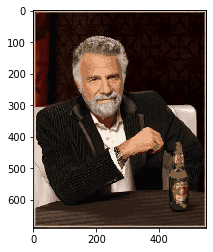

In [39]:
# K: number of cluster
K_test = [1, 4, 8, 16, 32]

for K in K_test:
    print("K: number of cluster: " + str(K))
    # step 1
    print("STEP 1:INITIALIZATIONS PARAMETER:")
    p, m, s = initialization_parameter(K, X)
    probability = mix_Gaussian(X, p, m, s, K)
    print(probability)
    t = 0
    convergence = False
    # Ο έλεγχος σύγκλισης γίνεται βάσει max_times και convergence 
    while t < max_times and convergence == False:
        print("!Time t=" + str(t) + "!")
        
        # step 2
        g_znk = E_step(probability)
        
        # step 3
        m, s, p = M_step(X, g_znk, K)
        
        # keep old, because we will recalculate and need old for convergence 
        probability_old = probability
        # need to calculate t+1 g_znk
        probability = mix_Gaussian(X, p, m, s, K)
        
        # step 4
        # συνάρτηση ελέγχου συγκλισης
        convergence = findTargetE(probability_old,probability, tolerance)
        
        t+=1
    N = X.shape[0]

    # x_true: real value of pixel. Dataset 
    x_true = X
    
    # X_r: value which predict from mixture
    # that is the value of mean "m" which corresponding posterior distribution "g_znk" is the maximum
    image_new =  np.zeros((all_pixels, channels))
    
    
    for n in range(N):
        image_new[n] = m[g_znk[n].argmax()]
    
    
    image_new = image_new.reshape((height, width, 3))
    save_image = m.shape[0]
    
    plt.imshow(image_new)
    plt.savefig('compressed_image_{}'.format(save_image))
    
    x_r = image_new.reshape((all_pixels, 3))
    # Calculate error reconstructing the image
    error = (1/N) * np.sum( np.linalg.norm(x_true - x_r)**2 )

    print("Error reconstructing the image: "+ str(error))

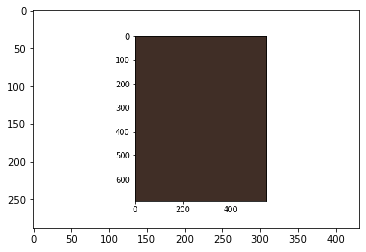

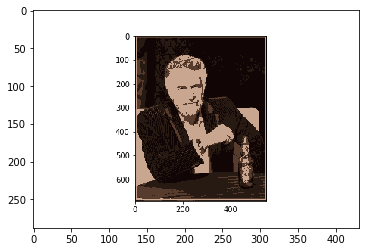

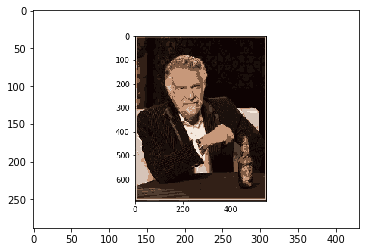

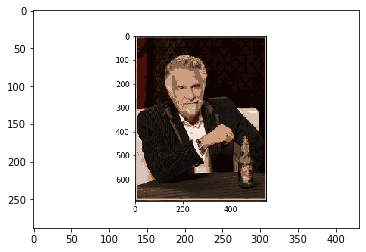

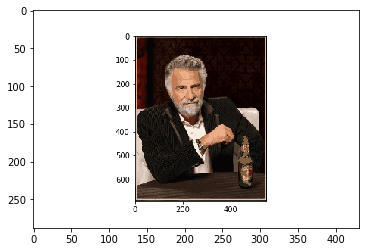

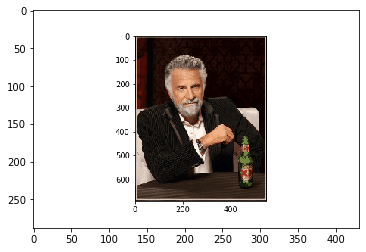

In [58]:
K_test = [1, 4, 8, 16, 32, 64]

for K in K_test:
    #print("Clusters: " + str(K))
    fileName = "compressed_image_"+str(K)+".png"
    img = mpimg.imread(fileName)
    plt.figure()
    plt.imshow(img)
